In [2]:
!pip install transformers torch nltk rouge_score

     |████████████████████████████████| 133 kB 7.4 MB/s eta 0:00:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=870add813cb0538fa9a34e9bff4e73d857b99b3534c1d71ed21c9e005690296a
  Stored in directory: /home/ubuntu/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge-score


In [23]:
import math
import random
import sys
import os
# from framework.utilities.models import inference    
from framework.utilities.metrics import calculate_bleu, calculate_rouge
import fastText
from contextlib import contextmanager
import time
import json
import wandb
import torch.nn.functional as F
import torch
from collections import deque

In [24]:
from power_monitoring.monitor import HWMonitor
import threading
import wandb

In [25]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [26]:
# combined_outputs["gsm8k"] = [{"input_text": None, "7b": None, "tiny": None, "13b": None} for _ in range(3000)]
# len(combined_outputs["gsm8k"])

# with open('data/input_output_train', 'wb') as f:
#     pickle.dump(combined_outputs, f)

In [27]:
import pickle
import pandas as pd

with open('data/input_output_train', 'rb') as file:
    combined_outputs = pickle.load(file)

df_combined_outputs = pd.DataFrame(combined_outputs)
df_combined_outputs.head()

,wmt14,cnn_dailymail,gsm8k
0,{'input_text': 'Gutach: Noch mehr Sicherheit f...,{'input_text': '(CNN)The Palestinian Authority...,"{'input_text': None, '7b': None, 'tiny': None,..."
1,{'input_text': 'Sie stehen keine 100 Meter von...,{'input_text': '(CNN)Never mind cats having ni...,"{'input_text': None, '7b': None, 'tiny': None,..."
2,{'input_text': 'Zwei Anlagen so nah beieinande...,{'input_text': '(CNN)If you've been following ...,"{'input_text': None, '7b': None, 'tiny': None,..."
3,{'input_text': 'Diese Frage hat Gutachs Bürger...,{'input_text': '(CNN)Five Americans who were m...,"{'input_text': None, '7b': None, 'tiny': None,..."
4,"{'input_text': '""Die Rathausampel ist damals i...",{'input_text': '(CNN)A Duke student has admitt...,"{'input_text': None, '7b': None, 'tiny': None,..."


In [28]:
df_combined_outputs.size

9000

In [29]:
df_combined_outputs["cnn_dailymail"][3]

{'input_text': "(CNN)Five Americans who were monitored for three weeks at an Omaha, Nebraska, hospital after being exposed to Ebola in West Africa have been released, a Nebraska Medicine spokesman said in an email Wednesday. One of the five had a heart-related issue on Saturday and has been discharged but hasn't left the area, Taylor Wilson wrote. The others have already gone home. They were exposed to Ebola in Sierra Leone in March, but none developed the deadly virus. They are clinicians for Partners in Health, a Boston-based aid group. They all had contact with a colleague who was diagnosed with the disease and is being treated at the National Institutes of Health in Bethesda, Maryland. As of Monday, that health care worker is in fair condition. The Centers for Disease Control and Prevention in Atlanta has said the last of 17 patients who were being monitored are expected to be released by Thursday. More than 10,000 people have died in a West African epidemic of Ebola that dates to 

In [30]:
def algorithm(T, V, h_tilde, c):
    l_predictor, s_predictor = None, None
    Q = 0.0 
    results = []

    l_loss_window = deque(maxlen=100)  
    s_loss_window = deque(maxlen=100)
    acc_window = deque(maxlen=100)

    for t in range(1, T+1):
        print(f"Index: {t}")
        t_i = df_combined_outputs["wmt14"][t]["input_text"]
        t_e = df_combined_outputs["wmt14"][t]["label"]

        p_t = min(1, c / math.sqrt(t))
        X_t = Bernoulli(p_t)

        l_loss, s_loss = None, None
        l_predicted_acc, s_predicted_acc = None, None

        g_large = 2.0
        g_small = 1.0  

        if X_t == 1:
            t_c = getResults(t, t_i, t_e)
            l_actual_acc = t_c['large_model_accuracy']
            s_actual_acc = t_c['small_model_accuracy']

            l_predictor, s_predictor, l_loss, s_loss = sgdStep(l_predictor, s_predictor, t_c)
            l_predictor, s_predictor = checkpoint(l_predictor, s_predictor, t, p_t)

            cost_large = V * g_large + Q * (h_tilde - l_actual_acc)
            cost_small = V * g_small + Q * (h_tilde - s_actual_acc)
        else:
            l_predicted_acc, s_predicted_acc = predict(t_i, l_predictor, s_predictor)

            cost_large = V * g_large + Q * (h_tilde - l_predicted_acc)
            cost_small = V * g_small + Q * (h_tilde - s_predicted_acc)

        if cost_large < cost_small:
            x_t = 'large'
            selected_acc = l_actual_acc if X_t == 1 else l_predicted_acc
        else:
            x_t = 'small'
            selected_acc = s_actual_acc if X_t == 1 else s_predicted_acc

        output, t_acc = querySelectedModel(t, t_e, x_t)

        if l_loss is not None:
            l_loss_window.append(l_loss)
        if s_loss is not None:
            s_loss_window.append(s_loss)
        acc_window.append(t_acc)

        smoothed_l_loss = moving_average(l_loss_window, window_size=1000)
        smoothed_s_loss = moving_average(s_loss_window, window_size=1000)
        smoothed_acc = moving_average(acc_window, window_size=1000)

        Q = max(0.0, Q + h_tilde - t_acc)
        log(results, t, t_i, output, smoothed_acc, smoothed_l_loss, smoothed_s_loss, 
            l_actual_acc if l_actual_acc is not None else l_predicted_acc, 
            s_actual_acc if s_actual_acc is not None else s_predicted_acc)

    return results

In [31]:
def algorithm(T, V, h_tilde, c):
    Q = 0.0 
    results = []

    acc_window = deque(maxlen=100)

    for t in range(1, T+1):
        print(f"Index: {t}")
        t_i = df_combined_outputs["wmt14"][t]["input_text"]
        t_e = df_combined_outputs["wmt14"][t]["label"]

        p_t = min(1, c / math.sqrt(t)) 
        X_t = Bernoulli(p_t)

        g_large = 2.0  
        g_small = 1.0  

        if X_t == 1:
            t_c = getResults(t, t_i, t_e)
            l_actual_acc = t_c['large_model_accuracy']
            s_actual_acc = t_c['small_model_accuracy']

            cost_large = V * g_large + Q * (h_tilde - l_actual_acc)
            cost_small = V * g_small + Q * (h_tilde - s_actual_acc)

        if cost_large < cost_small:
            x_t = 'large'
            selected_acc = l_actual_acc
        else:
            x_t = 'small'
            selected_acc = s_actual_acc

        output, t_acc = querySelectedModel(t, t_e, x_t)

        acc_window.append(t_acc)
        smoothed_acc = moving_average(acc_window, window_size=1000)

        Q = max(0.0, Q + h_tilde - t_acc)  
        
        log(results, t, t_i, output, smoothed_acc)

    return results

In [32]:
def log(results, t, t_i, output, t_acc, l_loss=None, s_loss=None, l_acc=None, s_acc=None):
    results.append({
        'iteration': t,
        'input': t_i,
        'best_output': output,
        'chosen_model_accuracy': t_acc,
        'l_loss': l_loss,
        's_loss': s_loss,
        'l_acc': l_acc,
        's_acc': s_acc
    })
    log_data = {
        'iteration': t,
        'chosen_model_accuracy': t_acc
    }
        
    if l_loss is not None: log_data['l_loss'] = l_loss
    if s_loss is not None: log_data['s_loss'] = s_loss
    if l_acc is not None: log_data['l_acc'] = l_acc
    if s_acc is not None: log_data['s_acc'] = s_acc
        
    wandb.log(log_data)

In [33]:
def Bernoulli(p_t):
    return random.random() < p_t 

In [34]:
def querySelectedModel(t, t_e, x_t):
    if x_t == "large":
        output = df_combined_outputs["wmt14"][t]["13b"]
    else:
        output =  df_combined_outputs["wmt14"][t]["tiny"]
        
    return output, calculate_bleu(output, t_e)

In [35]:
# def queryBest(t, t_i, t_e, l_predictor, s_predictor):
#     l_acc, s_acc = predict(t_i, l_predictor, s_predictor)
#     if l_acc > s_acc: # use larger model, e.g. 7b llama
#         output = df_combined_outputs["wmt14"][t]["13b"]
#     else: # use smaller model for all other cases, e.g. 3b llama
#         output =  df_combined_outputs["wmt14"][t]["tiny"]

#     return output, calculate_bleu(output, t_e)
#     # return output, calculate_rouge(output, t_e)

In [36]:
def moving_average(data, window_size):
    data_list = list(data)  
    if len(data_list) == 0:
        return 0.0 
    if len(data_list) < window_size:
        return sum(data_list) / len(data_list)
    return sum(data_list[-window_size:]) / window_size

In [37]:
def compute_mse_loss(predicted_accuracy, true_accuracy):
    predicted_tensor = torch.tensor([predicted_accuracy], dtype=torch.float32)
    true_tensor = torch.tensor([true_accuracy], dtype=torch.float32)

    loss = F.mse_loss(predicted_tensor, true_tensor)
    
    return loss.item()

In [38]:
def sgdStep(large_model_predictor, small_model_predictor, t_c):
    predicted_large_label, predicted_small_label = 0, 0
    if large_model_predictor and small_model_predictor != None: 
        predicted_large_label = large_model_predictor.predict(t_c['input_text'])[0][0].replace("__label__", "")
        predicted_small_label = small_model_predictor.predict(t_c['input_text'])[0][0].replace("__label__", "")
    
    with open("fasttext_large.txt", "w") as f:
        f.write(f"__label__{t_c['large_model_accuracy']} {t_c['input_text']}\n")
    with open("fasttext_small.txt", "w") as f:
        f.write(f"__label__{t_c['small_model_accuracy']} {t_c['input_text']}\n")

    if os.path.exists("large_predictor.bin"):
        large_model_predictor = fastText.train_supervised(input="fasttext_large.txt", epoch=1, lr=1.0, wordNgrams=2, inputModel="large_predictor.bin")
    else:
        large_model_predictor = fastText.train_supervised(input="fasttext_large.txt", epoch=1, lr=1.0, wordNgrams=2)

    if os.path.exists("small_predictor.bin"):
        small_model_predictor = fastText.train_supervised(input="fasttext_small.txt", epoch=1, lr=1.0, wordNgrams=2, inputModel="small_predictor.bin")
    else:
        small_model_predictor = fastText.train_supervised(input="fasttext_small.txt", epoch=1, lr=1.0, wordNgrams=2)

    large_model_loss = compute_mse_loss(float(predicted_large_label), t_c['large_model_accuracy'])
    small_model_loss = compute_mse_loss(float(predicted_small_label), t_c['small_model_accuracy'])

    # print(f"Large Stats(predicted, actual): {predicted_large_label}, {t_c['large_model_accuracy']}")
    # print(f"Mean Square Error: {large_model_loss}")
    # print(f"Small Stats(predicted, actual): {predicted_small_label}, {t_c['small_model_accuracy']}")
    # print(f"Mean Square Error: {large_model_loss}")

    return large_model_predictor, small_model_predictor, large_model_loss, small_model_loss

In [39]:
def predict(text, l_predictor, s_predictor):
    l_predicted_label = l_predictor.predict(text)[0][0]
    l_predicted_accuracy = int(round(float(l_predicted_label.replace('__label__', ''))))

    s_predicted_label = s_predictor.predict(text)[0][0]
    s_predicted_accuracy = int(round(float(s_predicted_label.replace('__label__', ''))))

    return l_predicted_accuracy, s_predicted_accuracy

In [40]:
def getResults(t, t_i, t_e):
    s_output = df_combined_outputs["wmt14"][t]["tiny"]
    l_output = df_combined_outputs["wmt14"][t]["13b"]
    
    # WMT14
    s_acc = calculate_bleu(s_output, t_e)
    l_acc = calculate_bleu(l_output, t_e)

    # CNN Dailymail
    # s_acc = calculate_rouge(s_output, t_e)['rouge1']
    # l_acc = calculate_rouge(l_output, t_e)['rouge1']

    return {
        'input_text': t_i,
        'large_model_accuracy': l_acc,
        'small_model_accuracy': s_acc
    }

In [41]:
def checkpoint(l_predictor, s_predictor, t, p_t):
    if p_t > 0.5:
        if t % int(math.sqrt(t)) == 0:
            print("Checkpoint")
            l_predictor, s_predictor = save_models(l_predictor, s_predictor)
    else:
        if t % max(1, int(1 / math.sqrt(t))) == 0:
            print("Checkpoint")
            l_predictor, s_predictor = save_models(l_predictor, s_predictor)

    return l_predictor, s_predictor

In [42]:
def save_models(l_predictor, s_predictor):
    if l_predictor:
        l_predictor.save_model("large_predictor.bin")
    if s_predictor:
        s_predictor.save_model("small_predictor.bin")

    return l_predictor, s_predictor

In [43]:
def run_and_record(T, V, h_tilde, c):
    wandb.init(project="classifier")
    stop_event = threading.Event()
    hw_monitor = HWMonitor(monitoring_freq=1.0, stop_event=threading.Event())
    hw_monitor.start()

    
    results = algorithm(T, V, h_tilde, c)

    stop_event.set() 
    hw_monitor.join()
    wandb.finish()

    return results

Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40
Index: 41
Index: 42
Index: 43
Index: 44
Index: 45
Index: 46
Index: 47
Index: 48
Index: 49
Index: 50
Index: 51
Index: 52
Index: 53
Index: 54
Index: 55
Index: 56
Index: 57
Index: 58
Index: 59
Index: 60
Index: 61
Index: 62
Index: 63
Index: 64
Index: 65
Index: 66
Index: 67
Index: 68
Index: 69
Index: 70
Index: 71
Index: 72
Index: 73
Index: 74
Index: 75
Index: 76
Index: 77
Index: 78
Index: 79
Index: 80
Index: 81
Index: 82
Index: 83
Index: 84
Index: 85
Index: 86
Index: 87
Index: 88
Index: 89
Index: 90
Index: 91
Index: 92
Index: 93
Index: 94
Index: 95
Index: 96
Index: 97
Index: 98
Index: 99
Index: 100
Index: 1

Exception in thread Thread-89:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/zry/Inferencing-Project/power_monitoring/monitor.py", line 43, in run
    wandb.log(all_res)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 452, in wrapper
    return func(self, *args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 413, in wrapper_fn
    raise errors.UsageError(resolved_message)
wandb.errors.UsageError: Run (f3kw0cmw) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.


bandwidth/disk_read_sys_bandwidth_mbs,▁▁▁▁
bandwidth/disk_write_sys_bandwidth_mbs,█▁▁▁
bandwidth/net_recv_sys_bandwidth_mbs,▁▇██
bandwidth/net_sent_sys_bandwidth_mbs,▁▇██
chosen_model_accuracy,▁▃▅▅▄▂▄▅▂▄▁▂▇▄▅▂▇▇▇▆▅▇▅▄▅█▅▄▄▅▃▃█▃▂▆▄▅▇▂
cpu/interrupts/global_ctx_switches_count,▁▃▆█
cpu/interrupts/global_interrupts_count,▁▃▆█
cpu/interrupts/global_soft_interrupts_count,▁▃▆█
cpu/load/avg_sys_load_fifteen_min_percent,▁▁▁▁
cpu/load/avg_sys_load_five_min_percent,▁▁██
cpu/load/avg_sys_load_one_min_percent,▁▁██


Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40
Index: 41
Index: 42
Index: 43
Index: 44
Index: 45
Index: 46
Index: 47
Index: 48
Index: 49
Index: 50
Index: 51
Index: 52
Index: 53
Index: 54
Index: 55
Index: 56
Index: 57
Index: 58
Index: 59
Index: 60
Index: 61
Index: 62
Index: 63
Index: 64
Index: 65
Index: 66
Index: 67
Index: 68
Index: 69
Index: 70
Index: 71
Index: 72
Index: 73
Index: 74
Index: 75
Index: 76
Index: 77
Index: 78
Index: 79
Index: 80
Index: 81
Index: 82
Index: 83
Index: 84
Index: 85
Index: 86
Index: 87
Index: 88
Index: 89
Index: 90
Index: 91
Index: 92
Index: 93
Index: 94
Index: 95
Index: 96
Index: 97
Index: 98
Index: 99
Index: 100
Index: 1

Exception in thread Thread-99:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/zry/Inferencing-Project/power_monitoring/monitor.py", line 43, in run
    wandb.log(all_res)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 452, in wrapper
    return func(self, *args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 413, in wrapper_fn
    raise errors.UsageError(resolved_message)
wandb.errors.UsageError: Run (1o12yoad) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.


bandwidth/disk_read_sys_bandwidth_mbs,▁▁▁▁
bandwidth/disk_write_sys_bandwidth_mbs,▁█▁▁
bandwidth/net_recv_sys_bandwidth_mbs,▁▇██
bandwidth/net_sent_sys_bandwidth_mbs,▁▇██
chosen_model_accuracy,▁▅▅▅▅▅▄▄▅▄▅▅▅▅▅▆▆▅▇▇▅▆▆▇▆▇▇▅▅▅▅▆▆▅█▇▇▇▇▆
cpu/interrupts/global_ctx_switches_count,▁▃▆█
cpu/interrupts/global_interrupts_count,▁▃▆█
cpu/interrupts/global_soft_interrupts_count,▁▃▆█
cpu/load/avg_sys_load_fifteen_min_percent,▁▁▁▁
cpu/load/avg_sys_load_five_min_percent,▁▁▁▁
cpu/load/avg_sys_load_one_min_percent,▁▁▁▁


Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40
Index: 41
Index: 42
Index: 43
Index: 44
Index: 45
Index: 46
Index: 47
Index: 48
Index: 49
Index: 50
Index: 51
Index: 52
Index: 53
Index: 54
Index: 55
Index: 56
Index: 57
Index: 58
Index: 59
Index: 60
Index: 61
Index: 62
Index: 63
Index: 64
Index: 65
Index: 66
Index: 67
Index: 68
Index: 69
Index: 70
Index: 71
Index: 72
Index: 73
Index: 74
Index: 75
Index: 76
Index: 77
Index: 78
Index: 79
Index: 80
Index: 81
Index: 82
Index: 83
Index: 84
Index: 85
Index: 86
Index: 87
Index: 88
Index: 89
Index: 90
Index: 91
Index: 92
Index: 93
Index: 94
Index: 95
Index: 96
Index: 97
Index: 98
Index: 99
Index: 100
Index: 1

Exception in thread Thread-109:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/zry/Inferencing-Project/power_monitoring/monitor.py", line 43, in run
    wandb.log(all_res)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 452, in wrapper
    return func(self, *args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 413, in wrapper_fn
    raise errors.UsageError(resolved_message)
wandb.errors.UsageError: Run (ldylaxhj) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.


bandwidth/disk_read_sys_bandwidth_mbs,▁▁▁▁
bandwidth/disk_write_sys_bandwidth_mbs,▁▁▁▁
bandwidth/net_recv_sys_bandwidth_mbs,▁▇██
bandwidth/net_sent_sys_bandwidth_mbs,▁▇██
chosen_model_accuracy,▁▁▄▅▆▅▆▆▄▃▄▃▄▃▃▃▆▅▆▇▇▆▆▆▇▇▆▇▅▄▅▄██▆▄▅▆█▆
cpu/interrupts/global_ctx_switches_count,▁▃▆█
cpu/interrupts/global_interrupts_count,▁▃▆█
cpu/interrupts/global_soft_interrupts_count,▁▃▆█
cpu/load/avg_sys_load_fifteen_min_percent,▁▁▁▁
cpu/load/avg_sys_load_five_min_percent,▁███
cpu/load/avg_sys_load_one_min_percent,▁███


Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40
Index: 41
Index: 42
Index: 43
Index: 44
Index: 45
Index: 46
Index: 47
Index: 48
Index: 49
Index: 50
Index: 51
Index: 52
Index: 53
Index: 54
Index: 55
Index: 56
Index: 57
Index: 58
Index: 59
Index: 60
Index: 61
Index: 62
Index: 63
Index: 64
Index: 65
Index: 66
Index: 67
Index: 68
Index: 69
Index: 70
Index: 71
Index: 72
Index: 73
Index: 74
Index: 75
Index: 76
Index: 77
Index: 78
Index: 79
Index: 80
Index: 81
Index: 82
Index: 83
Index: 84
Index: 85
Index: 86
Index: 87
Index: 88
Index: 89
Index: 90
Index: 91
Index: 92
Index: 93
Index: 94
Index: 95
Index: 96
Index: 97
Index: 98
Index: 99
Index: 100
Index: 1

Exception in thread Thread-119:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/zry/Inferencing-Project/power_monitoring/monitor.py", line 43, in run
    wandb.log(all_res)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 452, in wrapper
    return func(self, *args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 413, in wrapper_fn
    raise errors.UsageError(resolved_message)
wandb.errors.UsageError: Run (so7dp82f) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.


bandwidth/disk_read_sys_bandwidth_mbs,▁▁▁▁
bandwidth/disk_write_sys_bandwidth_mbs,▁█▁▁
bandwidth/net_recv_sys_bandwidth_mbs,▁▅██
bandwidth/net_sent_sys_bandwidth_mbs,▁▅██
chosen_model_accuracy,▁▂▂▅▄▆▅▆▃▃▃▅▃▄▅▄▄▅▁▅▅▅▅▇▅▇▇▇▄▄▇▅▆▃▄▃▄▅█▄
cpu/interrupts/global_ctx_switches_count,▁▃▆█
cpu/interrupts/global_interrupts_count,▁▃▆█
cpu/interrupts/global_soft_interrupts_count,▁▃▅█
cpu/load/avg_sys_load_fifteen_min_percent,▁▁▁█
cpu/load/avg_sys_load_five_min_percent,▁▁▁█
cpu/load/avg_sys_load_one_min_percent,▁▁▁█


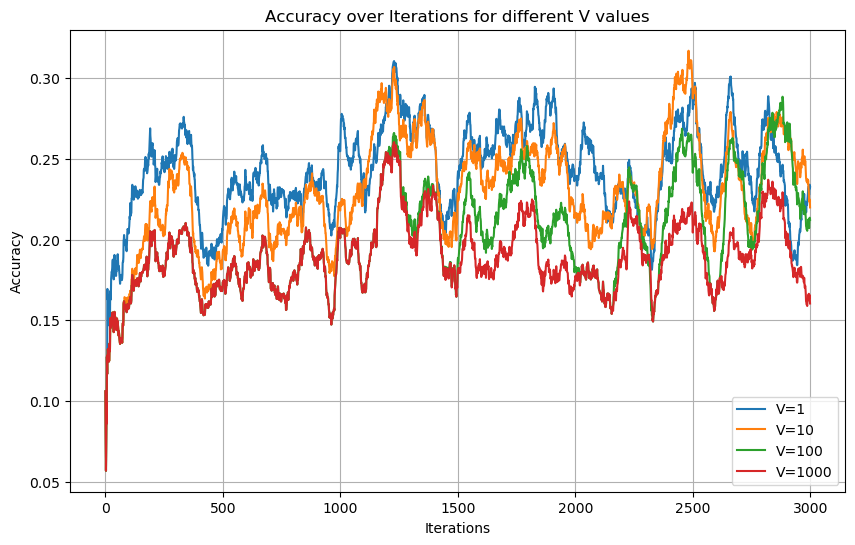

In [44]:
import json
import matplotlib.pyplot as plt

V_values = [1, 10, 100, 1000]
T = 2999
h_tilde = 0.5
c = 5

for V in V_values:
    results = run_and_record(T, V, h_tilde, c)

    with open(f'experiments/fasttext/actual-V{V}-fasttext-wmt14-h5.json', 'w') as f:
        json.dump(results, f, indent=4)

plt.figure(figsize=(10, 6))

for V in V_values:
    with open(f'experiments/fasttext/actual-V{V}-fasttext-wmt14-h5.json', 'r') as f:
        results = json.load(f)

    accuracies = [result['chosen_model_accuracy'] for result in results]
    plt.plot(range(1, T+1), accuracies, label=f'V={V}')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy over Iterations for different V values')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
results = run_and_record(2999, 10000, .1, 5)

with open('experiments/fasttext/V10000-fasttext-wmt14-h1', 'w') as f:
    json.dump(results, f, indent=4)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ryanzhangofficial (ryzhangofficial). Use `wandb login --relogin` to force relogin


Index: 1


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39728 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  223062 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100609 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31042 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 3


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58886 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23539 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 4


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24811 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71109 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 5


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62802 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55481 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 6


start training...
Progress: 100.0% words/sec/thread:  127921 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47828 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 7


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  194029 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 8


start training...
Progress: 100.0% words/sec/thread:   39704 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36379 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 9


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31276 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33839 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 10


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70365 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45646 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 11


start training...
Progress: 100.0% words/sec/thread:   55276 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78983 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 12


start training...
Progress: 100.0% words/sec/thread:   11684 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31979 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 13


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  128292 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44565 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1


Index: 14


start training...
Progress: 100.0% words/sec/thread:  148247 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69915 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1


Index: 15


start training...
Progress: 100.0% words/sec/thread:   12196 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   12191 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 16


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60790 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63475 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 17


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19563 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59939 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 18


start training...
Progress: 100.0% words/sec/thread:   34591 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63405 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1


Index: 19


start training...
Progress: 100.0% words/sec/thread:  101068 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25502 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 20


start training...
Progress: 100.0% words/sec/thread:  167647 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99854 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 21


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73341 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22935 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 22


start training...
Progress: 100.0% words/sec/thread:   77112 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23985 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1


Index: 23


start training...
Progress: 100.0% words/sec/thread:   74938 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83710 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 24


start training...
Progress: 100.0% words/sec/thread:   47681 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79010 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 25


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  175953 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52953 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 26


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104319 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37674 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1


Index: 27


start training...
Progress: 100.0% words/sec/thread:   80420 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  245200 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1


Index: 28


start training...
Progress: 100.0% words/sec/thread:  157148 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42294 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1


Index: 29


start training...
Progress: 100.0% words/sec/thread:   42450 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  111363 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1


Index: 30
Index: 31


start training...
Progress: 100.0% words/sec/thread:   29673 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21446 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 32
Index: 33


start training...
Progress: 100.0% words/sec/thread:  151187 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17884 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 34


start training...
Progress: 100.0% words/sec/thread:   90945 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28868 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1


Index: 35


start training...
Progress: 100.0% words/sec/thread:   63194 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52837 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 36


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98360 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29508 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 37


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76045 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63254 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 38


start training...
Progress: 100.0% words/sec/thread:   35514 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22033 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1


Index: 39


start training...
Progress: 100.0% words/sec/thread:   40734 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33806 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  33
Number of labels: 1


Index: 40


start training...
Progress: 100.0% words/sec/thread:   83013 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21831 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1


Index: 41


start training...
Progress: 100.0% words/sec/thread:  119378 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81254 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 42


start training...
Progress: 100.0% words/sec/thread:   39519 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116241 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 43


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74751 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23830 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1


Index: 44


start training...
Progress: 100.0% words/sec/thread:   53407 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69337 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1


Index: 45


start training...
Progress: 100.0% words/sec/thread:   87981 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92155 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 46


start training...
Progress: 100.0% words/sec/thread:  117465 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71227 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1


Index: 47


start training...
Progress: 100.0% words/sec/thread:   11993 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23247 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1


Index: 48
Index: 49


start training...
Progress: 100.0% words/sec/thread:   57591 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36820 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 50
Index: 51
Index: 52
Index: 53


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53412 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101641 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1


Index: 54


start training...
Progress: 100.0% words/sec/thread:   59907 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59530 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  20
Number of labels: 1


Index: 55
Index: 56


start training...
Progress: 100.0% words/sec/thread:   49220 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17700 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 57


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76870 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67919 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1


Index: 58


start training...
Progress: 100.0% words/sec/thread:   59559 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75662 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 59


start training...
Progress: 100.0% words/sec/thread:  135354 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61721 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1


Index: 60


start training...
Progress: 100.0% words/sec/thread:   47685 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42438 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1


Index: 61


start training...
Progress: 100.0% words/sec/thread:   72842 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31429 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1


Index: 62


start training...
Progress: 100.0% words/sec/thread:   64358 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49083 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1


Index: 63


start training...
Progress: 100.0% words/sec/thread:   44674 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  152707 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 64


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22557 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36879 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 65
Index: 66
Index: 67


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70716 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34504 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1


Index: 68


start training...
Progress: 100.0% words/sec/thread:  178375 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57304 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 69


start training...
Progress: 100.0% words/sec/thread:   95829 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  136882 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 70
Index: 71


start training...
Progress: 100.0% words/sec/thread:  112059 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  124307 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1


Index: 72


start training...
Progress: 100.0% words/sec/thread:   35231 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57142 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 73


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  157303 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42544 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1


Index: 74


start training...
Progress: 100.0% words/sec/thread:   28840 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69417 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1


Index: 75


start training...
Progress: 100.0% words/sec/thread:   28257 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73766 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1


Index: 76


start training...
Progress: 100.0% words/sec/thread:   58887 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81602 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1


Index: 77
Index: 78


start training...
Progress: 100.0% words/sec/thread:   86439 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21424 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1


Index: 79


start training...
Progress: 100.0% words/sec/thread:  133333 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76980 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1


Index: 80


start training...
Progress: 100.0% words/sec/thread:  103734 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37890 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 81
Index: 82


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48151 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  145723 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1


Index: 83


start training...
Progress: 100.0% words/sec/thread:   56236 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121406 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1


Index: 84
Index: 85


start training...
Progress: 100.0% words/sec/thread:   43392 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71802 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1


Index: 86


start training...
Progress: 100.0% words/sec/thread:   90322 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27477 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1


Index: 87
Index: 88


start training...
Progress: 100.0% words/sec/thread:   49064 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58436 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1


Index: 89
Index: 90
Index: 91


start training...
Progress: 100.0% words/sec/thread:   51764 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74948 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 92
Index: 93


start training...
Progress: 100.0% words/sec/thread:   49252 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68717 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1


Index: 94


start training...
Progress: 100.0% words/sec/thread:  106149 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34430 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 95
Index: 96


start training...
Progress: 100.0% words/sec/thread:   27637 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  122764 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1


Index: 97
Index: 98


start training...
Progress: 100.0% words/sec/thread:   26657 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21375 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1


Index: 99
Index: 100
Index: 101


start training...
Progress: 100.0% words/sec/thread:  109095 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82168 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 102


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  117113 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46209 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 103
Index: 104
Index: 105


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46312 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42113 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 106


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93062 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61815 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 107


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  180602 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56916 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 108


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108161 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79384 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 109


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  251410 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68582 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 110


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71289 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85178 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 111


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47004 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64577 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 112
Index: 113
Index: 114
Index: 115


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  162561 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41322 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 116


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54074 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72068 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 117


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44886 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77417 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 118
Index: 119
Index: 120
Index: 121
Index: 122


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77738 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24165 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 123
Index: 124
Index: 125


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80348 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109425 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 126


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  162241 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29620 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 127
Index: 128


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63120 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    9771 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 129


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51015 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98484 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 130


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79528 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14762 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 131


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66889 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89138 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 132


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43400 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25718 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 133


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50831 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  265691 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 134


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39252 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96446 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 135
Index: 136
Index: 137
Index: 138


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140805 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48790 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 139
Index: 140


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  133755 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51409 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 141
Index: 142
Index: 143
Index: 144
Index: 145


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39144 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20559 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 146
Index: 147


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52182 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23744 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 148
Index: 149
Index: 150
Index: 151
Index: 152
Index: 153
Index: 154
Index: 155


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72649 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49896 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 156
Index: 157
Index: 158
Index: 159


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31514 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44226 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 160


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55158 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  133375 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 161


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50731 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107271 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 162
Index: 163


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48639 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73610 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 164
Index: 165


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  197413 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  124752 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 166
Index: 167
Index: 168


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25768 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  151515 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 169


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55106 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73094 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 170
Index: 171
Index: 172
Index: 173
Index: 174


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  192901 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34754 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 175
Index: 176


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53071 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51786 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 177
Index: 178
Index: 179
Index: 180
Index: 181


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33762 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37388 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 182
Index: 183
Index: 184
Index: 185


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44027 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23032 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 186
Index: 187
Index: 188
Index: 189
Index: 190
Index: 191


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29629 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14882 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 192
Index: 193
Index: 194
Index: 195
Index: 196
Index: 197
Index: 198


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  148749 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53217 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 199
Index: 200


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53186 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42612 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 201
Index: 202


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11048 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102154 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 203


Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22682 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36997 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 204
Index: 205


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46354 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58247 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 206
Index: 207


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68306 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48910 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 208
Index: 209
Index: 210
Index: 211
Index: 212
Index: 213
Index: 214
Index: 215
Index: 216


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31151 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21772 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 217
Index: 218
Index: 219


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80297 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108244 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 220


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54012 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35370 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 221


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38043 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23421 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 222
Index: 223


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  165137 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60016 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 224
Index: 225
Index: 226


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  230538 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81902 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 227
Index: 228


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45188 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43601 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 229
Index: 230
Index: 231
Index: 232
Index: 233
Index: 234
Index: 235
Index: 236


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36180 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100844 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 237
Index: 238
Index: 239
Index: 240
Index: 241


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19551 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77253 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 242


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  149118 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40072 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 243
Index: 244
Index: 245


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104157 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21489 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 246
Index: 247
Index: 248
Index: 249
Index: 250
Index: 251
Index: 252
Index: 253
Index: 254
Index: 255


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40208 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42386 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 256
Index: 257
Index: 258
Index: 259
Index: 260
Index: 261
Index: 262
Index: 263


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39194 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30552 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 264


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46240 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61764 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 265
Index: 266


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38263 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39416 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 267
Index: 268
Index: 269
Index: 270
Index: 271
Index: 272


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  174346 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  117102 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 273
Index: 274
Index: 275
Index: 276


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107055 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23444 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 277


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72934 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24017 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 278
Index: 279
Index: 280
Index: 281


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44004 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69349 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 282


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80186 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59274 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 283
Index: 284
Index: 285
Index: 286
Index: 287


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25415 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41415 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 288


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  159135 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84935 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 289
Index: 290
Index: 291


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99433 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25531 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 292
Index: 293
Index: 294


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82709 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74910 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 295
Index: 296
Index: 297


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84897 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30462 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 298


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96514 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17569 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 299
Index: 300


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48801 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  122340 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 301
Index: 302


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47515 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114278 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 303


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52527 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107222 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 304


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66115 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67056 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 305


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63010 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20837 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 306


Read 0M words
Number of words:  49
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  161791 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  49
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140812 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 307
Index: 308


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  125941 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  185973 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 309
Index: 310
Index: 311
Index: 312
Index: 313


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36943 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22073 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 314
Index: 315
Index: 316


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  191387 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65183 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 317
Index: 318
Index: 319
Index: 320
Index: 321
Index: 322
Index: 323
Index: 324
Index: 325
Index: 326
Index: 327


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42363 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48341 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 328


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33831 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58885 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 329
Index: 330
Index: 331
Index: 332
Index: 333
Index: 334
Index: 335


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  138092 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  118026 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 336
Index: 337
Index: 338
Index: 339
Index: 340
Index: 341
Index: 342


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  189285 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  118097 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 343
Index: 344
Index: 345


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30959 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30935 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 346
Index: 347


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38828 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23284 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 348
Index: 349


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65429 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20908 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 350


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42009 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16912 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 351
Index: 352
Index: 353
Index: 354
Index: 355
Index: 356
Index: 357


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59523 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22012 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 358
Index: 359
Index: 360
Index: 361


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61861 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  125000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 362
Index: 363
Index: 364
Index: 365
Index: 366
Index: 367


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42400 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22559 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 368
Index: 369
Index: 370
Index: 371
Index: 372
Index: 373
Index: 374
Index: 375
Index: 376


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77746 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14481 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 377
Index: 378
Index: 379
Index: 380
Index: 381
Index: 382
Index: 383
Index: 384
Index: 385


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74792 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36486 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 386
Index: 387


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42184 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21840 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 388
Index: 389
Index: 390


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  105919 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  137474 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 391
Index: 392


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51657 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26172 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 393
Index: 394
Index: 395
Index: 396


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46016 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60295 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 397
Index: 398
Index: 399
Index: 400


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46119 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64590 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 401
Index: 402
Index: 403
Index: 404


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  188671 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34320 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 405
Index: 406
Index: 407


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97307 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75671 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 408
Index: 409
Index: 410
Index: 411


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  220930 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35917 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 412
Index: 413
Index: 414
Index: 415
Index: 416
Index: 417
Index: 418
Index: 419
Index: 420
Index: 421
Index: 422


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45257 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  216690 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 423
Index: 424
Index: 425
Index: 426
Index: 427
Index: 428
Index: 429
Index: 430


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16058 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49773 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 431
Index: 432
Index: 433
Index: 434
Index: 435
Index: 436
Index: 437
Index: 438
Index: 439
Index: 440
Index: 441
Index: 442
Index: 443
Index: 444


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59907 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40569 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 445
Index: 446


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46147 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66727 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 447
Index: 448
Index: 449


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18912 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21443 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 450
Index: 451
Index: 452
Index: 453
Index: 454
Index: 455


Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27696 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23806 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 456
Index: 457
Index: 458
Index: 459


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48530 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63636 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 460
Index: 461
Index: 462
Index: 463
Index: 464
Index: 465
Index: 466


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46431 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97524 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 467
Index: 468
Index: 469
Index: 470
Index: 471
Index: 472
Index: 473
Index: 474
Index: 475
Index: 476


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62982 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  150845 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 477


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65454 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89576 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 478
Index: 479
Index: 480
Index: 481
Index: 482


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  120418 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15896 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 483
Index: 484
Index: 485


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48175 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92612 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 486
Index: 487


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27881 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41824 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 488
Index: 489
Index: 490
Index: 491
Index: 492
Index: 493
Index: 494
Index: 495
Index: 496
Index: 497
Index: 498


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97379 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  144125 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 499
Index: 500
Index: 501
Index: 502
Index: 503
Index: 504


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46237 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25826 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 505
Index: 506
Index: 507
Index: 508
Index: 509
Index: 510
Index: 511
Index: 512
Index: 513
Index: 514
Index: 515
Index: 516
Index: 517
Index: 518
Index: 519
Index: 520
Index: 521
Index: 522
Index: 523
Index: 524
Index: 525


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101078 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50196 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 526


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50383 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50822 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 527


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84592 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54760 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 528
Index: 529
Index: 530
Index: 531
Index: 532


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50361 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34449 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 533
Index: 534


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20480 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45597 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 535


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43677 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73269 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 536
Index: 537


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27062 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19972 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 538


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85590 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38752 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 539
Index: 540
Index: 541
Index: 542


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93812 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34131 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 543
Index: 544
Index: 545
Index: 546


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22031 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42514 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 547


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77182 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44444 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 548
Index: 549
Index: 550
Index: 551
Index: 552
Index: 553


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41025 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31500 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 554


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140787 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21621 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 555
Index: 556


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45871 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64414 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 557
Index: 558


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57465 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21726 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 559
Index: 560


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108788 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27478 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 561
Index: 562
Index: 563
Index: 564
Index: 565


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29255 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  127831 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 566


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77792 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97069 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 567


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36847 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43434 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 568
Index: 569
Index: 570


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  127306 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19893 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 571
Index: 572
Index: 573
Index: 574
Index: 575
Index: 576
Index: 577
Index: 578
Index: 579
Index: 580
Index: 581
Index: 582
Index: 583
Index: 584


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  182291 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103106 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 585
Index: 586
Index: 587
Index: 588
Index: 589
Index: 590
Index: 591
Index: 592


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85440 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39494 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 593
Index: 594


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67127 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112106 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 595
Index: 596
Index: 597
Index: 598
Index: 599
Index: 600
Index: 601
Index: 602


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52459 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26826 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 603
Index: 604
Index: 605
Index: 606
Index: 607


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22408 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18175 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 608
Index: 609
Index: 610


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  360841 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42115 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 611
Index: 612
Index: 613
Index: 614
Index: 615
Index: 616
Index: 617
Index: 618
Index: 619
Index: 620
Index: 621
Index: 622


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59405 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  263601 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 623
Index: 624


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  189719 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22397 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 625
Index: 626
Index: 627
Index: 628
Index: 629
Index: 630


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121645 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112500 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 631
Index: 632
Index: 633
Index: 634
Index: 635
Index: 636
Index: 637
Index: 638
Index: 639


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  125984 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31311 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 640
Index: 641
Index: 642
Index: 643
Index: 644


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35033 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86857 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 645
Index: 646
Index: 647


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134693 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  145760 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 648
Index: 649


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35139 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43487 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 650


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35335 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45474 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 651
Index: 652
Index: 653
Index: 654
Index: 655
Index: 656
Index: 657
Index: 658
Index: 659
Index: 660
Index: 661
Index: 662
Index: 663
Index: 664
Index: 665
Index: 666
Index: 667
Index: 668
Index: 669
Index: 670
Index: 671


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60890 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  167510 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 672


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35040 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21018 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 673


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70033 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22227 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 674
Index: 675
Index: 676
Index: 677
Index: 678
Index: 679
Index: 680
Index: 681
Index: 682
Index: 683
Index: 684
Index: 685


Read 0M words
Number of words:  38
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116983 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  38
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  137801 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 686
Index: 687
Index: 688
Index: 689
Index: 690
Index: 691
Index: 692
Index: 693


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  185089 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  125960 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 694
Index: 695
Index: 696
Index: 697
Index: 698
Index: 699
Index: 700
Index: 701


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41925 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33892 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 702
Index: 703
Index: 704
Index: 705
Index: 706


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79984 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24576 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 707
Index: 708


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79151 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23499 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 709


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80357 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33866 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 710
Index: 711
Index: 712


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24337 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25322 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 713
Index: 714
Index: 715
Index: 716
Index: 717
Index: 718
Index: 719


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48454 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71688 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 720
Index: 721
Index: 722
Index: 723
Index: 724


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52284 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80244 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 725
Index: 726


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37366 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18551 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 727


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45996 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41221 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 728
Index: 729
Index: 730
Index: 731
Index: 732
Index: 733
Index: 734
Index: 735
Index: 736


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134585 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25241 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 737
Index: 738
Index: 739
Index: 740


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40951 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103883 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 741


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86451 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66115 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 742
Index: 743
Index: 744
Index: 745
Index: 746
Index: 747
Index: 748
Index: 749
Index: 750
Index: 751
Index: 752
Index: 753
Index: 754
Index: 755
Index: 756
Index: 757
Index: 758
Index: 759
Index: 760
Index: 761
Index: 762
Index: 763
Index: 764
Index: 765
Index: 766
Index: 767
Index: 768
Index: 769
Index: 770
Index: 771
Index: 772
Index: 773
Index: 774
Index: 775
Index: 776
Index: 777
Index: 778
Index: 779


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53061 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24436 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 780
Index: 781
Index: 782


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96609 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72727 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 783
Index: 784
Index: 785
Index: 786
Index: 787


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  146236 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37817 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 788
Index: 789
Index: 790
Index: 791
Index: 792


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55496 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74166 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 793
Index: 794


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42544 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42072 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 795
Index: 796
Index: 797
Index: 798
Index: 799
Index: 800


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41855 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30410 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 801
Index: 802
Index: 803
Index: 804
Index: 805
Index: 806
Index: 807
Index: 808
Index: 809


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45920 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48607 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 810


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16817 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42738 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 811
Index: 812
Index: 813
Index: 814
Index: 815
Index: 816
Index: 817
Index: 818
Index: 819
Index: 820
Index: 821
Index: 822


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  174633 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  131436 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 823
Index: 824
Index: 825
Index: 826


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59317 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52910 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 827


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  127118 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21926 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 828
Index: 829
Index: 830
Index: 831
Index: 832


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26660 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123545 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 833
Index: 834
Index: 835
Index: 836
Index: 837
Index: 838


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  222623 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  164692 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 839
Index: 840


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71059 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49931 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 841
Index: 842
Index: 843
Index: 844
Index: 845
Index: 846
Index: 847
Index: 848
Index: 849
Index: 850


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37616 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65531 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 851
Index: 852
Index: 853
Index: 854


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47134 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40303 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 855
Index: 856
Index: 857
Index: 858
Index: 859
Index: 860
Index: 861
Index: 862
Index: 863
Index: 864
Index: 865
Index: 866
Index: 867
Index: 868
Index: 869
Index: 870
Index: 871
Index: 872
Index: 873


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60555 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35060 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 874
Index: 875
Index: 876
Index: 877


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107287 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26715 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 878


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53684 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48545 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 879
Index: 880
Index: 881
Index: 882
Index: 883
Index: 884
Index: 885
Index: 886
Index: 887
Index: 888
Index: 889
Index: 890
Index: 891
Index: 892
Index: 893
Index: 894
Index: 895
Index: 896
Index: 897


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  132358 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27927 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 898
Index: 899
Index: 900
Index: 901
Index: 902
Index: 903


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68511 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45266 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 904


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67748 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20638 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 905
Index: 906
Index: 907
Index: 908
Index: 909
Index: 910
Index: 911
Index: 912
Index: 913
Index: 914
Index: 915
Index: 916
Index: 917
Index: 918
Index: 919
Index: 920
Index: 921
Index: 922
Index: 923
Index: 924
Index: 925
Index: 926
Index: 927


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49468 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86330 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 928
Index: 929
Index: 930
Index: 931
Index: 932


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56618 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18836 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 933
Index: 934
Index: 935
Index: 936
Index: 937
Index: 938
Index: 939
Index: 940
Index: 941
Index: 942


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23850 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36859 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 943
Index: 944
Index: 945


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99195 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  126180 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 946
Index: 947


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98851 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73259 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 948
Index: 949


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40726 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20130 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 950
Index: 951
Index: 952
Index: 953


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  111397 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57203 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 954
Index: 955
Index: 956
Index: 957
Index: 958
Index: 959
Index: 960
Index: 961
Index: 962
Index: 963
Index: 964
Index: 965
Index: 966
Index: 967
Index: 968
Index: 969
Index: 970
Index: 971
Index: 972
Index: 973
Index: 974
Index: 975
Index: 976
Index: 977
Index: 978
Index: 979


Read 0M words
Number of words:  43
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  146900 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  43
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38409 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 980
Index: 981
Index: 982


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  130253 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51728 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 983
Index: 984
Index: 985
Index: 986


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72738 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31108 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 987
Index: 988
Index: 989
Index: 990
Index: 991
Index: 992


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56352 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88931 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 993
Index: 994
Index: 995
Index: 996


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49300 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56853 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 997
Index: 998
Index: 999
Index: 1000
Index: 1001
Index: 1002
Index: 1003
Index: 1004
Index: 1005
Index: 1006
Index: 1007
Index: 1008
Index: 1009
Index: 1010
Index: 1011
Index: 1012
Index: 1013
Index: 1014
Index: 1015
Index: 1016
Index: 1017
Index: 1018
Index: 1019
Index: 1020
Index: 1021
Index: 1022
Index: 1023
Index: 1024
Index: 1025
Index: 1026


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  176339 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31258 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1027


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38305 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40131 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1028
Index: 1029
Index: 1030


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79974 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85005 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1031
Index: 1032
Index: 1033
Index: 1034
Index: 1035
Index: 1036
Index: 1037


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33457 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59497 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1038
Index: 1039


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43469 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17825 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1040
Index: 1041
Index: 1042


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52333 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56241 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1043
Index: 1044
Index: 1045
Index: 1046
Index: 1047
Index: 1048
Index: 1049
Index: 1050
Index: 1051


Read 0M words
Number of words:  38
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  241686 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  38
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134119 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1052
Index: 1053
Index: 1054


Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  202510 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  201209 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1055
Index: 1056
Index: 1057
Index: 1058
Index: 1059
Index: 1060
Index: 1061
Index: 1062
Index: 1063
Index: 1064
Index: 1065


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83140 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23676 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1066
Index: 1067


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50509 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  126041 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1068


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35789 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59189 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1069
Index: 1070
Index: 1071
Index: 1072
Index: 1073
Index: 1074
Index: 1075
Index: 1076
Index: 1077
Index: 1078


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57321 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28054 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1079
Index: 1080
Index: 1081
Index: 1082
Index: 1083
Index: 1084
Index: 1085
Index: 1086
Index: 1087
Index: 1088
Index: 1089
Index: 1090
Index: 1091


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81999 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58146 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1092
Index: 1093
Index: 1094
Index: 1095
Index: 1096
Index: 1097
Index: 1098
Index: 1099
Index: 1100
Index: 1101
Index: 1102
Index: 1103
Index: 1104
Index: 1105
Index: 1106
Index: 1107
Index: 1108
Index: 1109
Index: 1110
Index: 1111
Index: 1112
Index: 1113
Index: 1114
Index: 1115
Index: 1116
Index: 1117


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25762 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15956 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1118
Index: 1119
Index: 1120
Index: 1121
Index: 1122
Index: 1123
Index: 1124
Index: 1125
Index: 1126
Index: 1127
Index: 1128
Index: 1129
Index: 1130
Index: 1131
Index: 1132


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  201129 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21026 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1133
Index: 1134
Index: 1135
Index: 1136
Index: 1137
Index: 1138
Index: 1139
Index: 1140
Index: 1141
Index: 1142
Index: 1143
Index: 1144
Index: 1145
Index: 1146
Index: 1147


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42708 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33799 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1148
Index: 1149
Index: 1150
Index: 1151
Index: 1152
Index: 1153


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38838 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27472 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1154
Index: 1155


Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22540 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    8561 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1156
Index: 1157
Index: 1158
Index: 1159
Index: 1160
Index: 1161
Index: 1162
Index: 1163
Index: 1164
Index: 1165
Index: 1166
Index: 1167
Index: 1168
Index: 1169
Index: 1170
Index: 1171
Index: 1172
Index: 1173
Index: 1174
Index: 1175


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35581 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59557 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1176
Index: 1177
Index: 1178
Index: 1179
Index: 1180
Index: 1181
Index: 1182


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21299 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39061 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1183


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55771 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  133434 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1184
Index: 1185
Index: 1186
Index: 1187
Index: 1188
Index: 1189
Index: 1190
Index: 1191


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46470 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47905 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1192
Index: 1193
Index: 1194
Index: 1195


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64396 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76732 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1196
Index: 1197
Index: 1198
Index: 1199
Index: 1200
Index: 1201
Index: 1202
Index: 1203
Index: 1204
Index: 1205
Index: 1206


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51948 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89261 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1207
Index: 1208
Index: 1209
Index: 1210
Index: 1211


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140082 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42921 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1212
Index: 1213
Index: 1214
Index: 1215
Index: 1216
Index: 1217
Index: 1218
Index: 1219
Index: 1220
Index: 1221
Index: 1222
Index: 1223
Index: 1224


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  230517 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  155458 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1225
Index: 1226
Index: 1227


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40428 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48006 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1228
Index: 1229


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72799 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36508 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1230
Index: 1231
Index: 1232
Index: 1233
Index: 1234
Index: 1235
Index: 1236


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49202 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36970 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1237


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57722 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38127 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1238
Index: 1239
Index: 1240


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75857 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24395 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1241
Index: 1242
Index: 1243
Index: 1244
Index: 1245
Index: 1246
Index: 1247
Index: 1248
Index: 1249
Index: 1250
Index: 1251
Index: 1252
Index: 1253
Index: 1254
Index: 1255
Index: 1256
Index: 1257
Index: 1258
Index: 1259
Index: 1260


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36067 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61242 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1261
Index: 1262
Index: 1263
Index: 1264
Index: 1265
Index: 1266


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67025 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89890 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1267
Index: 1268
Index: 1269
Index: 1270
Index: 1271
Index: 1272
Index: 1273
Index: 1274
Index: 1275
Index: 1276
Index: 1277
Index: 1278
Index: 1279
Index: 1280
Index: 1281


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101974 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62259 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1282
Index: 1283
Index: 1284
Index: 1285
Index: 1286
Index: 1287
Index: 1288
Index: 1289
Index: 1290
Index: 1291
Index: 1292
Index: 1293
Index: 1294
Index: 1295
Index: 1296
Index: 1297


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33246 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  146471 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1298
Index: 1299
Index: 1300
Index: 1301
Index: 1302
Index: 1303


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52417 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  120965 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1304
Index: 1305
Index: 1306
Index: 1307
Index: 1308
Index: 1309
Index: 1310
Index: 1311
Index: 1312


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  158135 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31562 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1313
Index: 1314
Index: 1315


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51144 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57724 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1316
Index: 1317


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  330860 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46300 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1318


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79116 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86255 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1319
Index: 1320


Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51428 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76551 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1321
Index: 1322
Index: 1323
Index: 1324
Index: 1325
Index: 1326
Index: 1327
Index: 1328
Index: 1329
Index: 1330


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69461 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29623 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1331
Index: 1332
Index: 1333
Index: 1334
Index: 1335
Index: 1336
Index: 1337
Index: 1338
Index: 1339
Index: 1340
Index: 1341
Index: 1342
Index: 1343
Index: 1344
Index: 1345
Index: 1346
Index: 1347
Index: 1348
Index: 1349
Index: 1350
Index: 1351
Index: 1352
Index: 1353
Index: 1354
Index: 1355
Index: 1356
Index: 1357
Index: 1358
Index: 1359
Index: 1360
Index: 1361
Index: 1362
Index: 1363
Index: 1364
Index: 1365
Index: 1366
Index: 1367
Index: 1368
Index: 1369
Index: 1370
Index: 1371


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41401 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29595 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1372
Index: 1373
Index: 1374
Index: 1375
Index: 1376
Index: 1377
Index: 1378
Index: 1379
Index: 1380
Index: 1381
Index: 1382
Index: 1383
Index: 1384
Index: 1385
Index: 1386
Index: 1387
Index: 1388
Index: 1389
Index: 1390
Index: 1391


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  141017 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70217 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1392
Index: 1393
Index: 1394
Index: 1395
Index: 1396


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74642 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22689 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1397
Index: 1398
Index: 1399
Index: 1400
Index: 1401
Index: 1402
Index: 1403
Index: 1404
Index: 1405


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  182763 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  240586 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1406


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40983 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84331 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1407
Index: 1408
Index: 1409
Index: 1410
Index: 1411
Index: 1412
Index: 1413


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59614 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37103 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1414


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29221 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  144947 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1415
Index: 1416
Index: 1417
Index: 1418
Index: 1419
Index: 1420
Index: 1421
Index: 1422
Index: 1423
Index: 1424
Index: 1425
Index: 1426
Index: 1427


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  110330 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32865 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1428
Index: 1429
Index: 1430


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47169 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39027 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1431


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37753 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21169 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1432


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17982 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1433
Index: 1434
Index: 1435
Index: 1436
Index: 1437
Index: 1438
Index: 1439
Index: 1440
Index: 1441
Index: 1442
Index: 1443
Index: 1444
Index: 1445
Index: 1446
Index: 1447
Index: 1448
Index: 1449
Index: 1450
Index: 1451
Index: 1452
Index: 1453
Index: 1454
Index: 1455
Index: 1456
Index: 1457
Index: 1458
Index: 1459
Index: 1460
Index: 1461
Index: 1462
Index: 1463
Index: 1464
Index: 1465
Index: 1466
Index: 1467
Index: 1468
Index: 1469
Index: 1470


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83743 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  117397 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1471
Index: 1472
Index: 1473
Index: 1474
Index: 1475
Index: 1476
Index: 1477
Index: 1478
Index: 1479
Index: 1480
Index: 1481
Index: 1482
Index: 1483


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26399 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41918 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1484
Index: 1485
Index: 1486
Index: 1487
Index: 1488
Index: 1489
Index: 1490


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81250 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25552 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1491


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27666 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34887 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1492


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  176180 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25115 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1493
Index: 1494


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66225 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35203 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1495
Index: 1496
Index: 1497
Index: 1498
Index: 1499
Index: 1500
Index: 1501
Index: 1502
Index: 1503
Index: 1504
Index: 1505
Index: 1506
Index: 1507
Index: 1508
Index: 1509
Index: 1510
Index: 1511
Index: 1512


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38043 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28941 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1513
Index: 1514


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32398 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32105 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1515
Index: 1516


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34547 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60924 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1517
Index: 1518
Index: 1519
Index: 1520
Index: 1521
Index: 1522
Index: 1523


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48401 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56997 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1524
Index: 1525
Index: 1526
Index: 1527


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30131 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26597 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1528
Index: 1529
Index: 1530


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44301 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63030 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1531
Index: 1532
Index: 1533
Index: 1534


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31012 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70740 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1535
Index: 1536
Index: 1537
Index: 1538
Index: 1539
Index: 1540
Index: 1541
Index: 1542


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35897 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22244 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1543
Index: 1544
Index: 1545
Index: 1546
Index: 1547
Index: 1548
Index: 1549
Index: 1550
Index: 1551
Index: 1552
Index: 1553


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98280 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44580 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1554


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44820 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109692 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1555


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31241 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48683 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1556
Index: 1557
Index: 1558
Index: 1559
Index: 1560
Index: 1561
Index: 1562
Index: 1563
Index: 1564


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24180 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25512 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1565
Index: 1566
Index: 1567
Index: 1568
Index: 1569
Index: 1570
Index: 1571
Index: 1572
Index: 1573
Index: 1574
Index: 1575
Index: 1576
Index: 1577
Index: 1578


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  131696 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25795 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1579
Index: 1580
Index: 1581
Index: 1582
Index: 1583
Index: 1584
Index: 1585
Index: 1586
Index: 1587
Index: 1588
Index: 1589
Index: 1590
Index: 1591


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43171 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25565 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1592
Index: 1593
Index: 1594
Index: 1595
Index: 1596
Index: 1597
Index: 1598
Index: 1599


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90832 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38461 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1600
Index: 1601
Index: 1602
Index: 1603
Index: 1604
Index: 1605
Index: 1606


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60214 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38821 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1607


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64881 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36065 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1608
Index: 1609


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23502 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80933 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1610
Index: 1611
Index: 1612
Index: 1613
Index: 1614
Index: 1615
Index: 1616
Index: 1617
Index: 1618
Index: 1619
Index: 1620
Index: 1621
Index: 1622
Index: 1623


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27756 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114832 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1624
Index: 1625


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  169544 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21531 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1626


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35862 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35064 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1627


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60426 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79718 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1628
Index: 1629
Index: 1630
Index: 1631


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47557 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75636 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1632
Index: 1633
Index: 1634
Index: 1635


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23302 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21975 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1636
Index: 1637


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55098 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102930 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1638


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46881 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45056 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1639
Index: 1640
Index: 1641
Index: 1642
Index: 1643


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93013 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36997 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1644
Index: 1645
Index: 1646


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32119 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28077 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1647


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48977 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24241 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1648


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  180023 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114664 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1649


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65541 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66390 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1650
Index: 1651
Index: 1652
Index: 1653
Index: 1654
Index: 1655
Index: 1656


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49195 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38362 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1657
Index: 1658
Index: 1659
Index: 1660
Index: 1661
Index: 1662
Index: 1663
Index: 1664
Index: 1665
Index: 1666
Index: 1667
Index: 1668
Index: 1669
Index: 1670
Index: 1671
Index: 1672


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90301 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45743 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1673
Index: 1674
Index: 1675
Index: 1676
Index: 1677
Index: 1678
Index: 1679
Index: 1680
Index: 1681


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32766 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29585 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1682
Index: 1683


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23820 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73091 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1684


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79659 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62333 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1685
Index: 1686
Index: 1687
Index: 1688
Index: 1689
Index: 1690
Index: 1691
Index: 1692


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35170 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42929 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1693
Index: 1694
Index: 1695
Index: 1696
Index: 1697
Index: 1698
Index: 1699
Index: 1700
Index: 1701
Index: 1702
Index: 1703
Index: 1704
Index: 1705
Index: 1706
Index: 1707
Index: 1708
Index: 1709
Index: 1710
Index: 1711
Index: 1712
Index: 1713
Index: 1714
Index: 1715
Index: 1716
Index: 1717
Index: 1718
Index: 1719
Index: 1720
Index: 1721
Index: 1722
Index: 1723
Index: 1724


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40278 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20736 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1725
Index: 1726
Index: 1727
Index: 1728
Index: 1729
Index: 1730
Index: 1731
Index: 1732
Index: 1733
Index: 1734
Index: 1735
Index: 1736
Index: 1737


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50168 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21145 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1738
Index: 1739
Index: 1740
Index: 1741
Index: 1742
Index: 1743
Index: 1744
Index: 1745


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57775 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  148881 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1746


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103317 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  115208 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1747
Index: 1748
Index: 1749
Index: 1750
Index: 1751
Index: 1752


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19726 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95408 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1753
Index: 1754
Index: 1755
Index: 1756
Index: 1757
Index: 1758
Index: 1759
Index: 1760
Index: 1761
Index: 1762
Index: 1763
Index: 1764
Index: 1765
Index: 1766
Index: 1767
Index: 1768
Index: 1769
Index: 1770
Index: 1771
Index: 1772
Index: 1773
Index: 1774


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  124401 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63288 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1775
Index: 1776
Index: 1777
Index: 1778
Index: 1779
Index: 1780
Index: 1781
Index: 1782
Index: 1783
Index: 1784
Index: 1785
Index: 1786
Index: 1787
Index: 1788
Index: 1789


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134906 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65861 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1790
Index: 1791


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  141426 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64135 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1792


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63034 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73919 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1793
Index: 1794
Index: 1795
Index: 1796
Index: 1797
Index: 1798


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81818 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74730 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1799
Index: 1800


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  219512 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69915 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1801
Index: 1802
Index: 1803
Index: 1804
Index: 1805
Index: 1806


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18162 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  173722 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1807
Index: 1808
Index: 1809
Index: 1810
Index: 1811


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30148 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73234 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1812
Index: 1813
Index: 1814
Index: 1815
Index: 1816
Index: 1817
Index: 1818
Index: 1819
Index: 1820
Index: 1821
Index: 1822
Index: 1823


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121343 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19607 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1824
Index: 1825
Index: 1826
Index: 1827
Index: 1828
Index: 1829
Index: 1830
Index: 1831
Index: 1832
Index: 1833
Index: 1834
Index: 1835
Index: 1836
Index: 1837
Index: 1838
Index: 1839
Index: 1840
Index: 1841
Index: 1842
Index: 1843
Index: 1844
Index: 1845
Index: 1846
Index: 1847
Index: 1848
Index: 1849
Index: 1850
Index: 1851
Index: 1852
Index: 1853
Index: 1854
Index: 1855
Index: 1856
Index: 1857
Index: 1858
Index: 1859


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50974 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58419 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1860


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42151 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29057 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1861
Index: 1862
Index: 1863
Index: 1864
Index: 1865
Index: 1866
Index: 1867
Index: 1868
Index: 1869
Index: 1870
Index: 1871
Index: 1872
Index: 1873
Index: 1874
Index: 1875
Index: 1876
Index: 1877
Index: 1878
Index: 1879


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116242 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53160 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1880
Index: 1881


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76363 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24532 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1882
Index: 1883
Index: 1884
Index: 1885
Index: 1886
Index: 1887
Index: 1888
Index: 1889
Index: 1890
Index: 1891


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40094 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29953 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1892


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42795 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26156 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1893


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64739 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41402 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1894
Index: 1895
Index: 1896
Index: 1897
Index: 1898
Index: 1899
Index: 1900
Index: 1901
Index: 1902
Index: 1903
Index: 1904
Index: 1905
Index: 1906
Index: 1907
Index: 1908
Index: 1909
Index: 1910
Index: 1911
Index: 1912
Index: 1913


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92111 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21415 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1914
Index: 1915
Index: 1916
Index: 1917
Index: 1918


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43122 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36585 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1919
Index: 1920
Index: 1921
Index: 1922
Index: 1923


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18309 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41550 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1924
Index: 1925
Index: 1926
Index: 1927
Index: 1928


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  110480 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27459 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1929
Index: 1930


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32196 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35269 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1931
Index: 1932
Index: 1933


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38109 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67275 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1934
Index: 1935


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49180 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73876 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1936
Index: 1937


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96925 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29217 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1938
Index: 1939
Index: 1940
Index: 1941
Index: 1942
Index: 1943


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61488 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1944
Index: 1945
Index: 1946
Index: 1947
Index: 1948
Index: 1949
Index: 1950
Index: 1951
Index: 1952
Index: 1953
Index: 1954
Index: 1955
Index: 1956
Index: 1957
Index: 1958
Index: 1959
Index: 1960
Index: 1961
Index: 1962
Index: 1963
Index: 1964
Index: 1965
Index: 1966
Index: 1967


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103870 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62117 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1968
Index: 1969
Index: 1970


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39802 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41422 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1971
Index: 1972
Index: 1973
Index: 1974
Index: 1975
Index: 1976
Index: 1977
Index: 1978
Index: 1979


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  131360 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119837 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1980
Index: 1981
Index: 1982
Index: 1983


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71237 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47182 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1984
Index: 1985
Index: 1986
Index: 1987
Index: 1988
Index: 1989
Index: 1990
Index: 1991
Index: 1992
Index: 1993
Index: 1994
Index: 1995
Index: 1996
Index: 1997


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  144132 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43922 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1998
Index: 1999
Index: 2000
Index: 2001
Index: 2002
Index: 2003


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87265 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65381 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2004
Index: 2005
Index: 2006
Index: 2007
Index: 2008
Index: 2009
Index: 2010
Index: 2011
Index: 2012
Index: 2013
Index: 2014
Index: 2015
Index: 2016
Index: 2017
Index: 2018
Index: 2019


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67735 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54025 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2020
Index: 2021
Index: 2022
Index: 2023
Index: 2024
Index: 2025
Index: 2026
Index: 2027
Index: 2028
Index: 2029
Index: 2030
Index: 2031
Index: 2032
Index: 2033
Index: 2034
Index: 2035


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44007 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26421 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2036
Index: 2037
Index: 2038
Index: 2039
Index: 2040
Index: 2041
Index: 2042
Index: 2043
Index: 2044
Index: 2045
Index: 2046


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121288 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56644 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2047
Index: 2048
Index: 2049
Index: 2050


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87363 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22922 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2051
Index: 2052
Index: 2053
Index: 2054
Index: 2055
Index: 2056
Index: 2057
Index: 2058
Index: 2059
Index: 2060
Index: 2061
Index: 2062
Index: 2063
Index: 2064
Index: 2065
Index: 2066
Index: 2067
Index: 2068
Index: 2069
Index: 2070
Index: 2071


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65695 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  106124 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2072
Index: 2073
Index: 2074
Index: 2075


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81447 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29556 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2076
Index: 2077


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54001 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38474 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2078
Index: 2079
Index: 2080
Index: 2081
Index: 2082
Index: 2083
Index: 2084
Index: 2085
Index: 2086
Index: 2087


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  146587 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61463 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2088
Index: 2089
Index: 2090
Index: 2091
Index: 2092
Index: 2093
Index: 2094
Index: 2095
Index: 2096
Index: 2097
Index: 2098
Index: 2099
Index: 2100
Index: 2101
Index: 2102
Index: 2103


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76486 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73529 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2104
Index: 2105
Index: 2106
Index: 2107
Index: 2108
Index: 2109
Index: 2110
Index: 2111
Index: 2112
Index: 2113
Index: 2114


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47337 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73485 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2115
Index: 2116
Index: 2117
Index: 2118
Index: 2119
Index: 2120
Index: 2121
Index: 2122
Index: 2123
Index: 2124
Index: 2125
Index: 2126
Index: 2127
Index: 2128


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46396 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57362 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2129
Index: 2130
Index: 2131
Index: 2132
Index: 2133
Index: 2134
Index: 2135
Index: 2136


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47904 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21184 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2137


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  143554 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67409 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2138
Index: 2139
Index: 2140
Index: 2141


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47271 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26065 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2142
Index: 2143
Index: 2144


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54263 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61213 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2145
Index: 2146
Index: 2147
Index: 2148
Index: 2149
Index: 2150
Index: 2151
Index: 2152
Index: 2153
Index: 2154
Index: 2155
Index: 2156
Index: 2157
Index: 2158
Index: 2159
Index: 2160
Index: 2161
Index: 2162
Index: 2163
Index: 2164
Index: 2165
Index: 2166
Index: 2167
Index: 2168
Index: 2169
Index: 2170
Index: 2171
Index: 2172
Index: 2173
Index: 2174
Index: 2175
Index: 2176
Index: 2177
Index: 2178
Index: 2179
Index: 2180
Index: 2181
Index: 2182
Index: 2183
Index: 2184
Index: 2185
Index: 2186
Index: 2187


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51186 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32626 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2188


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  129132 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59422 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2189
Index: 2190


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  208465 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107541 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2191
Index: 2192
Index: 2193
Index: 2194
Index: 2195
Index: 2196
Index: 2197


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108764 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20483 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2198
Index: 2199
Index: 2200
Index: 2201
Index: 2202
Index: 2203


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46961 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41598 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2204
Index: 2205


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49315 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  115053 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2206
Index: 2207
Index: 2208
Index: 2209
Index: 2210
Index: 2211
Index: 2212
Index: 2213
Index: 2214
Index: 2215


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74493 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59523 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2216


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43387 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81793 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2217
Index: 2218
Index: 2219
Index: 2220
Index: 2221
Index: 2222
Index: 2223
Index: 2224
Index: 2225
Index: 2226
Index: 2227
Index: 2228
Index: 2229
Index: 2230
Index: 2231
Index: 2232
Index: 2233
Index: 2234
Index: 2235
Index: 2236
Index: 2237
Index: 2238


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67659 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61167 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2239
Index: 2240
Index: 2241
Index: 2242
Index: 2243
Index: 2244
Index: 2245


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102169 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32854 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2246
Index: 2247
Index: 2248
Index: 2249
Index: 2250


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35492 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24099 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2251
Index: 2252
Index: 2253


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100135 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66449 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2254


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55189 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61247 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2255


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  135888 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22251 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2256
Index: 2257
Index: 2258
Index: 2259
Index: 2260
Index: 2261
Index: 2262
Index: 2263
Index: 2264
Index: 2265
Index: 2266


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22646 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  126530 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2267
Index: 2268
Index: 2269
Index: 2270
Index: 2271


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49176 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18744 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2272
Index: 2273
Index: 2274
Index: 2275
Index: 2276
Index: 2277
Index: 2278
Index: 2279
Index: 2280


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33234 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19625 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2281
Index: 2282
Index: 2283
Index: 2284
Index: 2285
Index: 2286


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34947 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95560 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2287
Index: 2288
Index: 2289
Index: 2290
Index: 2291
Index: 2292
Index: 2293
Index: 2294
Index: 2295
Index: 2296
Index: 2297
Index: 2298
Index: 2299
Index: 2300
Index: 2301
Index: 2302


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  195706 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33389 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2303
Index: 2304
Index: 2305
Index: 2306
Index: 2307
Index: 2308
Index: 2309
Index: 2310
Index: 2311
Index: 2312


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109399 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47193 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2313
Index: 2314
Index: 2315
Index: 2316
Index: 2317
Index: 2318
Index: 2319
Index: 2320
Index: 2321


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  125000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70748 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2322
Index: 2323


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44151 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20364 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2324
Index: 2325
Index: 2326
Index: 2327
Index: 2328
Index: 2329


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82371 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82670 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2330
Index: 2331
Index: 2332
Index: 2333
Index: 2334
Index: 2335
Index: 2336
Index: 2337
Index: 2338
Index: 2339
Index: 2340
Index: 2341
Index: 2342


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44661 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21526 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2343
Index: 2344
Index: 2345
Index: 2346
Index: 2347
Index: 2348


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29267 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58133 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2349
Index: 2350
Index: 2351
Index: 2352
Index: 2353
Index: 2354
Index: 2355
Index: 2356
Index: 2357
Index: 2358
Index: 2359
Index: 2360
Index: 2361
Index: 2362
Index: 2363
Index: 2364
Index: 2365
Index: 2366
Index: 2367
Index: 2368
Index: 2369
Index: 2370
Index: 2371
Index: 2372
Index: 2373
Index: 2374
Index: 2375
Index: 2376
Index: 2377
Index: 2378
Index: 2379
Index: 2380
Index: 2381
Index: 2382
Index: 2383
Index: 2384
Index: 2385
Index: 2386
Index: 2387
Index: 2388


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59405 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   12068 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2389
Index: 2390
Index: 2391
Index: 2392


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90500 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73888 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2393
Index: 2394
Index: 2395
Index: 2396
Index: 2397
Index: 2398
Index: 2399
Index: 2400
Index: 2401
Index: 2402
Index: 2403
Index: 2404
Index: 2405
Index: 2406
Index: 2407
Index: 2408
Index: 2409
Index: 2410
Index: 2411
Index: 2412
Index: 2413
Index: 2414
Index: 2415
Index: 2416
Index: 2417
Index: 2418
Index: 2419
Index: 2420
Index: 2421
Index: 2422
Index: 2423
Index: 2424
Index: 2425
Index: 2426
Index: 2427
Index: 2428


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83779 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18997 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2429
Index: 2430
Index: 2431


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56074 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19808 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2432
Index: 2433
Index: 2434
Index: 2435
Index: 2436


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  219640 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91703 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2437
Index: 2438
Index: 2439
Index: 2440
Index: 2441
Index: 2442
Index: 2443
Index: 2444
Index: 2445
Index: 2446
Index: 2447
Index: 2448
Index: 2449
Index: 2450
Index: 2451
Index: 2452
Index: 2453
Index: 2454
Index: 2455
Index: 2456
Index: 2457


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112152 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72010 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2458
Index: 2459
Index: 2460
Index: 2461
Index: 2462
Index: 2463
Index: 2464


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  278773 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41152 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2465
Index: 2466
Index: 2467
Index: 2468
Index: 2469
Index: 2470
Index: 2471


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  125327 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  127354 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2472


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39886 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50389 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2473
Index: 2474
Index: 2475
Index: 2476
Index: 2477
Index: 2478
Index: 2479
Index: 2480


Read 0M words
Number of words:  40
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90440 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  40
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  192682 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2481
Index: 2482
Index: 2483
Index: 2484


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  204753 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33293 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2485


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  144957 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30724 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2486
Index: 2487


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87696 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45064 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2488
Index: 2489
Index: 2490
Index: 2491
Index: 2492
Index: 2493
Index: 2494


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33649 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83079 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2495
Index: 2496
Index: 2497
Index: 2498
Index: 2499
Index: 2500
Index: 2501
Index: 2502
Index: 2503
Index: 2504
Index: 2505
Index: 2506
Index: 2507
Index: 2508
Index: 2509
Index: 2510
Index: 2511
Index: 2512


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57264 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22495 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2513
Index: 2514
Index: 2515
Index: 2516
Index: 2517
Index: 2518
Index: 2519
Index: 2520
Index: 2521
Index: 2522
Index: 2523
Index: 2524
Index: 2525
Index: 2526
Index: 2527
Index: 2528


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86887 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45318 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2529
Index: 2530
Index: 2531
Index: 2532
Index: 2533
Index: 2534
Index: 2535
Index: 2536
Index: 2537
Index: 2538
Index: 2539
Index: 2540
Index: 2541
Index: 2542


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30319 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76161 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2543
Index: 2544
Index: 2545
Index: 2546
Index: 2547
Index: 2548


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85398 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59290 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2549
Index: 2550
Index: 2551
Index: 2552
Index: 2553
Index: 2554
Index: 2555
Index: 2556


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40637 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23605 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2557
Index: 2558


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78734 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66103 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2559
Index: 2560
Index: 2561
Index: 2562
Index: 2563
Index: 2564
Index: 2565
Index: 2566


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64109 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50667 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2567


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56635 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57127 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2568
Index: 2569
Index: 2570


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31063 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  117428 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2571


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22740 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123481 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2572
Index: 2573
Index: 2574
Index: 2575
Index: 2576
Index: 2577
Index: 2578
Index: 2579
Index: 2580
Index: 2581
Index: 2582
Index: 2583
Index: 2584
Index: 2585


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74298 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108153 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2586
Index: 2587
Index: 2588


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60913 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71052 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2589


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  105309 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88697 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2590


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97391 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26527 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2591


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66320 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73999 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2592
Index: 2593
Index: 2594
Index: 2595
Index: 2596
Index: 2597
Index: 2598
Index: 2599
Index: 2600
Index: 2601
Index: 2602
Index: 2603
Index: 2604
Index: 2605
Index: 2606
Index: 2607
Index: 2608
Index: 2609
Index: 2610
Index: 2611
Index: 2612
Index: 2613
Index: 2614
Index: 2615
Index: 2616
Index: 2617
Index: 2618


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87365 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46044 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2619
Index: 2620
Index: 2621
Index: 2622
Index: 2623
Index: 2624
Index: 2625
Index: 2626
Index: 2627


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56338 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42097 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2628
Index: 2629
Index: 2630
Index: 2631
Index: 2632


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24496 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39396 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2633
Index: 2634
Index: 2635
Index: 2636
Index: 2637
Index: 2638
Index: 2639
Index: 2640
Index: 2641
Index: 2642
Index: 2643
Index: 2644
Index: 2645
Index: 2646
Index: 2647
Index: 2648
Index: 2649
Index: 2650
Index: 2651
Index: 2652
Index: 2653
Index: 2654
Index: 2655
Index: 2656
Index: 2657
Index: 2658
Index: 2659
Index: 2660
Index: 2661
Index: 2662
Index: 2663
Index: 2664


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23212 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24927 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2665
Index: 2666
Index: 2667
Index: 2668
Index: 2669
Index: 2670
Index: 2671
Index: 2672
Index: 2673
Index: 2674
Index: 2675
Index: 2676
Index: 2677
Index: 2678
Index: 2679
Index: 2680
Index: 2681
Index: 2682
Index: 2683
Index: 2684
Index: 2685


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48975 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26627 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2686
Index: 2687
Index: 2688
Index: 2689
Index: 2690
Index: 2691
Index: 2692
Index: 2693
Index: 2694
Index: 2695
Index: 2696
Index: 2697
Index: 2698
Index: 2699
Index: 2700
Index: 2701
Index: 2702
Index: 2703
Index: 2704
Index: 2705
Index: 2706
Index: 2707
Index: 2708
Index: 2709


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65766 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21374 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2710
Index: 2711
Index: 2712
Index: 2713
Index: 2714


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53719 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20447 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2715


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45791 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  158485 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2716


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14836 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63722 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2717
Index: 2718
Index: 2719
Index: 2720


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18659 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31671 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2721
Index: 2722
Index: 2723
Index: 2724
Index: 2725
Index: 2726
Index: 2727
Index: 2728
Index: 2729
Index: 2730
Index: 2731
Index: 2732
Index: 2733
Index: 2734
Index: 2735
Index: 2736
Index: 2737
Index: 2738
Index: 2739
Index: 2740
Index: 2741
Index: 2742
Index: 2743
Index: 2744
Index: 2745
Index: 2746
Index: 2747
Index: 2748
Index: 2749
Index: 2750
Index: 2751
Index: 2752
Index: 2753


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96618 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55359 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2754
Index: 2755
Index: 2756
Index: 2757
Index: 2758
Index: 2759


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51294 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72563 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2760


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59063 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86136 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2761
Index: 2762
Index: 2763
Index: 2764
Index: 2765
Index: 2766
Index: 2767


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47450 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21475 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2768
Index: 2769
Index: 2770
Index: 2771
Index: 2772
Index: 2773
Index: 2774
Index: 2775
Index: 2776
Index: 2777


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37037 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  139636 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2778
Index: 2779
Index: 2780
Index: 2781


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35317 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63641 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2782
Index: 2783
Index: 2784
Index: 2785
Index: 2786
Index: 2787
Index: 2788
Index: 2789
Index: 2790
Index: 2791
Index: 2792
Index: 2793
Index: 2794
Index: 2795
Index: 2796
Index: 2797
Index: 2798
Index: 2799
Index: 2800
Index: 2801
Index: 2802
Index: 2803
Index: 2804
Index: 2805


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95934 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31944 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2806
Index: 2807
Index: 2808
Index: 2809
Index: 2810


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49041 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26115 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2811
Index: 2812
Index: 2813
Index: 2814
Index: 2815


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15369 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34231 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2816
Index: 2817
Index: 2818


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59371 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28708 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2819
Index: 2820
Index: 2821
Index: 2822
Index: 2823
Index: 2824


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64975 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73248 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2825
Index: 2826
Index: 2827


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31881 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  165737 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2828
Index: 2829
Index: 2830
Index: 2831
Index: 2832
Index: 2833


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23909 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18217 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2834
Index: 2835
Index: 2836
Index: 2837


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53278 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52221 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2838


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134067 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22862 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2839
Index: 2840
Index: 2841
Index: 2842
Index: 2843
Index: 2844


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102766 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20452 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2845
Index: 2846
Index: 2847
Index: 2848
Index: 2849
Index: 2850
Index: 2851
Index: 2852


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61439 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26403 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2853
Index: 2854
Index: 2855
Index: 2856
Index: 2857
Index: 2858
Index: 2859
Index: 2860
Index: 2861
Index: 2862
Index: 2863
Index: 2864
Index: 2865
Index: 2866
Index: 2867
Index: 2868
Index: 2869
Index: 2870
Index: 2871
Index: 2872
Index: 2873
Index: 2874
Index: 2875
Index: 2876
Index: 2877
Index: 2878
Index: 2879
Index: 2880
Index: 2881
Index: 2882
Index: 2883
Index: 2884
Index: 2885
Index: 2886
Index: 2887
Index: 2888


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78342 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43569 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2889
Index: 2890


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36829 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21662 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2891
Index: 2892
Index: 2893
Index: 2894
Index: 2895
Index: 2896
Index: 2897
Index: 2898
Index: 2899
Index: 2900
Index: 2901
Index: 2902
Index: 2903
Index: 2904
Index: 2905
Index: 2906


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54374 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66604 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2907
Index: 2908
Index: 2909
Index: 2910
Index: 2911
Index: 2912
Index: 2913
Index: 2914
Index: 2915
Index: 2916
Index: 2917
Index: 2918
Index: 2919
Index: 2920
Index: 2921
Index: 2922
Index: 2923
Index: 2924
Index: 2925
Index: 2926
Index: 2927


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  126486 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72427 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2928
Index: 2929


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60975 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32863 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2930
Index: 2931
Index: 2932
Index: 2933
Index: 2934
Index: 2935
Index: 2936


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  144966 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37102 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2937
Index: 2938
Index: 2939
Index: 2940
Index: 2941
Index: 2942
Index: 2943
Index: 2944
Index: 2945
Index: 2946
Index: 2947
Index: 2948
Index: 2949
Index: 2950
Index: 2951
Index: 2952


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104553 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40718 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2953
Index: 2954
Index: 2955
Index: 2956
Index: 2957
Index: 2958
Index: 2959
Index: 2960
Index: 2961
Index: 2962
Index: 2963
Index: 2964
Index: 2965


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108648 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57414 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2966
Index: 2967
Index: 2968
Index: 2969
Index: 2970
Index: 2971
Index: 2972
Index: 2973


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34448 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98254 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2974
Index: 2975
Index: 2976
Index: 2977
Index: 2978
Index: 2979
Index: 2980
Index: 2981
Index: 2982
Index: 2983
Index: 2984
Index: 2985


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28017 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18905 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2986
Index: 2987
Index: 2988
Index: 2989
Index: 2990
Index: 2991
Index: 2992
Index: 2993


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  126461 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53981 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2994
Index: 2995
Index: 2996


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36147 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64951 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2997
Index: 2998
Index: 2999


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/zry/Inferencing-Project/power_monitoring/monitor.py", line 43, in run
    wandb.log(all_res)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 452, in wrapper
    return func(self, *args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 413, in wrapper_fn
    raise errors.UsageError(resolved_message)
wandb.errors.UsageError: Run (xzz2hg82) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.


bandwidth/disk_read_sys_bandwidth_mbs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bandwidth/disk_write_sys_bandwidth_mbs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▆▁▆▁▁▁█▇▁▁▁▁▁▆▁▁▁▁▁▁▁▁
bandwidth/net_recv_sys_bandwidth_mbs,▂▁▂▂▂▂▁▂▂▁▁▄▁▁▁▂▃▃▁▁▁▁▁▁▃▂▁▁▂▂▁▂▃█▃█▂▁▁▁
bandwidth/net_sent_sys_bandwidth_mbs,▂▂▂▁▃▁▂▂▁▂▂█▁▂▄▁▂▁▂▁▁▂▁▂▃▂▂▁▁▂▂▄▄▁▂▁▂▁▂▁
chosen_model_accuracy,▅▆▂▂▁▂▃▅▃▂▃▄▅▄▁▆▆▅▅▇▄▄▆▃▅▃▃▇▆▅▇▄▄▄▄█▇▅▅▂
cpu/interrupts/global_ctx_switches_count,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
cpu/interrupts/global_interrupts_count,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
cpu/interrupts/global_soft_interrupts_count,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
cpu/load/avg_sys_load_fifteen_min_percent,▇▇▇▇▇██████▆▆▅▅▅▅▄▄▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
cpu/load/avg_sys_load_five_min_percent,██████▇▇▇▇▇▇▇▇▇▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁
cpu/load/avg_sys_load_one_min_percent,███▆▇█▄▃▂▂▂▂▂▁▁▂▂▂▁▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▂▂▂▂▁


In [22]:
results = run_and_record(2999, 100000, .1, 5)

with open('experiments/fasttext/V100000-fasttext-wmt14-h1', 'w') as f:
    json.dump(results, f, indent=4)

Index: 1


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44264 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55635 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29689 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43178 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 3


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44390 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33160 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 4


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59533 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18839 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 5


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87893 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52685 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 6


start training...
Progress: 100.0% words/sec/thread:   37438 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37865 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 7


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43977 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21527 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 8


start training...
Progress: 100.0% words/sec/thread:   19347 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42367 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 9


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22226 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27848 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 10


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65516 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37572 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 11


start training...
Progress: 100.0% words/sec/thread:   26512 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31173 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 12


start training...
Progress: 100.0% words/sec/thread:   82886 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  170170 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 13


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28380 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  157237 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1


Index: 14


start training...
Progress: 100.0% words/sec/thread:   51926 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99722 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1


Index: 15


start training...
Progress: 100.0% words/sec/thread:   35403 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54464 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 16


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24186 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40110 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 17


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87175 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16054 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 18


start training...
Progress: 100.0% words/sec/thread:   24613 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62518 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1


Index: 19


start training...
Progress: 100.0% words/sec/thread:   45763 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46681 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 20


start training...
Progress: 100.0% words/sec/thread:   49934 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46884 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 21


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98646 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41452 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 22


start training...
Progress: 100.0% words/sec/thread:   41826 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18446 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1


Index: 23


start training...
Progress: 100.0% words/sec/thread:   61572 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19204 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 24


start training...
Progress: 100.0% words/sec/thread:   20166 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85911 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 25


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21869 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38613 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 26


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66375 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34278 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1


Index: 27


start training...
Progress: 100.0% words/sec/thread:   91659 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56910 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1


Index: 28


start training...
Progress: 100.0% words/sec/thread:   36190 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40467 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1


Index: 29


start training...
Progress: 100.0% words/sec/thread:  135628 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25391 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1


Index: 30


start training...
Progress: 100.0% words/sec/thread:   20065 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43374 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 31
Index: 32


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66745 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27136 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 33


start training...
Progress: 100.0% words/sec/thread:   39915 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63916 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 34


start training...
Progress: 100.0% words/sec/thread:   25032 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91609 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1


Index: 35


start training...
Progress: 100.0% words/sec/thread:   21297 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  143141 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 36


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21242 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53798 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 37


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20111 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40322 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 38


start training...
Progress: 100.0% words/sec/thread:  181706 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24175 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1


Index: 39


start training...
Progress: 100.0% words/sec/thread:   17729 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42358 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1


Index: 40
Index: 41


start training...
Progress: 100.0% words/sec/thread:   93928 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  144520 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 42


start training...
Progress: 100.0% words/sec/thread:   60504 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39816 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 43


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34319 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90331 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1


Index: 44


start training...
Progress: 100.0% words/sec/thread:   19125 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46563 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 45
Index: 46


start training...
Progress: 100.0% words/sec/thread:   22436 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23002 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1


Index: 47


start training...
Progress: 100.0% words/sec/thread:   24581 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32818 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1


Index: 48
Index: 49


start training...
Progress: 100.0% words/sec/thread:   30079 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20025 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 50


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49981 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  113473 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1


Index: 51


start training...
Progress: 100.0% words/sec/thread:   23834 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43290 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1


Index: 52
Index: 53
Index: 54
Index: 55


start training...
Progress: 100.0% words/sec/thread:   24170 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42839 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1


Index: 56
Index: 57


start training...
Progress: 100.0% words/sec/thread:   28357 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37538 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1


Index: 58


start training...
Progress: 100.0% words/sec/thread:   61979 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40096 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 59


start training...
Progress: 100.0% words/sec/thread:   47470 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34503 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1


Index: 60


start training...
Progress: 100.0% words/sec/thread:   53050 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20952 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1


Index: 61


start training...
Progress: 100.0% words/sec/thread:   53242 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28188 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  30
Number of labels: 1


Index: 62


start training...
Progress: 100.0% words/sec/thread:  144295 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87650 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1


Index: 63


start training...
Progress: 100.0% words/sec/thread:   30459 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104323 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 64
Index: 65


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86669 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38012 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1


Index: 66


start training...
Progress: 100.0% words/sec/thread:   22115 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20425 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1


Index: 67
Index: 68


start training...
Progress: 100.0% words/sec/thread:   56498 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24169 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1


Index: 69
Index: 70


start training...
Progress: 100.0% words/sec/thread:   55593 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93285 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 71


start training...
Progress: 100.0% words/sec/thread:   15763 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35888 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1


Index: 72


start training...
Progress: 100.0% words/sec/thread:   48850 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56603 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 73
Index: 74
Index: 75


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76923 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28548 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1


Index: 76
Index: 77


start training...
Progress: 100.0% words/sec/thread:   39617 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33136 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1


Index: 78


start training...
Progress: 100.0% words/sec/thread:   30606 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30787 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1


Index: 79
Index: 80
Index: 81


start training...
Progress: 100.0% words/sec/thread:   42441 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23558 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 82


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81058 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34828 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1


Index: 83


start training...
Progress: 100.0% words/sec/thread:  127762 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121772 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1


Index: 84


start training...
Progress: 100.0% words/sec/thread:   54135 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21160 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1


Index: 85
Index: 86
Index: 87
Index: 88
Index: 89
Index: 90
Index: 91
Index: 92
Index: 93
Index: 94
Index: 95


start training...
Progress: 100.0% words/sec/thread:   21560 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23536 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 96


start training...
Progress: 100.0% words/sec/thread:   56939 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  126534 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  43
Number of labels: 1


Index: 97


start training...
Progress: 100.0% words/sec/thread:  140214 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  43
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  128178 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1


Index: 98
Index: 99
Index: 100


start training...
Progress: 100.0% words/sec/thread:  139977 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40554 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 101
Index: 102


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60023 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76559 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 103
Index: 104


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44330 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30924 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 105
Index: 106
Index: 107


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39301 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43027 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 108
Index: 109
Index: 110


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95992 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108993 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 111


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43599 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64597 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 112


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23749 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26479 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 113


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24424 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67596 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 114


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40412 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50566 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 115


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29810 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43920 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 116


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27714 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27290 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 117
Index: 118
Index: 119
Index: 120
Index: 121


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37878 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24411 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 122
Index: 123


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58935 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30835 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 124


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31250 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32766 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 125


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28795 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42316 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 126
Index: 127
Index: 128


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51110 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50139 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 129
Index: 130
Index: 131


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84753 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38143 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 132
Index: 133


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64776 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22469 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 134
Index: 135


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44330 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22829 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 136
Index: 137


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31821 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64134 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 138
Index: 139
Index: 140


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38711 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81062 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 141
Index: 142
Index: 143
Index: 144


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71583 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28519 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 145
Index: 146
Index: 147
Index: 148
Index: 149
Index: 150


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31099 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123099 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 151


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  165308 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  105105 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 152
Index: 153


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23754 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  115687 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 154


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60430 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  183315 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 155


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53529 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26234 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 156
Index: 157


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92215 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  117375 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 158
Index: 159
Index: 160
Index: 161
Index: 162


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100412 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88177 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 163
Index: 164
Index: 165
Index: 166
Index: 167
Index: 168
Index: 169
Index: 170
Index: 171
Index: 172


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48526 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87274 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 173
Index: 174
Index: 175


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43338 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28548 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 176
Index: 177
Index: 178
Index: 179
Index: 180
Index: 181
Index: 182
Index: 183
Index: 184


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20789 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52864 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 185
Index: 186
Index: 187
Index: 188


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37234 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18679 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 189
Index: 190
Index: 191


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32306 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24362 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 192
Index: 193
Index: 194
Index: 195
Index: 196
Index: 197


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92396 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71215 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 198
Index: 199
Index: 200
Index: 201
Index: 202
Index: 203
Index: 204
Index: 205
Index: 206


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33881 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80218 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 207
Index: 208
Index: 209
Index: 210
Index: 211
Index: 212
Index: 213
Index: 214
Index: 215
Index: 216


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66122 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62128 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 217
Index: 218


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75827 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66383 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 219
Index: 220
Index: 221
Index: 222


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15248 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14797 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 223
Index: 224


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59243 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36071 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 225


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27173 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72686 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 226
Index: 227


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31005 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37522 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 228


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28264 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20646 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 229
Index: 230
Index: 231
Index: 232
Index: 233


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34831 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  106748 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 234
Index: 235
Index: 236
Index: 237
Index: 238


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58380 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44300 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 239


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48502 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  118396 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 240
Index: 241
Index: 242
Index: 243
Index: 244
Index: 245
Index: 246
Index: 247
Index: 248
Index: 249


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33593 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46033 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 250
Index: 251
Index: 252
Index: 253
Index: 254


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21359 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  221031 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 255
Index: 256
Index: 257


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39097 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33510 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 258
Index: 259
Index: 260
Index: 261


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91466 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91524 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 262
Index: 263
Index: 264
Index: 265
Index: 266
Index: 267


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  174184 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50335 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 268
Index: 269


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66795 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68024 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 270
Index: 271


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37230 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38689 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 272


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71819 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22274 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 273


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73223 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16937 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 274
Index: 275
Index: 276


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52694 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43529 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 277
Index: 278


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95541 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48479 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 279


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22209 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29729 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 280
Index: 281


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34229 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32522 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 282


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45232 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134430 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 283


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66902 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34854 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 284
Index: 285
Index: 286
Index: 287
Index: 288


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40178 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39437 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 289
Index: 290
Index: 291


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36817 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49901 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 292
Index: 293


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23917 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64595 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 294
Index: 295
Index: 296
Index: 297
Index: 298
Index: 299


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27723 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90799 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 300
Index: 301
Index: 302
Index: 303


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30556 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33166 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 304
Index: 305


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19630 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47842 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 306
Index: 307
Index: 308


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59875 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52987 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 309
Index: 310
Index: 311


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64878 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100196 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 312
Index: 313
Index: 314


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30781 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35229 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 315
Index: 316
Index: 317
Index: 318
Index: 319
Index: 320


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23410 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  174573 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 321
Index: 322
Index: 323
Index: 324
Index: 325
Index: 326
Index: 327
Index: 328
Index: 329
Index: 330
Index: 331
Index: 332
Index: 333
Index: 334


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25717 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64507 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 335
Index: 336


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36641 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23645 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 337


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25753 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50337 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 338
Index: 339
Index: 340
Index: 341
Index: 342
Index: 343


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71790 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31889 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 344
Index: 345


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46556 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  127492 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 346
Index: 347


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59997 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30395 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 348


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17737 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70792 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 349


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23446 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30778 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 350
Index: 351
Index: 352
Index: 353


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27860 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20260 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 354
Index: 355
Index: 356
Index: 357
Index: 358
Index: 359
Index: 360
Index: 361
Index: 362
Index: 363
Index: 364


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63276 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119658 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 365
Index: 366
Index: 367
Index: 368


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35874 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79856 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 369
Index: 370
Index: 371
Index: 372
Index: 373
Index: 374


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32555 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25873 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 375


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50692 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29662 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 376


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21790 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22444 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 377
Index: 378
Index: 379


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  113696 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61538 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 380
Index: 381


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45473 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36423 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 382
Index: 383
Index: 384
Index: 385
Index: 386
Index: 387


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34546 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49482 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 388
Index: 389
Index: 390
Index: 391
Index: 392
Index: 393
Index: 394
Index: 395
Index: 396
Index: 397
Index: 398
Index: 399


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28234 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68564 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 400
Index: 401


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29915 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103792 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 402
Index: 403


Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83119 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74893 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 404
Index: 405
Index: 406


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35378 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70725 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 407
Index: 408
Index: 409
Index: 410


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72999 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27881 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 411
Index: 412
Index: 413


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  132747 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56704 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 414
Index: 415
Index: 416


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24344 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22945 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 417


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89424 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36246 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 418
Index: 419
Index: 420
Index: 421
Index: 422
Index: 423
Index: 424


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  211751 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112025 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 425
Index: 426


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24954 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36447 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 427
Index: 428
Index: 429
Index: 430
Index: 431


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26767 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55788 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 432


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43144 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41106 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 433


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49299 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40221 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 434


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60049 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41450 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 435
Index: 436
Index: 437
Index: 438
Index: 439


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  143002 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63395 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 440
Index: 441
Index: 442
Index: 443
Index: 444
Index: 445
Index: 446
Index: 447
Index: 448
Index: 449
Index: 450


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40756 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31518 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 451
Index: 452
Index: 453
Index: 454
Index: 455
Index: 456
Index: 457
Index: 458
Index: 459
Index: 460
Index: 461
Index: 462
Index: 463
Index: 464
Index: 465
Index: 466


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40878 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28376 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 467
Index: 468
Index: 469
Index: 470
Index: 471
Index: 472
Index: 473
Index: 474
Index: 475
Index: 476
Index: 477


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20427 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101670 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 478


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75949 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108372 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 479


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81270 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37768 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 480
Index: 481
Index: 482
Index: 483


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78409 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84643 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 484
Index: 485
Index: 486


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23282 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42857 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 487
Index: 488
Index: 489


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67210 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46081 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 490
Index: 491
Index: 492
Index: 493
Index: 494
Index: 495
Index: 496
Index: 497
Index: 498
Index: 499
Index: 500
Index: 501
Index: 502
Index: 503
Index: 504


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35650 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47485 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 505
Index: 506
Index: 507
Index: 508
Index: 509


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37810 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30629 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 510


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119527 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49239 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 511
Index: 512


Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82372 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  147566 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 513
Index: 514


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54132 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47054 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 515
Index: 516


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23401 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41869 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 517
Index: 518
Index: 519
Index: 520
Index: 521
Index: 522
Index: 523
Index: 524
Index: 525
Index: 526
Index: 527
Index: 528
Index: 529
Index: 530
Index: 531
Index: 532
Index: 533
Index: 534
Index: 535
Index: 536
Index: 537


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  128819 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19854 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 538


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33323 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42039 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 539
Index: 540
Index: 541
Index: 542
Index: 543
Index: 544
Index: 545
Index: 546
Index: 547
Index: 548
Index: 549
Index: 550
Index: 551
Index: 552
Index: 553
Index: 554
Index: 555
Index: 556
Index: 557
Index: 558
Index: 559


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39097 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70961 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 560


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31561 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36195 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 561


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20488 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79320 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 562
Index: 563
Index: 564
Index: 565
Index: 566
Index: 567


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72072 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29892 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 568


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30403 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  135809 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 569
Index: 570
Index: 571
Index: 572
Index: 573


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53811 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40728 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 574


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44463 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48360 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 575
Index: 576


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39302 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33652 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 577


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70727 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19430 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 578
Index: 579
Index: 580
Index: 581


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36315 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32467 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 582
Index: 583
Index: 584


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  142560 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36962 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 585
Index: 586
Index: 587
Index: 588


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98321 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  147372 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 589
Index: 590


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42219 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39005 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 591
Index: 592
Index: 593
Index: 594


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32437 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60498 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 595
Index: 596
Index: 597
Index: 598
Index: 599
Index: 600


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93948 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66626 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 601
Index: 602
Index: 603
Index: 604
Index: 605


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79057 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65801 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 606
Index: 607
Index: 608


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81656 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35027 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 609


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38585 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   94586 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 610
Index: 611
Index: 612
Index: 613


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82357 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23307 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 614


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109040 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38117 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 615
Index: 616
Index: 617
Index: 618
Index: 619
Index: 620
Index: 621
Index: 622
Index: 623
Index: 624
Index: 625
Index: 626
Index: 627


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107644 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36550 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 628
Index: 629
Index: 630
Index: 631
Index: 632
Index: 633
Index: 634
Index: 635


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28119 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63898 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 636
Index: 637
Index: 638


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55015 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35415 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 639
Index: 640
Index: 641
Index: 642
Index: 643


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36103 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  207860 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 644
Index: 645
Index: 646
Index: 647
Index: 648
Index: 649
Index: 650
Index: 651
Index: 652
Index: 653
Index: 654
Index: 655
Index: 656


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29337 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36700 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 657
Index: 658


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29850 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39384 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 659
Index: 660
Index: 661


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30538 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31986 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 662
Index: 663
Index: 664
Index: 665


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38264 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22127 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 666
Index: 667
Index: 668


Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30461 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42648 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 669
Index: 670
Index: 671
Index: 672
Index: 673
Index: 674


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30999 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74173 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 675
Index: 676
Index: 677
Index: 678
Index: 679


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29668 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20162 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 680
Index: 681
Index: 682
Index: 683
Index: 684
Index: 685
Index: 686
Index: 687
Index: 688
Index: 689


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29850 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18382 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 690
Index: 691
Index: 692
Index: 693
Index: 694


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26322 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43724 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 695


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80674 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31764 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 696


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34832 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18459 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 697
Index: 698
Index: 699
Index: 700
Index: 701
Index: 702
Index: 703
Index: 704


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100982 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28378 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 705


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39118 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29324 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 706
Index: 707
Index: 708


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29298 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21116 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 709
Index: 710


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20789 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37226 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 711
Index: 712


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30249 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109313 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 713
Index: 714
Index: 715
Index: 716
Index: 717
Index: 718
Index: 719


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28493 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26234 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 720
Index: 721
Index: 722
Index: 723
Index: 724
Index: 725
Index: 726
Index: 727
Index: 728
Index: 729
Index: 730
Index: 731
Index: 732
Index: 733
Index: 734
Index: 735
Index: 736
Index: 737
Index: 738
Index: 739
Index: 740
Index: 741


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93005 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66501 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 742
Index: 743
Index: 744
Index: 745


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78680 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44347 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 746
Index: 747
Index: 748
Index: 749
Index: 750


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121412 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28082 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 751


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23396 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  137902 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 752
Index: 753
Index: 754
Index: 755
Index: 756


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75735 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38346 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 757
Index: 758


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15023 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87163 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 759
Index: 760
Index: 761
Index: 762
Index: 763


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58352 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70367 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 764


Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42088 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40239 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 765
Index: 766
Index: 767
Index: 768
Index: 769
Index: 770
Index: 771
Index: 772
Index: 773
Index: 774
Index: 775
Index: 776


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70949 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83916 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 777
Index: 778
Index: 779
Index: 780


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57925 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70876 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 781
Index: 782
Index: 783


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19907 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  127987 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 784
Index: 785
Index: 786
Index: 787
Index: 788
Index: 789
Index: 790
Index: 791
Index: 792
Index: 793
Index: 794
Index: 795
Index: 796
Index: 797


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  145953 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29826 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 798
Index: 799
Index: 800
Index: 801
Index: 802


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  171870 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  156498 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 803
Index: 804
Index: 805
Index: 806


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41540 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62017 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 807


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68244 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  117519 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 808
Index: 809
Index: 810
Index: 811
Index: 812
Index: 813
Index: 814
Index: 815


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30016 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22370 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 816
Index: 817


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28098 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54905 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 818
Index: 819


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  130163 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48128 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 820


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   94895 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62555 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 821
Index: 822


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  146686 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  153481 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 823
Index: 824
Index: 825
Index: 826
Index: 827


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61944 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39525 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 828
Index: 829
Index: 830
Index: 831
Index: 832
Index: 833
Index: 834
Index: 835
Index: 836
Index: 837
Index: 838
Index: 839
Index: 840


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22959 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21786 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 841
Index: 842
Index: 843
Index: 844
Index: 845


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70564 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  272274 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 846
Index: 847
Index: 848
Index: 849
Index: 850
Index: 851
Index: 852


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27382 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33563 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 853
Index: 854
Index: 855
Index: 856
Index: 857
Index: 858
Index: 859
Index: 860


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93737 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71065 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 861


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  129857 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29265 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 862


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54609 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31528 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 863
Index: 864
Index: 865
Index: 866
Index: 867
Index: 868
Index: 869
Index: 870
Index: 871
Index: 872
Index: 873
Index: 874
Index: 875
Index: 876
Index: 877
Index: 878
Index: 879
Index: 880
Index: 881
Index: 882
Index: 883
Index: 884
Index: 885
Index: 886
Index: 887
Index: 888


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35008 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53637 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 889
Index: 890
Index: 891


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19544 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54374 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 892
Index: 893
Index: 894
Index: 895
Index: 896
Index: 897
Index: 898


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46490 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66474 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 899
Index: 900
Index: 901
Index: 902
Index: 903
Index: 904


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  105602 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32238 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 905
Index: 906
Index: 907
Index: 908


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37529 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25955 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 909
Index: 910
Index: 911
Index: 912
Index: 913
Index: 914
Index: 915
Index: 916
Index: 917
Index: 918
Index: 919
Index: 920
Index: 921
Index: 922


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58099 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22413 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 923
Index: 924
Index: 925
Index: 926
Index: 927


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43256 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34552 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 928
Index: 929
Index: 930
Index: 931
Index: 932
Index: 933
Index: 934
Index: 935
Index: 936
Index: 937
Index: 938
Index: 939
Index: 940
Index: 941
Index: 942
Index: 943
Index: 944
Index: 945


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41803 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42617 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 946
Index: 947


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65400 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103328 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 948
Index: 949
Index: 950
Index: 951
Index: 952


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22066 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39749 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 953
Index: 954
Index: 955
Index: 956
Index: 957
Index: 958


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82119 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38807 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 959
Index: 960


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26966 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81108 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 961
Index: 962
Index: 963
Index: 964
Index: 965
Index: 966
Index: 967
Index: 968
Index: 969
Index: 970
Index: 971
Index: 972
Index: 973
Index: 974


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33353 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34529 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 975
Index: 976
Index: 977
Index: 978
Index: 979
Index: 980
Index: 981
Index: 982
Index: 983
Index: 984
Index: 985


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24307 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41674 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 986
Index: 987
Index: 988
Index: 989
Index: 990
Index: 991
Index: 992
Index: 993
Index: 994
Index: 995
Index: 996
Index: 997
Index: 998
Index: 999
Index: 1000
Index: 1001
Index: 1002
Index: 1003
Index: 1004
Index: 1005
Index: 1006


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31047 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104070 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1007


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76519 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66911 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1008
Index: 1009
Index: 1010
Index: 1011
Index: 1012
Index: 1013
Index: 1014
Index: 1015
Index: 1016
Index: 1017
Index: 1018


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60838 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  113074 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1019
Index: 1020
Index: 1021


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60384 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18084 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1022
Index: 1023
Index: 1024


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29487 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39896 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1025
Index: 1026
Index: 1027
Index: 1028
Index: 1029
Index: 1030
Index: 1031
Index: 1032
Index: 1033
Index: 1034
Index: 1035
Index: 1036
Index: 1037


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97735 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  110120 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1038
Index: 1039
Index: 1040
Index: 1041
Index: 1042
Index: 1043
Index: 1044
Index: 1045
Index: 1046
Index: 1047
Index: 1048
Index: 1049
Index: 1050
Index: 1051
Index: 1052
Index: 1053


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55020 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51879 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1054
Index: 1055
Index: 1056
Index: 1057
Index: 1058
Index: 1059
Index: 1060
Index: 1061
Index: 1062
Index: 1063
Index: 1064
Index: 1065
Index: 1066
Index: 1067
Index: 1068
Index: 1069
Index: 1070
Index: 1071


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  177785 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  130765 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1072
Index: 1073
Index: 1074


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95400 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70924 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1075
Index: 1076


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29867 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73129 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1077


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28539 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75027 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1078


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40456 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20924 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1079
Index: 1080
Index: 1081
Index: 1082
Index: 1083
Index: 1084
Index: 1085


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24977 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34558 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1086
Index: 1087
Index: 1088


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40138 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31515 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1089
Index: 1090
Index: 1091
Index: 1092
Index: 1093
Index: 1094
Index: 1095
Index: 1096
Index: 1097
Index: 1098
Index: 1099
Index: 1100


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  156163 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  136119 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1101
Index: 1102
Index: 1103
Index: 1104
Index: 1105
Index: 1106
Index: 1107
Index: 1108
Index: 1109
Index: 1110


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29508 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21739 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1111
Index: 1112
Index: 1113
Index: 1114
Index: 1115
Index: 1116
Index: 1117


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26277 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23676 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1118
Index: 1119
Index: 1120
Index: 1121


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65613 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39757 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1122
Index: 1123
Index: 1124
Index: 1125
Index: 1126
Index: 1127
Index: 1128
Index: 1129
Index: 1130
Index: 1131
Index: 1132
Index: 1133
Index: 1134
Index: 1135
Index: 1136
Index: 1137
Index: 1138
Index: 1139


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27374 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37435 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1140
Index: 1141
Index: 1142
Index: 1143


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26084 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93936 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1144


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49796 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50820 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1145
Index: 1146
Index: 1147
Index: 1148
Index: 1149
Index: 1150
Index: 1151
Index: 1152
Index: 1153


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30462 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  180797 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1154
Index: 1155
Index: 1156
Index: 1157


Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39164 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20820 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1158


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57034 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35055 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1159
Index: 1160
Index: 1161
Index: 1162
Index: 1163
Index: 1164
Index: 1165


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26298 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22400 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1166
Index: 1167
Index: 1168


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23401 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44652 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1169
Index: 1170
Index: 1171
Index: 1172
Index: 1173
Index: 1174


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60781 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26656 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1175
Index: 1176
Index: 1177
Index: 1178
Index: 1179
Index: 1180
Index: 1181
Index: 1182
Index: 1183
Index: 1184
Index: 1185
Index: 1186
Index: 1187
Index: 1188
Index: 1189
Index: 1190
Index: 1191


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21474 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67467 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1192
Index: 1193
Index: 1194
Index: 1195
Index: 1196


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29645 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22457 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1197
Index: 1198
Index: 1199
Index: 1200
Index: 1201
Index: 1202
Index: 1203


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65543 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28594 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1204
Index: 1205
Index: 1206
Index: 1207


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75387 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27423 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1208
Index: 1209
Index: 1210
Index: 1211
Index: 1212
Index: 1213
Index: 1214
Index: 1215


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  105709 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82162 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1216
Index: 1217
Index: 1218
Index: 1219
Index: 1220
Index: 1221
Index: 1222


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50974 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27627 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1223
Index: 1224
Index: 1225
Index: 1226
Index: 1227


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32207 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21743 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1228
Index: 1229
Index: 1230
Index: 1231


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70785 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56642 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1232
Index: 1233
Index: 1234
Index: 1235


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48856 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27770 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1236
Index: 1237
Index: 1238
Index: 1239
Index: 1240
Index: 1241
Index: 1242
Index: 1243
Index: 1244
Index: 1245
Index: 1246
Index: 1247


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36957 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38739 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1248
Index: 1249
Index: 1250
Index: 1251
Index: 1252
Index: 1253
Index: 1254
Index: 1255
Index: 1256
Index: 1257
Index: 1258
Index: 1259
Index: 1260
Index: 1261
Index: 1262
Index: 1263
Index: 1264
Index: 1265
Index: 1266
Index: 1267
Index: 1268
Index: 1269
Index: 1270
Index: 1271


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97003 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71740 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1272
Index: 1273
Index: 1274
Index: 1275
Index: 1276
Index: 1277
Index: 1278
Index: 1279


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74903 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  105710 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1280
Index: 1281
Index: 1282
Index: 1283


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29323 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27791 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1284
Index: 1285
Index: 1286
Index: 1287
Index: 1288
Index: 1289
Index: 1290
Index: 1291
Index: 1292
Index: 1293
Index: 1294
Index: 1295


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74023 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28331 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1296
Index: 1297
Index: 1298
Index: 1299
Index: 1300
Index: 1301
Index: 1302
Index: 1303
Index: 1304
Index: 1305
Index: 1306
Index: 1307
Index: 1308
Index: 1309
Index: 1310
Index: 1311
Index: 1312
Index: 1313
Index: 1314
Index: 1315
Index: 1316
Index: 1317
Index: 1318
Index: 1319
Index: 1320
Index: 1321
Index: 1322
Index: 1323
Index: 1324
Index: 1325
Index: 1326
Index: 1327
Index: 1328
Index: 1329
Index: 1330
Index: 1331
Index: 1332
Index: 1333
Index: 1334
Index: 1335


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20520 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40792 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1336
Index: 1337
Index: 1338
Index: 1339


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68767 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21839 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1340
Index: 1341


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24928 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35067 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1342


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42616 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20713 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1343


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84031 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24085 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1344
Index: 1345
Index: 1346
Index: 1347
Index: 1348
Index: 1349


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54448 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38540 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1350
Index: 1351
Index: 1352
Index: 1353
Index: 1354
Index: 1355
Index: 1356
Index: 1357
Index: 1358
Index: 1359
Index: 1360
Index: 1361
Index: 1362
Index: 1363


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50833 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79131 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1364
Index: 1365
Index: 1366
Index: 1367
Index: 1368
Index: 1369
Index: 1370
Index: 1371
Index: 1372
Index: 1373
Index: 1374
Index: 1375
Index: 1376
Index: 1377


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30813 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93994 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1378


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82123 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29793 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1379
Index: 1380
Index: 1381
Index: 1382
Index: 1383
Index: 1384
Index: 1385
Index: 1386
Index: 1387
Index: 1388
Index: 1389


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53766 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32110 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1390
Index: 1391
Index: 1392
Index: 1393
Index: 1394
Index: 1395
Index: 1396
Index: 1397
Index: 1398
Index: 1399
Index: 1400
Index: 1401
Index: 1402
Index: 1403
Index: 1404
Index: 1405
Index: 1406
Index: 1407
Index: 1408
Index: 1409
Index: 1410
Index: 1411
Index: 1412


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27742 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36663 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1413


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46038 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79527 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1414
Index: 1415
Index: 1416
Index: 1417
Index: 1418
Index: 1419
Index: 1420
Index: 1421


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46054 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39048 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1422
Index: 1423
Index: 1424
Index: 1425
Index: 1426
Index: 1427
Index: 1428
Index: 1429


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20905 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25641 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1430
Index: 1431
Index: 1432
Index: 1433
Index: 1434
Index: 1435
Index: 1436
Index: 1437
Index: 1438
Index: 1439
Index: 1440
Index: 1441


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25725 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  174181 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1442
Index: 1443
Index: 1444
Index: 1445
Index: 1446
Index: 1447
Index: 1448
Index: 1449
Index: 1450
Index: 1451
Index: 1452
Index: 1453
Index: 1454
Index: 1455
Index: 1456
Index: 1457
Index: 1458
Index: 1459
Index: 1460
Index: 1461
Index: 1462
Index: 1463
Index: 1464
Index: 1465
Index: 1466
Index: 1467
Index: 1468


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60676 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37624 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1469
Index: 1470
Index: 1471
Index: 1472
Index: 1473
Index: 1474
Index: 1475
Index: 1476
Index: 1477


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108349 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65976 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1478
Index: 1479
Index: 1480
Index: 1481
Index: 1482
Index: 1483


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49748 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45639 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1484
Index: 1485
Index: 1486
Index: 1487
Index: 1488
Index: 1489


Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22217 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18623 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1490
Index: 1491


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18055 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33931 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1492
Index: 1493
Index: 1494
Index: 1495
Index: 1496
Index: 1497
Index: 1498
Index: 1499
Index: 1500
Index: 1501
Index: 1502
Index: 1503
Index: 1504


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28973 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36780 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1505
Index: 1506
Index: 1507
Index: 1508
Index: 1509
Index: 1510
Index: 1511
Index: 1512
Index: 1513
Index: 1514
Index: 1515
Index: 1516
Index: 1517
Index: 1518
Index: 1519


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31858 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62126 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1520
Index: 1521
Index: 1522
Index: 1523
Index: 1524
Index: 1525
Index: 1526
Index: 1527
Index: 1528
Index: 1529
Index: 1530
Index: 1531


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100114 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67870 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1532
Index: 1533
Index: 1534
Index: 1535
Index: 1536


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70689 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25927 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1537
Index: 1538


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78011 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43856 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1539
Index: 1540
Index: 1541
Index: 1542


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41775 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41221 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1543
Index: 1544
Index: 1545
Index: 1546
Index: 1547
Index: 1548
Index: 1549
Index: 1550
Index: 1551
Index: 1552
Index: 1553
Index: 1554
Index: 1555
Index: 1556
Index: 1557
Index: 1558
Index: 1559
Index: 1560
Index: 1561
Index: 1562
Index: 1563
Index: 1564
Index: 1565
Index: 1566
Index: 1567
Index: 1568


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53684 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33563 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1569
Index: 1570
Index: 1571
Index: 1572
Index: 1573


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25151 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33774 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1574
Index: 1575
Index: 1576
Index: 1577
Index: 1578
Index: 1579


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71836 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78101 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1580


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22317 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62612 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1581


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21734 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44194 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1582
Index: 1583
Index: 1584
Index: 1585
Index: 1586
Index: 1587
Index: 1588


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63991 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60272 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1589
Index: 1590
Index: 1591
Index: 1592
Index: 1593


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48187 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32698 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1594
Index: 1595
Index: 1596
Index: 1597
Index: 1598
Index: 1599
Index: 1600
Index: 1601
Index: 1602
Index: 1603
Index: 1604
Index: 1605
Index: 1606
Index: 1607
Index: 1608
Index: 1609


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49335 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31980 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1610
Index: 1611
Index: 1612
Index: 1613
Index: 1614
Index: 1615
Index: 1616


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54901 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30286 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1617
Index: 1618


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72161 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  136474 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1619
Index: 1620
Index: 1621
Index: 1622
Index: 1623
Index: 1624
Index: 1625


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15399 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46541 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1626


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31852 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28265 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1627
Index: 1628


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76167 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45082 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1629


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50933 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66440 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1630
Index: 1631
Index: 1632
Index: 1633
Index: 1634
Index: 1635
Index: 1636
Index: 1637
Index: 1638
Index: 1639


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26503 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  166219 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1640
Index: 1641
Index: 1642
Index: 1643


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93093 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95251 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1644
Index: 1645
Index: 1646
Index: 1647
Index: 1648
Index: 1649


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  218814 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73307 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1650
Index: 1651
Index: 1652
Index: 1653
Index: 1654


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36044 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22261 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1655
Index: 1656
Index: 1657
Index: 1658
Index: 1659
Index: 1660
Index: 1661
Index: 1662
Index: 1663
Index: 1664
Index: 1665
Index: 1666
Index: 1667
Index: 1668
Index: 1669
Index: 1670
Index: 1671
Index: 1672


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45464 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23032 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1673
Index: 1674
Index: 1675
Index: 1676


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82235 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27012 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1677
Index: 1678
Index: 1679


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104323 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49645 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1680
Index: 1681
Index: 1682
Index: 1683
Index: 1684
Index: 1685
Index: 1686
Index: 1687
Index: 1688
Index: 1689
Index: 1690
Index: 1691
Index: 1692
Index: 1693


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58168 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65829 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1694


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43912 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23415 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1695
Index: 1696
Index: 1697
Index: 1698
Index: 1699
Index: 1700
Index: 1701


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35290 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50930 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1702
Index: 1703
Index: 1704
Index: 1705
Index: 1706
Index: 1707
Index: 1708
Index: 1709
Index: 1710
Index: 1711
Index: 1712
Index: 1713
Index: 1714
Index: 1715


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42121 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85962 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1716
Index: 1717
Index: 1718
Index: 1719
Index: 1720


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26488 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60528 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1721
Index: 1722
Index: 1723


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43501 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35092 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1724
Index: 1725
Index: 1726
Index: 1727
Index: 1728
Index: 1729
Index: 1730


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21982 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44869 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1731
Index: 1732


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45279 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26940 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1733
Index: 1734
Index: 1735
Index: 1736
Index: 1737
Index: 1738


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  141657 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35628 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1739
Index: 1740
Index: 1741
Index: 1742
Index: 1743
Index: 1744
Index: 1745
Index: 1746
Index: 1747
Index: 1748
Index: 1749
Index: 1750
Index: 1751
Index: 1752
Index: 1753
Index: 1754
Index: 1755
Index: 1756
Index: 1757
Index: 1758


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52396 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22694 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1759
Index: 1760
Index: 1761
Index: 1762
Index: 1763
Index: 1764
Index: 1765
Index: 1766
Index: 1767
Index: 1768
Index: 1769
Index: 1770
Index: 1771
Index: 1772


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49989 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64763 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1773
Index: 1774
Index: 1775
Index: 1776


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38231 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45289 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1777
Index: 1778
Index: 1779
Index: 1780
Index: 1781
Index: 1782
Index: 1783
Index: 1784
Index: 1785
Index: 1786
Index: 1787
Index: 1788
Index: 1789


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74237 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68807 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1790
Index: 1791
Index: 1792
Index: 1793
Index: 1794
Index: 1795
Index: 1796
Index: 1797
Index: 1798
Index: 1799
Index: 1800
Index: 1801


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18804 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21959 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1802
Index: 1803
Index: 1804
Index: 1805
Index: 1806
Index: 1807
Index: 1808
Index: 1809
Index: 1810
Index: 1811
Index: 1812
Index: 1813
Index: 1814
Index: 1815
Index: 1816
Index: 1817


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104972 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23814 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1818
Index: 1819
Index: 1820
Index: 1821
Index: 1822
Index: 1823
Index: 1824
Index: 1825
Index: 1826
Index: 1827
Index: 1828
Index: 1829
Index: 1830
Index: 1831
Index: 1832
Index: 1833
Index: 1834
Index: 1835
Index: 1836
Index: 1837
Index: 1838
Index: 1839
Index: 1840
Index: 1841
Index: 1842
Index: 1843


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20078 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19877 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1844
Index: 1845
Index: 1846
Index: 1847
Index: 1848
Index: 1849
Index: 1850
Index: 1851
Index: 1852


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22801 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29837 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1853
Index: 1854
Index: 1855
Index: 1856
Index: 1857
Index: 1858
Index: 1859
Index: 1860
Index: 1861
Index: 1862
Index: 1863
Index: 1864
Index: 1865
Index: 1866
Index: 1867
Index: 1868
Index: 1869
Index: 1870
Index: 1871
Index: 1872


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28339 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22665 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1873
Index: 1874
Index: 1875
Index: 1876
Index: 1877
Index: 1878
Index: 1879
Index: 1880
Index: 1881
Index: 1882
Index: 1883
Index: 1884
Index: 1885
Index: 1886
Index: 1887
Index: 1888
Index: 1889
Index: 1890
Index: 1891
Index: 1892
Index: 1893
Index: 1894
Index: 1895
Index: 1896
Index: 1897
Index: 1898


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28920 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123355 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1899
Index: 1900
Index: 1901
Index: 1902
Index: 1903
Index: 1904
Index: 1905
Index: 1906
Index: 1907
Index: 1908
Index: 1909
Index: 1910


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88108 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65987 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1911
Index: 1912


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19667 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48671 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1913


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27829 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60304 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1914
Index: 1915
Index: 1916
Index: 1917
Index: 1918


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18853 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20428 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1919
Index: 1920
Index: 1921


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27225 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30135 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1922
Index: 1923
Index: 1924
Index: 1925
Index: 1926
Index: 1927
Index: 1928
Index: 1929
Index: 1930
Index: 1931
Index: 1932


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89076 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28202 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1933
Index: 1934
Index: 1935
Index: 1936
Index: 1937
Index: 1938
Index: 1939
Index: 1940
Index: 1941
Index: 1942
Index: 1943


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54570 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28355 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1944
Index: 1945
Index: 1946
Index: 1947
Index: 1948
Index: 1949
Index: 1950


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61465 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39664 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1951
Index: 1952
Index: 1953


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60987 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1954


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67011 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  126436 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1955
Index: 1956
Index: 1957
Index: 1958


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24781 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44105 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1959
Index: 1960
Index: 1961
Index: 1962
Index: 1963
Index: 1964
Index: 1965
Index: 1966
Index: 1967
Index: 1968
Index: 1969
Index: 1970
Index: 1971
Index: 1972


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62500 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72580 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1973
Index: 1974
Index: 1975
Index: 1976
Index: 1977
Index: 1978


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60636 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62714 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1979
Index: 1980
Index: 1981
Index: 1982
Index: 1983
Index: 1984


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53855 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41334 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1985


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  178447 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  152959 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1986
Index: 1987


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58217 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92927 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1988
Index: 1989
Index: 1990
Index: 1991
Index: 1992
Index: 1993
Index: 1994
Index: 1995
Index: 1996


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23096 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40863 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1997
Index: 1998
Index: 1999
Index: 2000
Index: 2001
Index: 2002
Index: 2003
Index: 2004
Index: 2005
Index: 2006
Index: 2007
Index: 2008


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24326 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26377 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2009
Index: 2010
Index: 2011


Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49625 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41322 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2012
Index: 2013


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24449 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33810 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2014
Index: 2015
Index: 2016
Index: 2017
Index: 2018
Index: 2019
Index: 2020
Index: 2021
Index: 2022
Index: 2023
Index: 2024
Index: 2025
Index: 2026
Index: 2027
Index: 2028
Index: 2029
Index: 2030
Index: 2031
Index: 2032
Index: 2033
Index: 2034
Index: 2035
Index: 2036
Index: 2037
Index: 2038
Index: 2039
Index: 2040
Index: 2041


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83317 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47413 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2042
Index: 2043
Index: 2044
Index: 2045
Index: 2046
Index: 2047
Index: 2048
Index: 2049
Index: 2050
Index: 2051
Index: 2052
Index: 2053
Index: 2054
Index: 2055
Index: 2056
Index: 2057
Index: 2058
Index: 2059
Index: 2060
Index: 2061
Index: 2062
Index: 2063
Index: 2064
Index: 2065
Index: 2066
Index: 2067
Index: 2068
Index: 2069
Index: 2070
Index: 2071
Index: 2072
Index: 2073
Index: 2074
Index: 2075
Index: 2076


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40456 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  175324 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2077
Index: 2078
Index: 2079
Index: 2080
Index: 2081
Index: 2082
Index: 2083
Index: 2084


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47011 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86775 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2085
Index: 2086
Index: 2087
Index: 2088
Index: 2089
Index: 2090
Index: 2091
Index: 2092
Index: 2093
Index: 2094


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22949 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84955 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2095
Index: 2096
Index: 2097


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22200 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  126967 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2098
Index: 2099
Index: 2100
Index: 2101
Index: 2102
Index: 2103
Index: 2104
Index: 2105
Index: 2106


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50078 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72223 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2107
Index: 2108
Index: 2109
Index: 2110
Index: 2111
Index: 2112
Index: 2113
Index: 2114


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48068 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70364 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2115
Index: 2116
Index: 2117
Index: 2118
Index: 2119
Index: 2120
Index: 2121
Index: 2122
Index: 2123
Index: 2124
Index: 2125
Index: 2126
Index: 2127
Index: 2128
Index: 2129
Index: 2130
Index: 2131
Index: 2132
Index: 2133
Index: 2134
Index: 2135
Index: 2136
Index: 2137
Index: 2138
Index: 2139
Index: 2140
Index: 2141
Index: 2142


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57303 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  127659 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2143
Index: 2144
Index: 2145


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74932 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27882 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2146
Index: 2147
Index: 2148
Index: 2149
Index: 2150


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19073 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37398 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2151
Index: 2152
Index: 2153
Index: 2154
Index: 2155
Index: 2156
Index: 2157
Index: 2158
Index: 2159
Index: 2160


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75348 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99027 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2161
Index: 2162
Index: 2163
Index: 2164
Index: 2165
Index: 2166
Index: 2167
Index: 2168
Index: 2169
Index: 2170
Index: 2171
Index: 2172


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34063 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46680 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2173
Index: 2174
Index: 2175
Index: 2176
Index: 2177
Index: 2178
Index: 2179
Index: 2180


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  169811 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36966 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2181
Index: 2182
Index: 2183
Index: 2184
Index: 2185
Index: 2186
Index: 2187
Index: 2188
Index: 2189
Index: 2190
Index: 2191
Index: 2192


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32540 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40988 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2193
Index: 2194
Index: 2195
Index: 2196
Index: 2197
Index: 2198
Index: 2199
Index: 2200
Index: 2201
Index: 2202
Index: 2203
Index: 2204
Index: 2205
Index: 2206
Index: 2207
Index: 2208
Index: 2209
Index: 2210
Index: 2211


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65674 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27300 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2212


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123280 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64140 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2213
Index: 2214
Index: 2215
Index: 2216
Index: 2217
Index: 2218


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39191 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24314 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2219


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  111407 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92988 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2220
Index: 2221


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18074 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81371 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2222
Index: 2223


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36805 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42862 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2224


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52695 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83162 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2225
Index: 2226
Index: 2227
Index: 2228
Index: 2229


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28184 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87827 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2230
Index: 2231
Index: 2232
Index: 2233
Index: 2234
Index: 2235
Index: 2236
Index: 2237
Index: 2238
Index: 2239
Index: 2240


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  161645 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34953 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2241
Index: 2242
Index: 2243
Index: 2244
Index: 2245
Index: 2246
Index: 2247
Index: 2248


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60514 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62622 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2249


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52531 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29499 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2250
Index: 2251
Index: 2252


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41339 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99090 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2253
Index: 2254
Index: 2255
Index: 2256
Index: 2257
Index: 2258
Index: 2259
Index: 2260
Index: 2261


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23904 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18191 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2262
Index: 2263
Index: 2264


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77319 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65947 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2265
Index: 2266


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46929 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70422 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2267
Index: 2268
Index: 2269
Index: 2270
Index: 2271
Index: 2272
Index: 2273
Index: 2274
Index: 2275
Index: 2276


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86054 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73611 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2277
Index: 2278
Index: 2279
Index: 2280
Index: 2281
Index: 2282
Index: 2283
Index: 2284
Index: 2285


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69513 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54298 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2286
Index: 2287
Index: 2288
Index: 2289
Index: 2290


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57113 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69559 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2291


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15718 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47510 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2292
Index: 2293
Index: 2294
Index: 2295
Index: 2296
Index: 2297
Index: 2298
Index: 2299
Index: 2300
Index: 2301
Index: 2302
Index: 2303
Index: 2304
Index: 2305
Index: 2306
Index: 2307
Index: 2308
Index: 2309
Index: 2310
Index: 2311


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31486 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31195 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2312
Index: 2313
Index: 2314
Index: 2315
Index: 2316
Index: 2317
Index: 2318
Index: 2319
Index: 2320
Index: 2321


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44644 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37721 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2322
Index: 2323
Index: 2324
Index: 2325
Index: 2326
Index: 2327
Index: 2328
Index: 2329
Index: 2330
Index: 2331
Index: 2332
Index: 2333
Index: 2334
Index: 2335
Index: 2336
Index: 2337
Index: 2338
Index: 2339
Index: 2340
Index: 2341
Index: 2342
Index: 2343
Index: 2344
Index: 2345
Index: 2346
Index: 2347
Index: 2348
Index: 2349
Index: 2350
Index: 2351


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37730 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48069 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2352
Index: 2353
Index: 2354
Index: 2355
Index: 2356
Index: 2357
Index: 2358
Index: 2359
Index: 2360
Index: 2361


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48280 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41075 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2362
Index: 2363
Index: 2364
Index: 2365
Index: 2366
Index: 2367
Index: 2368
Index: 2369
Index: 2370
Index: 2371
Index: 2372
Index: 2373
Index: 2374


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20196 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34431 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2375


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82511 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37520 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2376
Index: 2377
Index: 2378
Index: 2379
Index: 2380
Index: 2381
Index: 2382
Index: 2383
Index: 2384
Index: 2385
Index: 2386
Index: 2387
Index: 2388


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31683 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53122 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2389
Index: 2390
Index: 2391
Index: 2392


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39513 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64222 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2393
Index: 2394
Index: 2395
Index: 2396
Index: 2397
Index: 2398
Index: 2399
Index: 2400
Index: 2401
Index: 2402


Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23260 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25851 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2403
Index: 2404
Index: 2405
Index: 2406


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31305 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  136421 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2407
Index: 2408
Index: 2409
Index: 2410
Index: 2411
Index: 2412
Index: 2413


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45464 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73886 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2414
Index: 2415
Index: 2416
Index: 2417
Index: 2418
Index: 2419
Index: 2420
Index: 2421
Index: 2422
Index: 2423
Index: 2424


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61325 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83835 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2425
Index: 2426


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88576 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  148590 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2427
Index: 2428


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83333 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37024 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2429
Index: 2430
Index: 2431
Index: 2432
Index: 2433
Index: 2434
Index: 2435
Index: 2436
Index: 2437
Index: 2438
Index: 2439
Index: 2440
Index: 2441
Index: 2442
Index: 2443
Index: 2444
Index: 2445
Index: 2446
Index: 2447
Index: 2448
Index: 2449
Index: 2450
Index: 2451
Index: 2452
Index: 2453
Index: 2454
Index: 2455
Index: 2456
Index: 2457
Index: 2458
Index: 2459
Index: 2460
Index: 2461
Index: 2462
Index: 2463


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25408 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46319 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2464
Index: 2465
Index: 2466


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86571 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119036 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2467
Index: 2468
Index: 2469
Index: 2470


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56043 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36363 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2471


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140137 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32800 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2472
Index: 2473


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40371 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  164496 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2474
Index: 2475
Index: 2476


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49046 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50266 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2477
Index: 2478
Index: 2479
Index: 2480
Index: 2481
Index: 2482
Index: 2483
Index: 2484
Index: 2485
Index: 2486
Index: 2487
Index: 2488
Index: 2489
Index: 2490
Index: 2491
Index: 2492
Index: 2493
Index: 2494
Index: 2495
Index: 2496
Index: 2497


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30026 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  137165 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2498
Index: 2499
Index: 2500
Index: 2501


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107142 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17192 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2502
Index: 2503
Index: 2504
Index: 2505


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55022 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34696 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2506
Index: 2507
Index: 2508
Index: 2509
Index: 2510
Index: 2511
Index: 2512
Index: 2513
Index: 2514
Index: 2515
Index: 2516


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37761 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36515 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2517
Index: 2518
Index: 2519
Index: 2520
Index: 2521
Index: 2522
Index: 2523
Index: 2524
Index: 2525
Index: 2526


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16303 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43868 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2527
Index: 2528
Index: 2529
Index: 2530
Index: 2531
Index: 2532
Index: 2533
Index: 2534
Index: 2535
Index: 2536
Index: 2537
Index: 2538
Index: 2539
Index: 2540
Index: 2541
Index: 2542
Index: 2543
Index: 2544


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17763 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22249 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2545
Index: 2546
Index: 2547
Index: 2548
Index: 2549
Index: 2550
Index: 2551
Index: 2552
Index: 2553
Index: 2554
Index: 2555
Index: 2556


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112458 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48355 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2557
Index: 2558
Index: 2559
Index: 2560
Index: 2561
Index: 2562
Index: 2563
Index: 2564
Index: 2565
Index: 2566
Index: 2567
Index: 2568
Index: 2569
Index: 2570
Index: 2571
Index: 2572
Index: 2573


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68978 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19749 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2574
Index: 2575
Index: 2576
Index: 2577


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87569 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43232 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2578
Index: 2579
Index: 2580
Index: 2581
Index: 2582
Index: 2583
Index: 2584
Index: 2585
Index: 2586
Index: 2587
Index: 2588
Index: 2589
Index: 2590
Index: 2591
Index: 2592
Index: 2593
Index: 2594
Index: 2595
Index: 2596
Index: 2597
Index: 2598


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100480 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  148391 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2599


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48450 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35419 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2600
Index: 2601


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53359 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22741 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2602
Index: 2603
Index: 2604
Index: 2605
Index: 2606
Index: 2607
Index: 2608
Index: 2609
Index: 2610
Index: 2611


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60686 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32529 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2612
Index: 2613
Index: 2614
Index: 2615
Index: 2616
Index: 2617
Index: 2618
Index: 2619
Index: 2620
Index: 2621
Index: 2622
Index: 2623
Index: 2624
Index: 2625
Index: 2626
Index: 2627
Index: 2628
Index: 2629
Index: 2630
Index: 2631
Index: 2632
Index: 2633
Index: 2634
Index: 2635
Index: 2636
Index: 2637
Index: 2638
Index: 2639
Index: 2640
Index: 2641
Index: 2642
Index: 2643
Index: 2644
Index: 2645
Index: 2646
Index: 2647
Index: 2648
Index: 2649
Index: 2650
Index: 2651
Index: 2652
Index: 2653
Index: 2654
Index: 2655
Index: 2656


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42182 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55623 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2657
Index: 2658
Index: 2659
Index: 2660
Index: 2661
Index: 2662
Index: 2663
Index: 2664
Index: 2665
Index: 2666
Index: 2667
Index: 2668
Index: 2669
Index: 2670
Index: 2671
Index: 2672
Index: 2673
Index: 2674
Index: 2675
Index: 2676
Index: 2677
Index: 2678
Index: 2679
Index: 2680


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34989 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28600 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2681
Index: 2682
Index: 2683


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38260 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35587 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2684
Index: 2685
Index: 2686
Index: 2687
Index: 2688
Index: 2689
Index: 2690
Index: 2691
Index: 2692
Index: 2693
Index: 2694


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56558 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100095 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2695
Index: 2696
Index: 2697
Index: 2698
Index: 2699
Index: 2700
Index: 2701
Index: 2702
Index: 2703
Index: 2704
Index: 2705


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63895 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26687 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2706


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35203 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64499 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2707
Index: 2708
Index: 2709
Index: 2710
Index: 2711
Index: 2712
Index: 2713
Index: 2714
Index: 2715
Index: 2716
Index: 2717


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51472 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42694 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2718
Index: 2719
Index: 2720
Index: 2721
Index: 2722
Index: 2723
Index: 2724
Index: 2725
Index: 2726
Index: 2727
Index: 2728
Index: 2729
Index: 2730


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15204 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77168 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2731
Index: 2732
Index: 2733


Read 0M words
Number of words:  44
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55828 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  44
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52693 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2734
Index: 2735
Index: 2736
Index: 2737
Index: 2738
Index: 2739
Index: 2740
Index: 2741
Index: 2742
Index: 2743
Index: 2744
Index: 2745
Index: 2746
Index: 2747
Index: 2748
Index: 2749
Index: 2750
Index: 2751
Index: 2752
Index: 2753
Index: 2754
Index: 2755
Index: 2756
Index: 2757
Index: 2758
Index: 2759
Index: 2760
Index: 2761
Index: 2762
Index: 2763
Index: 2764
Index: 2765
Index: 2766
Index: 2767
Index: 2768
Index: 2769
Index: 2770
Index: 2771
Index: 2772
Index: 2773
Index: 2774
Index: 2775
Index: 2776


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27559 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52287 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2777
Index: 2778
Index: 2779


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28248 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39907 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2780
Index: 2781
Index: 2782
Index: 2783
Index: 2784
Index: 2785


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20825 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  115051 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2786
Index: 2787


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38014 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42586 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2788
Index: 2789
Index: 2790
Index: 2791
Index: 2792
Index: 2793
Index: 2794
Index: 2795
Index: 2796
Index: 2797
Index: 2798
Index: 2799
Index: 2800
Index: 2801
Index: 2802
Index: 2803
Index: 2804
Index: 2805
Index: 2806
Index: 2807
Index: 2808
Index: 2809
Index: 2810
Index: 2811
Index: 2812
Index: 2813
Index: 2814
Index: 2815
Index: 2816
Index: 2817
Index: 2818
Index: 2819
Index: 2820
Index: 2821
Index: 2822
Index: 2823
Index: 2824


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37379 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92950 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2825
Index: 2826
Index: 2827
Index: 2828
Index: 2829
Index: 2830
Index: 2831
Index: 2832
Index: 2833
Index: 2834
Index: 2835
Index: 2836
Index: 2837
Index: 2838
Index: 2839
Index: 2840
Index: 2841
Index: 2842
Index: 2843
Index: 2844
Index: 2845
Index: 2846
Index: 2847
Index: 2848
Index: 2849
Index: 2850
Index: 2851
Index: 2852
Index: 2853
Index: 2854
Index: 2855
Index: 2856
Index: 2857
Index: 2858
Index: 2859
Index: 2860
Index: 2861
Index: 2862
Index: 2863
Index: 2864
Index: 2865
Index: 2866
Index: 2867
Index: 2868


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23654 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56049 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2869
Index: 2870
Index: 2871
Index: 2872
Index: 2873
Index: 2874
Index: 2875


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75208 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26505 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2876
Index: 2877
Index: 2878
Index: 2879
Index: 2880
Index: 2881
Index: 2882
Index: 2883
Index: 2884
Index: 2885
Index: 2886
Index: 2887
Index: 2888
Index: 2889
Index: 2890
Index: 2891
Index: 2892
Index: 2893
Index: 2894


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31523 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27238 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2895
Index: 2896
Index: 2897
Index: 2898
Index: 2899


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88129 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41697 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2900
Index: 2901
Index: 2902
Index: 2903
Index: 2904
Index: 2905
Index: 2906
Index: 2907
Index: 2908
Index: 2909
Index: 2910
Index: 2911


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28146 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75332 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2912
Index: 2913
Index: 2914
Index: 2915
Index: 2916
Index: 2917


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62013 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103312 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2918
Index: 2919
Index: 2920
Index: 2921


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22611 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38245 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2922
Index: 2923
Index: 2924
Index: 2925
Index: 2926
Index: 2927
Index: 2928
Index: 2929
Index: 2930
Index: 2931
Index: 2932
Index: 2933
Index: 2934
Index: 2935
Index: 2936


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16840 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76083 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2937
Index: 2938
Index: 2939
Index: 2940
Index: 2941
Index: 2942
Index: 2943
Index: 2944


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25587 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28631 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2945
Index: 2946
Index: 2947
Index: 2948
Index: 2949
Index: 2950
Index: 2951
Index: 2952
Index: 2953
Index: 2954
Index: 2955
Index: 2956
Index: 2957
Index: 2958
Index: 2959
Index: 2960
Index: 2961
Index: 2962
Index: 2963
Index: 2964
Index: 2965


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33888 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21320 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2966
Index: 2967
Index: 2968


Read 0M words
Number of words:  40
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76862 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  40
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28803 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2969
Index: 2970
Index: 2971
Index: 2972
Index: 2973
Index: 2974
Index: 2975
Index: 2976
Index: 2977
Index: 2978


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  127291 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40844 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2979
Index: 2980
Index: 2981
Index: 2982
Index: 2983
Index: 2984
Index: 2985
Index: 2986
Index: 2987
Index: 2988
Index: 2989
Index: 2990
Index: 2991
Index: 2992
Index: 2993
Index: 2994
Index: 2995
Index: 2996
Index: 2997
Index: 2998
Index: 2999


Exception in thread Thread-18:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/zry/Inferencing-Project/power_monitoring/monitor.py", line 43, in run
    wandb.log(all_res)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 452, in wrapper
    return func(self, *args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 413, in wrapper_fn
    raise errors.UsageError(resolved_message)
wandb.errors.UsageError: Run (psk1s2ng) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.


bandwidth/disk_read_sys_bandwidth_mbs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bandwidth/disk_write_sys_bandwidth_mbs,▁▁▁▁▁▁▁▁▇█▁▁▁▁█▁█▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
bandwidth/net_recv_sys_bandwidth_mbs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
bandwidth/net_sent_sys_bandwidth_mbs,▁▂▁▁▁▁▁▁▂▂▂▂▁▁▁▂▂█▃▂▂▁▂▁▃▁▃▆▂▂▂▁▂▂▂▁▁▂▂▂
chosen_model_accuracy,▁▃▅▄▂▂▃▂▃▃▄▄▅█▆▃▄▄▄▆▃▃▃▃▂▃▅▃▄▄▅▅▅▅▄▅▃▆▅▂
cpu/interrupts/global_ctx_switches_count,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇██████
cpu/interrupts/global_interrupts_count,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇███
cpu/interrupts/global_soft_interrupts_count,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
cpu/load/avg_sys_load_fifteen_min_percent,█▇▆▆▆▆▆▆▆▆▅▃▃▃▄▆▆▅▄▄▃▃▃▃▃▃▂▁▂▂▄▅▆▅▅▇▅▅▅▅
cpu/load/avg_sys_load_five_min_percent,▃▃▃▃▃▃▃▃▅▄▄▃▃▂▂▂▁▇▄▃▂▂▂▂▂▃▅▆▆▇▇▆▆██▃▃▃▆▄
cpu/load/avg_sys_load_one_min_percent,▂▃▃▄▃▃▃▃▃▂▂▂▂▁▃▄▄▇▄▂▂▂▃▃▃▂▆▅▄▄█▇▅▅▃▃▂▂▆▅


In [23]:
results = run_and_record(2999, 1000000, .1, 5)

with open('experiments/fasttext/V1000000-fasttext-wmt14-h1', 'w') as f:
    json.dump(results, f, indent=4)

Index: 1


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64830 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  160383 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  115438 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34428 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 3


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55471 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52278 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 4


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29914 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  188026 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 5


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27354 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60659 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 6


start training...
Progress: 100.0% words/sec/thread:   15664 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52816 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 7


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29667 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42974 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 8


start training...
Progress: 100.0% words/sec/thread:   49473 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27678 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 9


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41587 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83717 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 10


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25831 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  160889 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 11


start training...
Progress: 100.0% words/sec/thread:   45490 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47609 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 12


start training...
Progress: 100.0% words/sec/thread:   33925 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  165214 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 13


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61664 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35714 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1


Index: 14


start training...
Progress: 100.0% words/sec/thread:   65524 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89706 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1


Index: 15


start training...
Progress: 100.0% words/sec/thread:   46728 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92600 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 16


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85287 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58013 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 17


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50905 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19410 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 18


start training...
Progress: 100.0% words/sec/thread:   94078 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96441 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1


Index: 19


start training...
Progress: 100.0% words/sec/thread:   47144 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87157 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 20


start training...
Progress: 100.0% words/sec/thread:  152754 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  197035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 21


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95783 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28341 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 22


start training...
Progress: 100.0% words/sec/thread:  195597 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33163 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1


Index: 23


start training...
Progress: 100.0% words/sec/thread:   83333 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56439 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 24


start training...
Progress: 100.0% words/sec/thread:   93800 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58198 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 25


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103388 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22552 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 26


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109922 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  178710 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1


Index: 27


start training...
Progress: 100.0% words/sec/thread:   63564 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50111 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1


Index: 28


start training...
Progress: 100.0% words/sec/thread:  109704 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82715 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1


Index: 29


start training...
Progress: 100.0% words/sec/thread:   55050 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109995 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1


Index: 30
Index: 31


start training...
Progress: 100.0% words/sec/thread:   75966 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28744 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 32


start training...
Progress: 100.0% words/sec/thread:   39620 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59779 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 33


start training...
Progress: 100.0% words/sec/thread:   56390 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45871 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1


Index: 34
Index: 35


start training...
Progress: 100.0% words/sec/thread:  142668 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60948 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 36


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65296 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33697 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 37


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23696 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17674 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  18
Number of labels: 1


Index: 38


start training...
Progress: 100.0% words/sec/thread:   57780 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49648 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1


Index: 39


start training...
Progress: 100.0% words/sec/thread:   37159 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   12533 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  33
Number of labels: 1


Index: 40


start training...
Progress: 100.0% words/sec/thread:   38516 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97414 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1


Index: 41


start training...
Progress: 100.0% words/sec/thread:   60622 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88391 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  37
Number of labels: 1


Index: 42
Index: 43


start training...
Progress: 100.0% words/sec/thread:   48608 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54173 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1


Index: 44


start training...
Progress: 100.0% words/sec/thread:   67178 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33903 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1


Index: 45


start training...
Progress: 100.0% words/sec/thread:   97222 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50405 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 46


start training...
Progress: 100.0% words/sec/thread:   78568 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71698 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  24
Number of labels: 1


Index: 47


start training...
Progress: 100.0% words/sec/thread:  133875 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54585 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1


Index: 48


start training...
Progress: 100.0% words/sec/thread:   51908 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28724 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 49


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16255 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53165 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 50
Index: 51
Index: 52


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38602 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35897 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1


Index: 53
Index: 54
Index: 55


start training...
Progress: 100.0% words/sec/thread:   51702 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20824 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  20
Number of labels: 1


Index: 56


start training...
Progress: 100.0% words/sec/thread:   42862 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86164 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 57


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119022 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40530 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1


Index: 58


start training...
Progress: 100.0% words/sec/thread:  202182 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18640 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 59


start training...
Progress: 100.0% words/sec/thread:  151596 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61936 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1


Index: 60


start training...
Progress: 100.0% words/sec/thread:   33322 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62654 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1


Index: 61


start training...
Progress: 100.0% words/sec/thread:   26519 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41278 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  30
Number of labels: 1


Index: 62


start training...
Progress: 100.0% words/sec/thread:  135263 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  182699 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1


Index: 63
Index: 64
Index: 65
Index: 66


start training...
Progress: 100.0% words/sec/thread:   57986 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60911 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1


Index: 67


start training...
Progress: 100.0% words/sec/thread:   38938 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33475 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 68
Index: 69
Index: 70
Index: 71
Index: 72
Index: 73


start training...
Progress: 100.0% words/sec/thread:   31578 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81768 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1


Index: 74


start training...
Progress: 100.0% words/sec/thread:   49784 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74685 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1


Index: 75


start training...
Progress: 100.0% words/sec/thread:   64133 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81663 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1


Index: 76


start training...
Progress: 100.0% words/sec/thread:   31205 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81481 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1


Index: 77


start training...
Progress: 100.0% words/sec/thread:   53097 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34869 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1


Index: 78


start training...
Progress: 100.0% words/sec/thread:   24918 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42446 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  28
Number of labels: 1


Index: 79
Index: 80
Index: 81
Index: 82
Index: 83
Index: 84


start training...
Progress: 100.0% words/sec/thread:   36011 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42529 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1


Index: 85


start training...
Progress: 100.0% words/sec/thread:   92050 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35677 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  19
Number of labels: 1


Index: 86


start training...
Progress: 100.0% words/sec/thread:   50152 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54249 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1


Index: 87
Index: 88
Index: 89
Index: 90


start training...
Progress: 100.0% words/sec/thread:   31243 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52738 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 91


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92640 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87025 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1


Index: 92


start training...
Progress: 100.0% words/sec/thread:   33849 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14904 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 93


start training...
Progress: 100.0% words/sec/thread:   82365 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14374 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1


Index: 94
Index: 95


start training...
Progress: 100.0% words/sec/thread:   94936 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101138 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  43
Number of labels: 1


Index: 96
Index: 97


start training...
Progress: 100.0% words/sec/thread:   33371 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  43
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58360 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1


Index: 98
Index: 99
Index: 100


start training...
Progress: 100.0% words/sec/thread:  201296 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57298 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 101
Index: 102
Index: 103


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59370 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76058 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 104


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51844 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20272 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 105


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14411 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20558 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 106
Index: 107
Index: 108
Index: 109


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47064 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29420 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 110
Index: 111
Index: 112
Index: 113
Index: 114


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56547 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42201 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 115


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134071 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27569 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 116


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121816 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80233 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 117
Index: 118
Index: 119


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45245 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58690 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 120


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21632 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63095 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 121


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116938 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  141843 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 122


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43636 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84393 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 123


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  159645 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91139 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 124
Index: 125


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38240 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  170003 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 126
Index: 127
Index: 128


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20881 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11763 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 129


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31214 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43732 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 130


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103674 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33529 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 131
Index: 132
Index: 133
Index: 134
Index: 135
Index: 136


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55800 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25098 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 137
Index: 138
Index: 139


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52961 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88786 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 140
Index: 141
Index: 142
Index: 143


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  154385 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40145 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 144
Index: 145
Index: 146


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44444 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74074 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 147
Index: 148


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103818 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  144531 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 149


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44814 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21415 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 150
Index: 151


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121725 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51524 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 152
Index: 153
Index: 154


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  152718 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119768 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 155


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65827 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79918 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 156


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25348 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35508 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 157


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57553 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88826 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 158


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101786 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102287 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 159
Index: 160


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41992 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83014 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 161


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14329 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35953 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 162


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87920 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33655 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 163


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100462 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  171604 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 164


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50650 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44194 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 165
Index: 166
Index: 167


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89378 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 168


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58268 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38809 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 169


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57809 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78445 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 170


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54678 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102232 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 171
Index: 172


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87077 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38461 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 173
Index: 174
Index: 175
Index: 176
Index: 177
Index: 178


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119447 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28331 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 179


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43867 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26744 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 180
Index: 181


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140080 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46275 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 182
Index: 183


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121805 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  161693 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 184
Index: 185


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23348 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34380 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 186
Index: 187
Index: 188
Index: 189
Index: 190


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67718 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  128774 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 191


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84177 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44171 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 192
Index: 193


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40204 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21326 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 194


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27434 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14625 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 195


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96448 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53668 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 196


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39379 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48758 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 197
Index: 198
Index: 199
Index: 200
Index: 201
Index: 202
Index: 203
Index: 204
Index: 205


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26302 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109398 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 206
Index: 207
Index: 208
Index: 209
Index: 210


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98675 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19085 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 211
Index: 212
Index: 213
Index: 214


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  202099 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102503 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 215


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  376725 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23243 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 216
Index: 217
Index: 218
Index: 219
Index: 220
Index: 221


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34285 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39384 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 222
Index: 223
Index: 224


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33994 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42261 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 225


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  139497 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49937 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 226
Index: 227
Index: 228
Index: 229
Index: 230


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44123 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44781 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 231
Index: 232
Index: 233
Index: 234


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102954 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26495 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 235
Index: 236
Index: 237


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  149368 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97145 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 238


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54054 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43956 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 239


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31363 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114285 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 240


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42750 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28418 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 241
Index: 242


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  151515 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45836 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 243
Index: 244
Index: 245
Index: 246


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51912 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24369 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 247


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39274 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47953 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 248
Index: 249
Index: 250
Index: 251


Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32017 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36736 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 252
Index: 253
Index: 254


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53444 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44017 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 255


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36960 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15933 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 256
Index: 257


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39211 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30951 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 258
Index: 259
Index: 260


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91438 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45948 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 261
Index: 262
Index: 263
Index: 264
Index: 265
Index: 266
Index: 267


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79601 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  122379 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 268
Index: 269
Index: 270


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  127173 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43460 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 271
Index: 272
Index: 273
Index: 274
Index: 275
Index: 276
Index: 277


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  283485 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39348 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 278


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55335 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22676 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 279


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20434 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18191 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 280


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83519 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40389 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 281
Index: 282


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23728 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61912 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 283
Index: 284
Index: 285
Index: 286
Index: 287
Index: 288
Index: 289
Index: 290
Index: 291


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  167407 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88281 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 292
Index: 293
Index: 294
Index: 295


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26497 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  129177 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 296


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55710 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66629 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 297
Index: 298


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30804 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  133718 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 299
Index: 300


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44379 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134967 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 301


Read 0M words
Number of words:  45
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21438 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  45
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  124865 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 302
Index: 303
Index: 304
Index: 305


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109551 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119492 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 306
Index: 307
Index: 308
Index: 309
Index: 310
Index: 311
Index: 312
Index: 313
Index: 314
Index: 315
Index: 316


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45135 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45188 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 317
Index: 318
Index: 319
Index: 320
Index: 321


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37845 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39127 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 322


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  151207 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103671 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 323


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57369 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23892 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 324
Index: 325


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47656 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93703 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 326
Index: 327
Index: 328
Index: 329
Index: 330
Index: 331
Index: 332
Index: 333


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  182452 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78866 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 334


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47178 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  150642 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 335
Index: 336
Index: 337
Index: 338


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44264 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67669 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 339
Index: 340
Index: 341
Index: 342
Index: 343
Index: 344


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  156950 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103792 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 345


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53285 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81899 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 346
Index: 347


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67837 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  169696 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 348
Index: 349


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48017 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85337 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 350


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48967 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45739 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 351
Index: 352
Index: 353


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58333 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88880 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 354
Index: 355


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48182 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85536 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 356
Index: 357
Index: 358
Index: 359


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19101 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46419 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 360
Index: 361
Index: 362
Index: 363
Index: 364
Index: 365
Index: 366
Index: 367
Index: 368


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84517 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46052 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 369
Index: 370


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51594 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  175314 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 371
Index: 372
Index: 373
Index: 374
Index: 375
Index: 376
Index: 377
Index: 378
Index: 379
Index: 380
Index: 381
Index: 382
Index: 383
Index: 384
Index: 385


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19193 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23280 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 386
Index: 387
Index: 388


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108341 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17760 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 389
Index: 390


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60392 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  160898 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 391
Index: 392
Index: 393


Read 0M words
Number of words:  57
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  328378 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  57
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  296351 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 394
Index: 395
Index: 396


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104146 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  145139 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 397


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73375 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   94339 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 398
Index: 399
Index: 400
Index: 401
Index: 402
Index: 403
Index: 404
Index: 405
Index: 406
Index: 407


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100141 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  172981 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 408


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45594 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39649 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 409


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87929 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42580 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 410
Index: 411


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57669 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  113406 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 412


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65031 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60864 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 413
Index: 414
Index: 415
Index: 416
Index: 417


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  160000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22899 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 418


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61371 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32956 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 419


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  176557 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41060 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 420
Index: 421
Index: 422
Index: 423
Index: 424


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102192 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81484 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 425


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29230 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100093 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 426


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89743 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104761 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 427
Index: 428
Index: 429
Index: 430
Index: 431


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51791 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  207019 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 432
Index: 433
Index: 434
Index: 435
Index: 436


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71475 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59945 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 437
Index: 438
Index: 439
Index: 440
Index: 441
Index: 442
Index: 443


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35831 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31553 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 444
Index: 445
Index: 446
Index: 447


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42839 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68005 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 448
Index: 449
Index: 450
Index: 451
Index: 452
Index: 453


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  353312 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49339 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 454
Index: 455
Index: 456
Index: 457
Index: 458


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28944 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44894 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 459
Index: 460
Index: 461


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48099 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30474 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 462
Index: 463
Index: 464
Index: 465
Index: 466
Index: 467
Index: 468
Index: 469


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  252699 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97361 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 470
Index: 471
Index: 472
Index: 473
Index: 474
Index: 475
Index: 476
Index: 477
Index: 478
Index: 479


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41581 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    9763 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 480
Index: 481
Index: 482
Index: 483
Index: 484
Index: 485
Index: 486
Index: 487
Index: 488
Index: 489
Index: 490
Index: 491
Index: 492
Index: 493
Index: 494
Index: 495
Index: 496
Index: 497
Index: 498
Index: 499
Index: 500
Index: 501
Index: 502
Index: 503
Index: 504
Index: 505
Index: 506
Index: 507
Index: 508


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31145 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   10559 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 509
Index: 510
Index: 511


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59820 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140112 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 512
Index: 513


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140538 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97481 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 514
Index: 515
Index: 516
Index: 517
Index: 518
Index: 519
Index: 520


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55555 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119225 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 521
Index: 522


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31327 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15159 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 523
Index: 524
Index: 525
Index: 526


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98237 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76246 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 527
Index: 528
Index: 529


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61179 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50738 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 530


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72738 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53787 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 531
Index: 532


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56682 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61213 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 533


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49697 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54347 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 534
Index: 535
Index: 536


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  174242 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47619 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 537
Index: 538
Index: 539


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  189268 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  115646 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 540
Index: 541
Index: 542
Index: 543
Index: 544
Index: 545
Index: 546
Index: 547


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36185 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11389 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 548
Index: 549
Index: 550
Index: 551
Index: 552
Index: 553
Index: 554
Index: 555
Index: 556
Index: 557


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62256 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39215 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 558
Index: 559
Index: 560
Index: 561
Index: 562


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  281947 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77573 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 563
Index: 564
Index: 565
Index: 566
Index: 567
Index: 568
Index: 569


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53790 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15663 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 570
Index: 571
Index: 572
Index: 573
Index: 574
Index: 575
Index: 576
Index: 577
Index: 578
Index: 579
Index: 580
Index: 581


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81240 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55752 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 582
Index: 583
Index: 584
Index: 585
Index: 586
Index: 587
Index: 588


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  155978 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97170 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 589
Index: 590
Index: 591


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84337 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33281 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 592
Index: 593
Index: 594
Index: 595
Index: 596
Index: 597
Index: 598
Index: 599
Index: 600
Index: 601
Index: 602
Index: 603
Index: 604


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36762 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78847 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 605
Index: 606
Index: 607


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63145 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29809 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 608


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76639 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27572 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 609
Index: 610


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  110286 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55048 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 611
Index: 612
Index: 613
Index: 614
Index: 615
Index: 616
Index: 617
Index: 618


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  171223 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  184518 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 619
Index: 620
Index: 621
Index: 622
Index: 623
Index: 624


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29530 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25123 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 625
Index: 626
Index: 627


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114130 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26622 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 628
Index: 629
Index: 630
Index: 631
Index: 632
Index: 633


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  181347 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76530 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 634
Index: 635
Index: 636
Index: 637
Index: 638
Index: 639
Index: 640
Index: 641
Index: 642


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37158 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121428 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 643
Index: 644
Index: 645


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  144613 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  193591 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 646


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   94089 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46459 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 647
Index: 648
Index: 649


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52246 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42187 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 650
Index: 651
Index: 652
Index: 653
Index: 654
Index: 655
Index: 656
Index: 657
Index: 658


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  366559 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61956 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 659


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45554 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78847 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 660
Index: 661


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31294 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17064 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 662
Index: 663


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58084 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46938 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 664
Index: 665
Index: 666
Index: 667


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49504 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91813 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 668
Index: 669
Index: 670
Index: 671
Index: 672
Index: 673
Index: 674
Index: 675
Index: 676
Index: 677


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24492 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43844 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 678
Index: 679
Index: 680
Index: 681
Index: 682
Index: 683
Index: 684
Index: 685
Index: 686
Index: 687
Index: 688
Index: 689
Index: 690
Index: 691
Index: 692
Index: 693
Index: 694
Index: 695
Index: 696
Index: 697
Index: 698
Index: 699
Index: 700
Index: 701
Index: 702
Index: 703
Index: 704
Index: 705
Index: 706
Index: 707
Index: 708
Index: 709


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  185354 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44887 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 710


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40280 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61899 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 711
Index: 712
Index: 713


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60171 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84905 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 714


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  133911 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49518 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 715
Index: 716
Index: 717
Index: 718
Index: 719
Index: 720
Index: 721
Index: 722


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48394 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29082 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 723


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28563 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  186197 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 724


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37647 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41237 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 725
Index: 726
Index: 727


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35409 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25890 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 728


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103700 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  186899 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 729


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  187391 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78182 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 730
Index: 731
Index: 732
Index: 733


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48957 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43627 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 734


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53037 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67413 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 735
Index: 736
Index: 737
Index: 738
Index: 739
Index: 740
Index: 741
Index: 742
Index: 743
Index: 744


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60187 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95140 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 745
Index: 746
Index: 747
Index: 748
Index: 749
Index: 750
Index: 751
Index: 752


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48176 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  115093 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 753
Index: 754


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35347 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22954 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 755
Index: 756
Index: 757
Index: 758
Index: 759
Index: 760
Index: 761
Index: 762
Index: 763
Index: 764
Index: 765
Index: 766


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83183 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24175 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 767


Read 0M words
Number of words:  2
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34931 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  2
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19212 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 768
Index: 769
Index: 770
Index: 771
Index: 772
Index: 773
Index: 774
Index: 775
Index: 776
Index: 777
Index: 778
Index: 779


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103896 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  197041 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 780
Index: 781
Index: 782


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53746 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36363 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 783


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  222742 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57941 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 784
Index: 785
Index: 786
Index: 787
Index: 788
Index: 789
Index: 790
Index: 791


Read 0M words
Number of words:  40
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53141 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  40
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98622 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 792
Index: 793
Index: 794
Index: 795
Index: 796
Index: 797
Index: 798
Index: 799
Index: 800
Index: 801
Index: 802
Index: 803
Index: 804
Index: 805
Index: 806


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56526 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15741 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 807


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48548 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43078 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 808
Index: 809
Index: 810
Index: 811
Index: 812
Index: 813
Index: 814


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56885 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11507 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 815


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19042 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43557 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 816
Index: 817
Index: 818
Index: 819


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21516 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40516 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 820
Index: 821
Index: 822
Index: 823
Index: 824
Index: 825
Index: 826
Index: 827


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39436 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59733 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 828
Index: 829


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89182 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51888 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 830


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69789 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24844 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 831
Index: 832
Index: 833


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  139524 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  164453 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 834


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20867 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75650 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 835
Index: 836
Index: 837


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88832 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38770 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 838
Index: 839
Index: 840


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36036 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36051 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 841


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86074 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36938 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 842
Index: 843


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60067 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35029 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 844


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35976 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  163208 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 845
Index: 846
Index: 847
Index: 848
Index: 849
Index: 850
Index: 851
Index: 852
Index: 853
Index: 854
Index: 855
Index: 856
Index: 857
Index: 858
Index: 859
Index: 860
Index: 861
Index: 862
Index: 863


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104552 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39682 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 864
Index: 865
Index: 866
Index: 867
Index: 868
Index: 869
Index: 870
Index: 871
Index: 872
Index: 873
Index: 874
Index: 875
Index: 876
Index: 877
Index: 878
Index: 879
Index: 880
Index: 881


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  174496 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46093 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 882
Index: 883


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28022 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22789 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 884
Index: 885


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35127 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63973 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 886
Index: 887
Index: 888
Index: 889
Index: 890
Index: 891


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72944 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37472 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 892
Index: 893
Index: 894


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  137214 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  190873 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 895
Index: 896
Index: 897


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53835 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87222 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 898


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  148387 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  137549 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 899
Index: 900
Index: 901
Index: 902


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32967 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51756 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 903
Index: 904
Index: 905
Index: 906
Index: 907
Index: 908
Index: 909
Index: 910
Index: 911
Index: 912
Index: 913
Index: 914
Index: 915
Index: 916
Index: 917
Index: 918
Index: 919
Index: 920
Index: 921


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69981 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  272171 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 922
Index: 923


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48245 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62517 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 924


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37305 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  154065 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 925
Index: 926
Index: 927


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70710 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72033 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 928


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53945 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34815 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 929
Index: 930
Index: 931
Index: 932
Index: 933
Index: 934
Index: 935
Index: 936
Index: 937
Index: 938
Index: 939
Index: 940
Index: 941
Index: 942
Index: 943
Index: 944
Index: 945
Index: 946
Index: 947
Index: 948
Index: 949
Index: 950
Index: 951
Index: 952
Index: 953
Index: 954
Index: 955
Index: 956
Index: 957
Index: 958
Index: 959


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47678 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21540 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 960
Index: 961
Index: 962
Index: 963


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123653 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28872 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 964
Index: 965
Index: 966
Index: 967
Index: 968
Index: 969
Index: 970
Index: 971
Index: 972
Index: 973


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  245272 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98122 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 974
Index: 975
Index: 976


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  136741 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44081 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 977
Index: 978
Index: 979
Index: 980
Index: 981
Index: 982
Index: 983
Index: 984
Index: 985
Index: 986
Index: 987
Index: 988
Index: 989
Index: 990


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84365 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31934 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 991
Index: 992


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74982 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44974 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 993
Index: 994
Index: 995
Index: 996
Index: 997
Index: 998


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95030 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31558 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 999
Index: 1000
Index: 1001


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44529 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27286 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1002


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  113636 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96385 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1003
Index: 1004
Index: 1005
Index: 1006


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  178641 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44036 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1007
Index: 1008
Index: 1009


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  150616 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42397 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1010
Index: 1011
Index: 1012


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  143296 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  156721 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1013
Index: 1014
Index: 1015


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52249 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46651 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1016
Index: 1017
Index: 1018
Index: 1019


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  135763 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44541 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1020
Index: 1021
Index: 1022
Index: 1023
Index: 1024
Index: 1025
Index: 1026
Index: 1027
Index: 1028
Index: 1029
Index: 1030
Index: 1031
Index: 1032
Index: 1033
Index: 1034
Index: 1035
Index: 1036
Index: 1037
Index: 1038
Index: 1039
Index: 1040
Index: 1041
Index: 1042
Index: 1043


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38432 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39921 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1044
Index: 1045
Index: 1046
Index: 1047


Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76122 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114928 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1048
Index: 1049


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47346 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71504 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1050
Index: 1051


Read 0M words
Number of words:  38
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42101 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  38
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43181 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1052


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92684 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43687 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1053
Index: 1054
Index: 1055
Index: 1056
Index: 1057
Index: 1058
Index: 1059
Index: 1060
Index: 1061
Index: 1062
Index: 1063


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  138987 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42986 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1064
Index: 1065
Index: 1066
Index: 1067
Index: 1068
Index: 1069
Index: 1070


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30592 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134696 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1071
Index: 1072
Index: 1073
Index: 1074
Index: 1075
Index: 1076
Index: 1077
Index: 1078
Index: 1079
Index: 1080


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  196319 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53024 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1081
Index: 1082
Index: 1083


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  164876 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60443 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1084
Index: 1085


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53438 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43222 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1086
Index: 1087
Index: 1088
Index: 1089
Index: 1090
Index: 1091
Index: 1092
Index: 1093
Index: 1094
Index: 1095
Index: 1096
Index: 1097
Index: 1098
Index: 1099
Index: 1100
Index: 1101
Index: 1102
Index: 1103
Index: 1104
Index: 1105
Index: 1106
Index: 1107


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84683 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  118503 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1108
Index: 1109
Index: 1110
Index: 1111
Index: 1112
Index: 1113
Index: 1114
Index: 1115
Index: 1116


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40058 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47930 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1117
Index: 1118
Index: 1119
Index: 1120
Index: 1121
Index: 1122
Index: 1123


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26959 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60527 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1124
Index: 1125


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  211223 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77264 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1126
Index: 1127
Index: 1128
Index: 1129
Index: 1130
Index: 1131
Index: 1132
Index: 1133


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81203 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11715 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1134
Index: 1135


Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18908 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20506 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1136
Index: 1137
Index: 1138
Index: 1139
Index: 1140
Index: 1141
Index: 1142
Index: 1143


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72511 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31354 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1144
Index: 1145
Index: 1146
Index: 1147
Index: 1148
Index: 1149
Index: 1150
Index: 1151
Index: 1152
Index: 1153
Index: 1154
Index: 1155
Index: 1156
Index: 1157
Index: 1158
Index: 1159
Index: 1160


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57926 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112943 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1161
Index: 1162
Index: 1163
Index: 1164
Index: 1165
Index: 1166
Index: 1167
Index: 1168
Index: 1169
Index: 1170
Index: 1171
Index: 1172
Index: 1173
Index: 1174
Index: 1175
Index: 1176
Index: 1177
Index: 1178
Index: 1179
Index: 1180
Index: 1181
Index: 1182
Index: 1183
Index: 1184
Index: 1185
Index: 1186
Index: 1187
Index: 1188
Index: 1189
Index: 1190
Index: 1191
Index: 1192
Index: 1193
Index: 1194
Index: 1195
Index: 1196
Index: 1197
Index: 1198
Index: 1199


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  163902 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31088 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1200
Index: 1201
Index: 1202
Index: 1203
Index: 1204
Index: 1205
Index: 1206
Index: 1207


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  178232 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   10843 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1208
Index: 1209
Index: 1210
Index: 1211
Index: 1212
Index: 1213


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90011 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114083 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1214
Index: 1215


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38632 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47120 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1216
Index: 1217
Index: 1218
Index: 1219


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86889 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46960 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1220


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  120401 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71849 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1221
Index: 1222
Index: 1223
Index: 1224
Index: 1225
Index: 1226
Index: 1227
Index: 1228
Index: 1229
Index: 1230
Index: 1231
Index: 1232
Index: 1233
Index: 1234
Index: 1235


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38194 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40196 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1236
Index: 1237
Index: 1238
Index: 1239
Index: 1240
Index: 1241
Index: 1242
Index: 1243
Index: 1244
Index: 1245
Index: 1246
Index: 1247
Index: 1248
Index: 1249
Index: 1250
Index: 1251
Index: 1252
Index: 1253
Index: 1254
Index: 1255
Index: 1256
Index: 1257
Index: 1258
Index: 1259
Index: 1260


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37652 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59216 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1261
Index: 1262
Index: 1263
Index: 1264
Index: 1265
Index: 1266
Index: 1267
Index: 1268
Index: 1269
Index: 1270
Index: 1271
Index: 1272
Index: 1273


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49566 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26747 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1274
Index: 1275
Index: 1276
Index: 1277
Index: 1278
Index: 1279
Index: 1280
Index: 1281
Index: 1282


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48742 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  147699 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1283


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22504 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47443 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1284
Index: 1285


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55725 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56701 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1286
Index: 1287


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  168705 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1288
Index: 1289
Index: 1290
Index: 1291
Index: 1292
Index: 1293
Index: 1294
Index: 1295
Index: 1296
Index: 1297
Index: 1298
Index: 1299
Index: 1300
Index: 1301
Index: 1302
Index: 1303
Index: 1304
Index: 1305


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33772 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55756 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1306
Index: 1307
Index: 1308
Index: 1309
Index: 1310
Index: 1311


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45024 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47096 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1312


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  155020 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43238 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1313
Index: 1314
Index: 1315
Index: 1316
Index: 1317
Index: 1318
Index: 1319
Index: 1320
Index: 1321
Index: 1322
Index: 1323
Index: 1324
Index: 1325
Index: 1326
Index: 1327
Index: 1328
Index: 1329


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109410 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  110579 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1330
Index: 1331
Index: 1332
Index: 1333


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44213 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22990 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1334
Index: 1335


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68498 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16024 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1336


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31813 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38831 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1337
Index: 1338
Index: 1339
Index: 1340
Index: 1341
Index: 1342
Index: 1343
Index: 1344
Index: 1345
Index: 1346


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52123 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51127 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1347
Index: 1348
Index: 1349
Index: 1350


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27008 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91316 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1351
Index: 1352
Index: 1353
Index: 1354
Index: 1355
Index: 1356
Index: 1357
Index: 1358


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  178998 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50342 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1359
Index: 1360
Index: 1361
Index: 1362


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107154 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32092 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1363
Index: 1364
Index: 1365
Index: 1366
Index: 1367
Index: 1368
Index: 1369


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56663 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38270 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1370
Index: 1371
Index: 1372
Index: 1373
Index: 1374
Index: 1375


Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17748 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28977 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1376
Index: 1377
Index: 1378
Index: 1379
Index: 1380
Index: 1381


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57754 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54740 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1382
Index: 1383
Index: 1384


Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36855 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  156366 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1385


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116499 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28248 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1386
Index: 1387
Index: 1388
Index: 1389
Index: 1390
Index: 1391
Index: 1392


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34597 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34154 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1393


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48650 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31670 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1394
Index: 1395


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  153428 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98671 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1396
Index: 1397
Index: 1398
Index: 1399


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15721 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20019 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1400
Index: 1401
Index: 1402
Index: 1403
Index: 1404
Index: 1405
Index: 1406
Index: 1407
Index: 1408
Index: 1409
Index: 1410


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39050 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73803 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1411
Index: 1412
Index: 1413
Index: 1414
Index: 1415
Index: 1416
Index: 1417


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33017 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39671 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1418
Index: 1419


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30277 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61142 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1420
Index: 1421
Index: 1422
Index: 1423
Index: 1424
Index: 1425
Index: 1426
Index: 1427
Index: 1428
Index: 1429
Index: 1430
Index: 1431
Index: 1432
Index: 1433
Index: 1434
Index: 1435
Index: 1436
Index: 1437
Index: 1438


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  155024 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34206 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1439
Index: 1440


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88285 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37757 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1441
Index: 1442


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31737 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19419 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1443
Index: 1444
Index: 1445
Index: 1446


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59263 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  249771 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1447
Index: 1448
Index: 1449
Index: 1450


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  141484 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33017 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1451
Index: 1452
Index: 1453
Index: 1454
Index: 1455
Index: 1456
Index: 1457
Index: 1458
Index: 1459
Index: 1460
Index: 1461


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31514 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  174474 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1462
Index: 1463
Index: 1464


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25629 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80058 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1465
Index: 1466
Index: 1467
Index: 1468
Index: 1469
Index: 1470


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  130713 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68783 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1471
Index: 1472
Index: 1473
Index: 1474
Index: 1475
Index: 1476
Index: 1477
Index: 1478
Index: 1479
Index: 1480
Index: 1481
Index: 1482
Index: 1483
Index: 1484
Index: 1485
Index: 1486
Index: 1487
Index: 1488
Index: 1489
Index: 1490
Index: 1491
Index: 1492


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102759 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31537 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1493
Index: 1494
Index: 1495


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25792 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17731 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1496
Index: 1497
Index: 1498
Index: 1499
Index: 1500
Index: 1501
Index: 1502
Index: 1503
Index: 1504
Index: 1505
Index: 1506


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99839 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87521 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1507
Index: 1508
Index: 1509
Index: 1510
Index: 1511
Index: 1512
Index: 1513
Index: 1514


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42341 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52682 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1515
Index: 1516
Index: 1517


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57553 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50955 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1518


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66985 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71201 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1519
Index: 1520
Index: 1521
Index: 1522
Index: 1523
Index: 1524
Index: 1525
Index: 1526
Index: 1527
Index: 1528
Index: 1529
Index: 1530
Index: 1531
Index: 1532


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83417 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48657 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1533
Index: 1534
Index: 1535
Index: 1536
Index: 1537


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44813 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45599 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1538
Index: 1539


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80428 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41755 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1540
Index: 1541
Index: 1542
Index: 1543
Index: 1544
Index: 1545
Index: 1546
Index: 1547


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51698 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78668 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1548
Index: 1549
Index: 1550
Index: 1551


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  143189 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42491 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1552


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102512 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49988 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1553
Index: 1554
Index: 1555
Index: 1556
Index: 1557
Index: 1558
Index: 1559
Index: 1560
Index: 1561
Index: 1562
Index: 1563
Index: 1564
Index: 1565
Index: 1566
Index: 1567
Index: 1568
Index: 1569


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41213 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19637 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1570
Index: 1571


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16440 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33700 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1572
Index: 1573


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  158778 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41521 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1574
Index: 1575
Index: 1576
Index: 1577
Index: 1578
Index: 1579
Index: 1580


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79389 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  148042 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1581
Index: 1582
Index: 1583
Index: 1584


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46421 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45977 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1585
Index: 1586
Index: 1587
Index: 1588
Index: 1589
Index: 1590
Index: 1591
Index: 1592
Index: 1593
Index: 1594
Index: 1595
Index: 1596
Index: 1597
Index: 1598
Index: 1599
Index: 1600
Index: 1601
Index: 1602
Index: 1603
Index: 1604
Index: 1605


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37465 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19892 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1606
Index: 1607
Index: 1608


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48365 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14221 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1609


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85094 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22613 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1610
Index: 1611
Index: 1612
Index: 1613
Index: 1614
Index: 1615
Index: 1616
Index: 1617
Index: 1618
Index: 1619
Index: 1620
Index: 1621
Index: 1622
Index: 1623
Index: 1624


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53491 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91413 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1625
Index: 1626
Index: 1627
Index: 1628
Index: 1629
Index: 1630
Index: 1631
Index: 1632
Index: 1633
Index: 1634
Index: 1635
Index: 1636
Index: 1637
Index: 1638


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48387 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86559 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1639


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107282 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44520 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1640


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30232 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102756 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1641
Index: 1642
Index: 1643
Index: 1644
Index: 1645


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54313 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16351 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1646
Index: 1647
Index: 1648


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107476 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22007 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1649
Index: 1650
Index: 1651


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74498 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107612 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1652
Index: 1653
Index: 1654


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99956 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93016 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1655
Index: 1656
Index: 1657
Index: 1658
Index: 1659


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21816 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26887 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1660
Index: 1661
Index: 1662
Index: 1663
Index: 1664
Index: 1665
Index: 1666
Index: 1667
Index: 1668
Index: 1669
Index: 1670
Index: 1671
Index: 1672
Index: 1673
Index: 1674
Index: 1675
Index: 1676
Index: 1677
Index: 1678


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98531 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37735 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1679
Index: 1680
Index: 1681
Index: 1682
Index: 1683
Index: 1684
Index: 1685
Index: 1686
Index: 1687
Index: 1688
Index: 1689
Index: 1690
Index: 1691
Index: 1692
Index: 1693
Index: 1694
Index: 1695
Index: 1696
Index: 1697
Index: 1698
Index: 1699
Index: 1700
Index: 1701
Index: 1702
Index: 1703
Index: 1704


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134024 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28260 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1705
Index: 1706
Index: 1707
Index: 1708
Index: 1709
Index: 1710
Index: 1711


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42328 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91710 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1712
Index: 1713
Index: 1714
Index: 1715
Index: 1716
Index: 1717
Index: 1718
Index: 1719
Index: 1720
Index: 1721
Index: 1722
Index: 1723
Index: 1724
Index: 1725
Index: 1726
Index: 1727
Index: 1728


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44788 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40864 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1729
Index: 1730
Index: 1731
Index: 1732
Index: 1733


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57809 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46428 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1734
Index: 1735
Index: 1736
Index: 1737
Index: 1738
Index: 1739
Index: 1740


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82434 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34668 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1741
Index: 1742
Index: 1743
Index: 1744


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  111318 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22256 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1745
Index: 1746
Index: 1747
Index: 1748
Index: 1749


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35081 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59389 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1750
Index: 1751
Index: 1752


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36659 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77308 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1753
Index: 1754
Index: 1755
Index: 1756
Index: 1757
Index: 1758


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57351 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85337 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1759
Index: 1760
Index: 1761
Index: 1762
Index: 1763
Index: 1764
Index: 1765
Index: 1766
Index: 1767
Index: 1768
Index: 1769
Index: 1770
Index: 1771
Index: 1772


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  173519 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51020 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1773
Index: 1774
Index: 1775
Index: 1776
Index: 1777
Index: 1778
Index: 1779
Index: 1780


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  177083 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  169416 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1781
Index: 1782
Index: 1783
Index: 1784
Index: 1785


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52130 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53853 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1786
Index: 1787
Index: 1788
Index: 1789
Index: 1790
Index: 1791
Index: 1792
Index: 1793
Index: 1794
Index: 1795
Index: 1796
Index: 1797
Index: 1798


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  172890 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17979 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1799
Index: 1800
Index: 1801
Index: 1802
Index: 1803
Index: 1804
Index: 1805
Index: 1806
Index: 1807
Index: 1808


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27298 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21499 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1809
Index: 1810
Index: 1811
Index: 1812
Index: 1813
Index: 1814
Index: 1815
Index: 1816
Index: 1817
Index: 1818
Index: 1819
Index: 1820
Index: 1821
Index: 1822
Index: 1823
Index: 1824
Index: 1825


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65703 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11447 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1826


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92369 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37589 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1827
Index: 1828
Index: 1829
Index: 1830
Index: 1831


Read 0M words
Number of words:  49
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64638 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  49
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  171274 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1832
Index: 1833
Index: 1834
Index: 1835
Index: 1836


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47678 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  142405 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1837
Index: 1838


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49934 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  195621 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1839
Index: 1840
Index: 1841
Index: 1842
Index: 1843
Index: 1844
Index: 1845


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96745 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41795 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1846
Index: 1847
Index: 1848
Index: 1849
Index: 1850
Index: 1851
Index: 1852


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101032 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79329 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1853
Index: 1854


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98998 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109090 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1855
Index: 1856
Index: 1857
Index: 1858
Index: 1859
Index: 1860
Index: 1861
Index: 1862
Index: 1863
Index: 1864
Index: 1865
Index: 1866


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116006 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84142 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1867
Index: 1868
Index: 1869
Index: 1870
Index: 1871
Index: 1872
Index: 1873
Index: 1874
Index: 1875
Index: 1876


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108057 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86664 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1877


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  166862 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86021 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1878


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  182572 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65884 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1879
Index: 1880
Index: 1881
Index: 1882
Index: 1883
Index: 1884
Index: 1885
Index: 1886
Index: 1887
Index: 1888
Index: 1889
Index: 1890
Index: 1891
Index: 1892
Index: 1893
Index: 1894
Index: 1895
Index: 1896
Index: 1897
Index: 1898
Index: 1899
Index: 1900
Index: 1901
Index: 1902
Index: 1903
Index: 1904
Index: 1905
Index: 1906
Index: 1907
Index: 1908
Index: 1909
Index: 1910
Index: 1911
Index: 1912
Index: 1913
Index: 1914
Index: 1915
Index: 1916
Index: 1917
Index: 1918


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54721 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20622 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1919
Index: 1920
Index: 1921
Index: 1922
Index: 1923
Index: 1924
Index: 1925
Index: 1926
Index: 1927
Index: 1928
Index: 1929
Index: 1930
Index: 1931
Index: 1932
Index: 1933
Index: 1934
Index: 1935
Index: 1936
Index: 1937
Index: 1938
Index: 1939
Index: 1940
Index: 1941
Index: 1942
Index: 1943
Index: 1944
Index: 1945
Index: 1946
Index: 1947
Index: 1948
Index: 1949


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66503 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15085 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1950
Index: 1951
Index: 1952
Index: 1953
Index: 1954
Index: 1955


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35931 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32797 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1956
Index: 1957
Index: 1958


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57883 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76142 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1959


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89450 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34330 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1960
Index: 1961
Index: 1962
Index: 1963
Index: 1964
Index: 1965
Index: 1966
Index: 1967
Index: 1968


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  316287 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43861 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1969
Index: 1970
Index: 1971
Index: 1972
Index: 1973
Index: 1974
Index: 1975
Index: 1976
Index: 1977
Index: 1978
Index: 1979
Index: 1980
Index: 1981
Index: 1982


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50420 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23239 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1983
Index: 1984
Index: 1985


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35421 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  219235 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1986


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  183986 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40955 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1987
Index: 1988
Index: 1989


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  121119 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    9779 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1990
Index: 1991
Index: 1992
Index: 1993
Index: 1994
Index: 1995
Index: 1996
Index: 1997
Index: 1998
Index: 1999
Index: 2000
Index: 2001
Index: 2002
Index: 2003
Index: 2004
Index: 2005
Index: 2006
Index: 2007
Index: 2008
Index: 2009
Index: 2010
Index: 2011
Index: 2012
Index: 2013
Index: 2014
Index: 2015
Index: 2016


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88284 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70098 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2017
Index: 2018
Index: 2019
Index: 2020
Index: 2021


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  216806 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51083 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2022
Index: 2023
Index: 2024
Index: 2025
Index: 2026
Index: 2027
Index: 2028
Index: 2029
Index: 2030
Index: 2031
Index: 2032
Index: 2033
Index: 2034
Index: 2035


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74257 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2036
Index: 2037
Index: 2038


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50894 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49377 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2039
Index: 2040
Index: 2041


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  166835 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22943 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2042
Index: 2043
Index: 2044
Index: 2045
Index: 2046
Index: 2047
Index: 2048
Index: 2049


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53521 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30650 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2050
Index: 2051
Index: 2052
Index: 2053
Index: 2054
Index: 2055


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77447 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65965 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2056


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82532 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  125242 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2057
Index: 2058
Index: 2059
Index: 2060
Index: 2061
Index: 2062


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46164 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  124013 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2063
Index: 2064
Index: 2065
Index: 2066
Index: 2067
Index: 2068


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71968 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22943 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2069
Index: 2070
Index: 2071
Index: 2072
Index: 2073
Index: 2074


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80370 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32880 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2075
Index: 2076


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97957 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  152768 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2077
Index: 2078
Index: 2079
Index: 2080
Index: 2081
Index: 2082
Index: 2083
Index: 2084
Index: 2085


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119337 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72348 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2086
Index: 2087
Index: 2088
Index: 2089
Index: 2090
Index: 2091
Index: 2092
Index: 2093
Index: 2094
Index: 2095
Index: 2096
Index: 2097
Index: 2098
Index: 2099
Index: 2100
Index: 2101
Index: 2102
Index: 2103
Index: 2104
Index: 2105
Index: 2106
Index: 2107
Index: 2108
Index: 2109
Index: 2110
Index: 2111
Index: 2112
Index: 2113
Index: 2114
Index: 2115
Index: 2116
Index: 2117
Index: 2118
Index: 2119
Index: 2120
Index: 2121
Index: 2122
Index: 2123
Index: 2124
Index: 2125
Index: 2126
Index: 2127


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70016 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32026 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2128
Index: 2129
Index: 2130
Index: 2131
Index: 2132
Index: 2133
Index: 2134
Index: 2135
Index: 2136
Index: 2137
Index: 2138
Index: 2139
Index: 2140
Index: 2141
Index: 2142
Index: 2143
Index: 2144
Index: 2145
Index: 2146
Index: 2147
Index: 2148
Index: 2149
Index: 2150
Index: 2151
Index: 2152
Index: 2153
Index: 2154
Index: 2155
Index: 2156
Index: 2157
Index: 2158


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45911 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37878 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2159
Index: 2160
Index: 2161


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70435 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53380 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2162
Index: 2163
Index: 2164
Index: 2165
Index: 2166
Index: 2167
Index: 2168
Index: 2169
Index: 2170
Index: 2171
Index: 2172
Index: 2173
Index: 2174
Index: 2175


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41146 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102575 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2176
Index: 2177


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43423 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37369 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2178
Index: 2179
Index: 2180
Index: 2181


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99682 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43103 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2182
Index: 2183
Index: 2184
Index: 2185
Index: 2186
Index: 2187
Index: 2188
Index: 2189
Index: 2190
Index: 2191
Index: 2192


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99354 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52732 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2193
Index: 2194
Index: 2195
Index: 2196
Index: 2197
Index: 2198


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62911 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  147696 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2199
Index: 2200
Index: 2201
Index: 2202
Index: 2203
Index: 2204


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43222 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30555 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2205
Index: 2206
Index: 2207
Index: 2208
Index: 2209
Index: 2210
Index: 2211
Index: 2212
Index: 2213
Index: 2214
Index: 2215
Index: 2216
Index: 2217
Index: 2218
Index: 2219
Index: 2220
Index: 2221


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44863 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36415 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2222
Index: 2223
Index: 2224
Index: 2225


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36957 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44062 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2226
Index: 2227
Index: 2228
Index: 2229


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58103 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67774 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2230
Index: 2231
Index: 2232
Index: 2233
Index: 2234
Index: 2235
Index: 2236
Index: 2237
Index: 2238


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42475 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32088 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2239


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31478 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45632 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2240
Index: 2241
Index: 2242
Index: 2243
Index: 2244
Index: 2245
Index: 2246


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  113326 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90338 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2247
Index: 2248
Index: 2249
Index: 2250
Index: 2251
Index: 2252
Index: 2253
Index: 2254
Index: 2255
Index: 2256
Index: 2257
Index: 2258
Index: 2259
Index: 2260
Index: 2261
Index: 2262
Index: 2263
Index: 2264
Index: 2265
Index: 2266
Index: 2267
Index: 2268
Index: 2269
Index: 2270


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69208 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100418 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2271
Index: 2272
Index: 2273
Index: 2274
Index: 2275
Index: 2276
Index: 2277
Index: 2278
Index: 2279
Index: 2280
Index: 2281
Index: 2282
Index: 2283
Index: 2284
Index: 2285


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123481 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38636 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2286


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50320 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23543 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2287
Index: 2288
Index: 2289
Index: 2290
Index: 2291
Index: 2292
Index: 2293
Index: 2294
Index: 2295
Index: 2296
Index: 2297


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30813 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2298
Index: 2299


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48055 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42242 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2300


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44328 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88159 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2301
Index: 2302


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52424 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43117 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2303
Index: 2304
Index: 2305
Index: 2306
Index: 2307
Index: 2308
Index: 2309
Index: 2310
Index: 2311
Index: 2312
Index: 2313
Index: 2314
Index: 2315
Index: 2316
Index: 2317
Index: 2318
Index: 2319
Index: 2320


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  146764 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39625 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2321
Index: 2322
Index: 2323
Index: 2324
Index: 2325
Index: 2326
Index: 2327
Index: 2328
Index: 2329
Index: 2330
Index: 2331
Index: 2332
Index: 2333
Index: 2334
Index: 2335
Index: 2336
Index: 2337
Index: 2338


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64159 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60468 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2339
Index: 2340
Index: 2341
Index: 2342
Index: 2343
Index: 2344
Index: 2345
Index: 2346
Index: 2347
Index: 2348
Index: 2349
Index: 2350
Index: 2351
Index: 2352
Index: 2353
Index: 2354
Index: 2355
Index: 2356
Index: 2357
Index: 2358


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33243 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102660 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2359
Index: 2360
Index: 2361
Index: 2362
Index: 2363
Index: 2364
Index: 2365
Index: 2366


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37502 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39941 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2367
Index: 2368
Index: 2369
Index: 2370
Index: 2371
Index: 2372
Index: 2373
Index: 2374
Index: 2375
Index: 2376
Index: 2377


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  182097 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108012 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2378
Index: 2379
Index: 2380
Index: 2381
Index: 2382


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47141 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37235 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2383
Index: 2384
Index: 2385
Index: 2386


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  152777 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108797 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2387
Index: 2388
Index: 2389
Index: 2390
Index: 2391
Index: 2392
Index: 2393


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46147 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  198763 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2394
Index: 2395
Index: 2396


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51048 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63749 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2397


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47053 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   13711 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2398
Index: 2399
Index: 2400
Index: 2401
Index: 2402
Index: 2403
Index: 2404
Index: 2405
Index: 2406
Index: 2407
Index: 2408
Index: 2409
Index: 2410
Index: 2411
Index: 2412
Index: 2413
Index: 2414
Index: 2415
Index: 2416
Index: 2417
Index: 2418
Index: 2419
Index: 2420
Index: 2421
Index: 2422
Index: 2423
Index: 2424
Index: 2425
Index: 2426
Index: 2427
Index: 2428
Index: 2429
Index: 2430
Index: 2431
Index: 2432
Index: 2433
Index: 2434
Index: 2435
Index: 2436
Index: 2437
Index: 2438
Index: 2439


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45762 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30136 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2440
Index: 2441
Index: 2442
Index: 2443
Index: 2444
Index: 2445
Index: 2446
Index: 2447
Index: 2448
Index: 2449


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  111001 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50610 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2450
Index: 2451
Index: 2452
Index: 2453
Index: 2454
Index: 2455
Index: 2456
Index: 2457
Index: 2458
Index: 2459
Index: 2460


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  179620 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34817 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2461
Index: 2462
Index: 2463
Index: 2464


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47114 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  174136 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2465
Index: 2466


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  189271 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48997 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2467
Index: 2468
Index: 2469
Index: 2470
Index: 2471
Index: 2472


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75356 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42089 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2473
Index: 2474


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43636 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34493 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2475


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101390 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57842 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2476


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48736 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114391 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2477
Index: 2478
Index: 2479
Index: 2480
Index: 2481
Index: 2482
Index: 2483
Index: 2484
Index: 2485


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33181 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  169449 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2486


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36156 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52366 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2487
Index: 2488
Index: 2489
Index: 2490
Index: 2491
Index: 2492
Index: 2493
Index: 2494
Index: 2495
Index: 2496
Index: 2497
Index: 2498
Index: 2499
Index: 2500


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33792 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33055 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2501
Index: 2502
Index: 2503
Index: 2504
Index: 2505
Index: 2506
Index: 2507
Index: 2508
Index: 2509
Index: 2510
Index: 2511
Index: 2512
Index: 2513
Index: 2514
Index: 2515
Index: 2516
Index: 2517
Index: 2518
Index: 2519
Index: 2520
Index: 2521
Index: 2522


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  110392 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84210 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2523


Read 0M words
Number of words:  38
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68398 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  38
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52984 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2524
Index: 2525
Index: 2526
Index: 2527
Index: 2528
Index: 2529
Index: 2530
Index: 2531
Index: 2532
Index: 2533
Index: 2534
Index: 2535
Index: 2536
Index: 2537
Index: 2538
Index: 2539
Index: 2540
Index: 2541
Index: 2542
Index: 2543
Index: 2544
Index: 2545


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93181 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  256307 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2546
Index: 2547


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  105470 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24007 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2548
Index: 2549
Index: 2550
Index: 2551
Index: 2552
Index: 2553
Index: 2554


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42338 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44266 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2555
Index: 2556
Index: 2557
Index: 2558
Index: 2559
Index: 2560
Index: 2561
Index: 2562
Index: 2563
Index: 2564
Index: 2565
Index: 2566
Index: 2567
Index: 2568
Index: 2569


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28147 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39189 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2570
Index: 2571
Index: 2572
Index: 2573
Index: 2574
Index: 2575
Index: 2576
Index: 2577
Index: 2578
Index: 2579
Index: 2580
Index: 2581
Index: 2582
Index: 2583
Index: 2584
Index: 2585
Index: 2586
Index: 2587
Index: 2588
Index: 2589
Index: 2590
Index: 2591
Index: 2592
Index: 2593
Index: 2594
Index: 2595
Index: 2596
Index: 2597
Index: 2598
Index: 2599
Index: 2600
Index: 2601
Index: 2602


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107900 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31360 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2603
Index: 2604
Index: 2605
Index: 2606
Index: 2607
Index: 2608
Index: 2609
Index: 2610


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  165517 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51508 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2611


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51808 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60376 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2612


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  409420 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43338 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2613
Index: 2614


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57788 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  240425 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2615


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123331 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52232 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2616
Index: 2617
Index: 2618
Index: 2619


Read 0M words
Number of words:  54
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101150 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  54
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  219465 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2620
Index: 2621
Index: 2622
Index: 2623
Index: 2624
Index: 2625


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49861 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68286 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2626
Index: 2627
Index: 2628
Index: 2629


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  179822 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60375 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2630
Index: 2631
Index: 2632
Index: 2633
Index: 2634
Index: 2635


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43159 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103458 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2636
Index: 2637
Index: 2638
Index: 2639
Index: 2640
Index: 2641
Index: 2642
Index: 2643
Index: 2644
Index: 2645


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51446 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91977 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2646
Index: 2647
Index: 2648
Index: 2649
Index: 2650
Index: 2651
Index: 2652
Index: 2653
Index: 2654
Index: 2655
Index: 2656
Index: 2657
Index: 2658
Index: 2659
Index: 2660
Index: 2661
Index: 2662
Index: 2663
Index: 2664
Index: 2665
Index: 2666
Index: 2667
Index: 2668
Index: 2669
Index: 2670
Index: 2671
Index: 2672
Index: 2673
Index: 2674
Index: 2675
Index: 2676


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31212 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11981 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2677
Index: 2678
Index: 2679
Index: 2680
Index: 2681
Index: 2682
Index: 2683
Index: 2684
Index: 2685
Index: 2686
Index: 2687
Index: 2688
Index: 2689


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51168 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47482 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2690


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98798 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109221 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2691
Index: 2692
Index: 2693
Index: 2694
Index: 2695
Index: 2696
Index: 2697
Index: 2698
Index: 2699
Index: 2700
Index: 2701


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   94625 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56382 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2702
Index: 2703


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46783 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36892 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2704
Index: 2705
Index: 2706
Index: 2707
Index: 2708
Index: 2709
Index: 2710
Index: 2711


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38514 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21294 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2712
Index: 2713


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45605 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20503 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2714
Index: 2715
Index: 2716
Index: 2717
Index: 2718
Index: 2719
Index: 2720
Index: 2721


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47147 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38848 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2722
Index: 2723
Index: 2724


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30889 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103946 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2725
Index: 2726
Index: 2727
Index: 2728
Index: 2729
Index: 2730
Index: 2731
Index: 2732
Index: 2733
Index: 2734
Index: 2735
Index: 2736
Index: 2737


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53282 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35497 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2738
Index: 2739
Index: 2740
Index: 2741
Index: 2742
Index: 2743
Index: 2744
Index: 2745
Index: 2746
Index: 2747
Index: 2748
Index: 2749
Index: 2750
Index: 2751
Index: 2752
Index: 2753
Index: 2754
Index: 2755
Index: 2756
Index: 2757


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  231313 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72443 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2758
Index: 2759
Index: 2760
Index: 2761
Index: 2762
Index: 2763
Index: 2764
Index: 2765
Index: 2766
Index: 2767
Index: 2768
Index: 2769
Index: 2770
Index: 2771
Index: 2772
Index: 2773
Index: 2774
Index: 2775
Index: 2776


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44585 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53511 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2777
Index: 2778
Index: 2779
Index: 2780
Index: 2781
Index: 2782
Index: 2783
Index: 2784
Index: 2785
Index: 2786
Index: 2787
Index: 2788


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53305 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140985 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2789
Index: 2790
Index: 2791
Index: 2792


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33760 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32277 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2793
Index: 2794
Index: 2795
Index: 2796


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  113424 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93424 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2797
Index: 2798
Index: 2799
Index: 2800
Index: 2801
Index: 2802
Index: 2803
Index: 2804
Index: 2805
Index: 2806
Index: 2807
Index: 2808
Index: 2809
Index: 2810
Index: 2811
Index: 2812
Index: 2813
Index: 2814
Index: 2815
Index: 2816
Index: 2817
Index: 2818
Index: 2819
Index: 2820
Index: 2821
Index: 2822
Index: 2823
Index: 2824
Index: 2825
Index: 2826
Index: 2827
Index: 2828
Index: 2829
Index: 2830
Index: 2831
Index: 2832
Index: 2833
Index: 2834
Index: 2835
Index: 2836
Index: 2837
Index: 2838
Index: 2839
Index: 2840
Index: 2841
Index: 2842
Index: 2843
Index: 2844
Index: 2845
Index: 2846
Index: 2847
Index: 2848


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39140 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   13555 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2849
Index: 2850
Index: 2851
Index: 2852
Index: 2853
Index: 2854
Index: 2855
Index: 2856
Index: 2857
Index: 2858
Index: 2859
Index: 2860
Index: 2861
Index: 2862
Index: 2863
Index: 2864
Index: 2865
Index: 2866
Index: 2867
Index: 2868


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37226 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43552 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2869
Index: 2870
Index: 2871
Index: 2872
Index: 2873


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44555 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47577 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2874
Index: 2875


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92727 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  117040 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2876


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48572 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48138 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2877
Index: 2878
Index: 2879
Index: 2880
Index: 2881
Index: 2882
Index: 2883
Index: 2884


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42561 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30593 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2885
Index: 2886
Index: 2887
Index: 2888
Index: 2889
Index: 2890
Index: 2891
Index: 2892
Index: 2893
Index: 2894


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50308 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40586 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2895
Index: 2896
Index: 2897
Index: 2898
Index: 2899
Index: 2900
Index: 2901
Index: 2902
Index: 2903
Index: 2904
Index: 2905


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43956 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48275 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2906


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  218453 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  115263 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2907
Index: 2908
Index: 2909
Index: 2910
Index: 2911


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18555 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20858 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2912
Index: 2913
Index: 2914


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  191780 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43409 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2915
Index: 2916
Index: 2917
Index: 2918
Index: 2919
Index: 2920
Index: 2921
Index: 2922


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64516 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20439 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2923
Index: 2924
Index: 2925


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43912 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76419 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2926


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41215 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54899 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2927
Index: 2928
Index: 2929
Index: 2930
Index: 2931
Index: 2932
Index: 2933
Index: 2934
Index: 2935
Index: 2936
Index: 2937
Index: 2938
Index: 2939
Index: 2940
Index: 2941


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46222 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28094 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2942
Index: 2943


Read 0M words
Number of words:  45
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  307907 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  45
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107369 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2944
Index: 2945
Index: 2946
Index: 2947
Index: 2948


Read 0M words
Number of words:  42
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  110969 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  42
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48959 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2949
Index: 2950
Index: 2951
Index: 2952
Index: 2953
Index: 2954


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72294 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39660 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2955
Index: 2956
Index: 2957
Index: 2958
Index: 2959
Index: 2960
Index: 2961


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93279 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47794 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2962
Index: 2963
Index: 2964
Index: 2965
Index: 2966
Index: 2967
Index: 2968
Index: 2969
Index: 2970
Index: 2971
Index: 2972
Index: 2973


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62153 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  115104 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2974


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112810 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22092 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2975
Index: 2976
Index: 2977
Index: 2978
Index: 2979
Index: 2980
Index: 2981
Index: 2982
Index: 2983
Index: 2984
Index: 2985
Index: 2986
Index: 2987
Index: 2988
Index: 2989
Index: 2990
Index: 2991


Read 0M words
Number of words:  46
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44789 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  46
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73135 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2992


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39341 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  228782 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2993
Index: 2994
Index: 2995
Index: 2996
Index: 2997
Index: 2998
Index: 2999


Exception in thread Thread-28:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/zry/Inferencing-Project/power_monitoring/monitor.py", line 43, in run
    wandb.log(all_res)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 452, in wrapper
    return func(self, *args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 413, in wrapper_fn
    raise errors.UsageError(resolved_message)
wandb.errors.UsageError: Run (r84txd69) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.


bandwidth/disk_read_sys_bandwidth_mbs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bandwidth/disk_write_sys_bandwidth_mbs,▁▁▁▁▁█▁▁▁▁███▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁█▁██▁▁
bandwidth/net_recv_sys_bandwidth_mbs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
bandwidth/net_sent_sys_bandwidth_mbs,▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▁▁▁
chosen_model_accuracy,▃▂▃▅▃▂▂▂▂▃▄▃▁▃▆▄▂▂▃▅█▃▅▅▄█▇▇▅▃▃▂▁▄▄▇▄▁▂▃
cpu/interrupts/global_ctx_switches_count,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇████
cpu/interrupts/global_interrupts_count,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
cpu/interrupts/global_soft_interrupts_count,▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
cpu/load/avg_sys_load_fifteen_min_percent,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▂▂▃▃▃▄▅▆▆▇▇▇▇████
cpu/load/avg_sys_load_five_min_percent,▁▁▁▁▁▁▁▁▁▂▂▂▁▂▂▂▂▂▃▃▄▅▅▆▆▇▇▇▇▇█████▇████
cpu/load/avg_sys_load_one_min_percent,▁▁▁▁▁▁▁▂▂▁▂▁▁▃▁▂▂▂▅▅▅▇▇▇▇█▇▇▇▇▇▇▇▆▆█▇█▇▇


In [25]:
results = run_and_record(2999, 10000000, .1, 5)

with open('experiments/fasttext/V10000000-fasttext-wmt14-h1', 'w') as f:
    json.dump(results, f, indent=4)

Index: 1


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53167 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  193638 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39739 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53710 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 3


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18518 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18434 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 4


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21439 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26280 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 5


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86021 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89487 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 6


start training...
Progress: 100.0% words/sec/thread:   53224 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91549 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 7


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44044 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47488 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 8


start training...
Progress: 100.0% words/sec/thread:  135535 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60924 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 9


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26787 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   10287 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 10


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20614 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52605 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 11


start training...
Progress: 100.0% words/sec/thread:   32317 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30150 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 12


start training...
Progress: 100.0% words/sec/thread:   55110 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41729 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 13


Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  135149 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  41
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102666 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1


Index: 14


start training...
Progress: 100.0% words/sec/thread:   46315 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24858 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1


Index: 15


start training...
Progress: 100.0% words/sec/thread:  127586 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  171996 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 16


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19729 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59753 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 17


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40912 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    8571 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 18


start training...
Progress: 100.0% words/sec/thread:   92691 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14534 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1


Index: 19


start training...
Progress: 100.0% words/sec/thread:   45898 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101216 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1


Index: 20


start training...
Progress: 100.0% words/sec/thread:   44948 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84745 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 21


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32292 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92658 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 22


start training...
Progress: 100.0% words/sec/thread:   86973 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  106993 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1


Index: 23


start training...
Progress: 100.0% words/sec/thread:   16949 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38942 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1


Index: 24


start training...
Progress: 100.0% words/sec/thread:   53170 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55663 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 25


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40830 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57061 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 26


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61060 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40511 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1


Index: 27


start training...
Progress: 100.0% words/sec/thread:   60507 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65634 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1


Index: 28
Index: 29


start training...
Progress: 100.0% words/sec/thread:   51305 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  124125 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1


Index: 30


start training...
Progress: 100.0% words/sec/thread:   39035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101398 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 31


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53363 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30732 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 32
Index: 33


start training...
Progress: 100.0% words/sec/thread:   17476 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31667 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 34


start training...
Progress: 100.0% words/sec/thread:   45445 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51353 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1


Index: 35


start training...
Progress: 100.0% words/sec/thread:  231046 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82217 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 36


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32495 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28044 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 37


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48032 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  111223 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  18
Number of labels: 1


Index: 38


start training...
Progress: 100.0% words/sec/thread:   43621 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47185 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  5
Number of labels: 1


Index: 39


start training...
Progress: 100.0% words/sec/thread:   32035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77625 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1


Index: 40


start training...
Progress: 100.0% words/sec/thread:   71665 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40586 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1


Index: 41
Index: 42


start training...
Progress: 100.0% words/sec/thread:   75671 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73022 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 43
Index: 44


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29736 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24544 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1


Index: 45
Index: 46
Index: 47
Index: 48
Index: 49


start training...
Progress: 100.0% words/sec/thread:   54374 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  122358 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 50


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  151941 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56992 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1


Index: 51


start training...
Progress: 100.0% words/sec/thread:   53333 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73587 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1


Index: 52


start training...
Progress: 100.0% words/sec/thread:   15548 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54347 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1


Index: 53
Index: 54


start training...
Progress: 100.0% words/sec/thread:   55497 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44841 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1


Index: 55
Index: 56


start training...
Progress: 100.0% words/sec/thread:   47143 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  143972 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 57


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50793 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19363 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1


Index: 58


start training...
Progress: 100.0% words/sec/thread:   92335 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16493 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1


Index: 59
Index: 60


start training...
Progress: 100.0% words/sec/thread:   30127 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  137295 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1


Index: 61
Index: 62
Index: 63
Index: 64
Index: 65


start training...
Progress: 100.0% words/sec/thread:   40446 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81689 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1


Index: 66


start training...
Progress: 100.0% words/sec/thread:  105217 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46895 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1


Index: 67
Index: 68


start training...
Progress: 100.0% words/sec/thread:  137277 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103885 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1


Index: 69
Index: 70


start training...
Progress: 100.0% words/sec/thread:  154071 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109166 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 71


start training...
Progress: 100.0% words/sec/thread:  105682 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40770 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1


Index: 72
Index: 73
Index: 74
Index: 75


start training...
Progress: 100.0% words/sec/thread:   50514 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44353 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1


Index: 76
Index: 77


start training...
Progress: 100.0% words/sec/thread:   27260 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42268 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1


Index: 78


start training...
Progress: 100.0% words/sec/thread:  109589 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20119 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1


Index: 79


start training...
Progress: 100.0% words/sec/thread:  230141 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67010 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1


Index: 80
Index: 81


start training...
Progress: 100.0% words/sec/thread:   38318 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71672 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 82


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47856 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31444 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1


Index: 83


start training...
Progress: 100.0% words/sec/thread:   94209 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96817 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1


Index: 84
Index: 85
Index: 86
Index: 87


start training...
Progress: 100.0% words/sec/thread:  159292 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26411 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1


Index: 88
Index: 89
Index: 90
Index: 91


start training...
Progress: 100.0% words/sec/thread:   45118 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59782 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1


Index: 92


start training...
Progress: 100.0% words/sec/thread:   42016 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27955 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1


Index: 93


start training...
Progress: 100.0% words/sec/thread:   45931 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29387 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1


Index: 94


start training...
Progress: 100.0% words/sec/thread:   55793 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30083 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1


Index: 95


start training...
Progress: 100.0% words/sec/thread:   90947 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82701 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  22
Number of labels: 1


Index: 96


start training...
Progress: 100.0% words/sec/thread:   89293 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85745 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1


Index: 97
Index: 98


start training...
Progress: 100.0% words/sec/thread:   52655 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79767 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1


Index: 99
Index: 100
Index: 101


start training...
Progress: 100.0% words/sec/thread:  136624 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30840 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 102


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78254 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35763 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 103
Index: 104


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68805 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17290 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 105
Index: 106
Index: 107


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43928 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38668 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 108
Index: 109
Index: 110


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62499 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45538 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 111


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48543 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   12785 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 112
Index: 113


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30496 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25983 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 114
Index: 115


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44697 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17622 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 116
Index: 117


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49500 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45397 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 118


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28965 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  113156 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 119


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116504 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41862 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 120
Index: 121


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83333 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42605 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 122


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55027 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36487 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 123
Index: 124


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44571 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    9643 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 125


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  166901 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36548 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 126
Index: 127
Index: 128


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77197 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   12341 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 129


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41221 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98896 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 130
Index: 131
Index: 132


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39375 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11161 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 133
Index: 134
Index: 135
Index: 136
Index: 137


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103499 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33565 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 138


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37389 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  120100 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 139


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43676 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101439 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 140


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  136206 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49250 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 141
Index: 142


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45045 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88148 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 143


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26128 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45100 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 144
Index: 145


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91863 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11160 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 146
Index: 147
Index: 148


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75719 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48508 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 149


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134464 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134816 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 150
Index: 151


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34615 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  159413 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 152
Index: 153
Index: 154
Index: 155


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55634 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29754 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 156
Index: 157
Index: 158
Index: 159
Index: 160


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77605 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  133753 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 161


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37873 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34152 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 162


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30781 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108788 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 163


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52103 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37996 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 164
Index: 165
Index: 166


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  136868 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116062 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 167
Index: 168
Index: 169


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73147 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  131293 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 170


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26956 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50373 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 171


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50632 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11956 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 172


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73976 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92327 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 173
Index: 174
Index: 175
Index: 176
Index: 177


Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43933 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57034 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 178
Index: 179
Index: 180
Index: 181
Index: 182
Index: 183


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32605 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51851 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 184
Index: 185
Index: 186
Index: 187
Index: 188
Index: 189
Index: 190
Index: 191


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29524 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29222 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 192
Index: 193


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73499 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44201 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 194
Index: 195


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29348 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31691 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 196
Index: 197
Index: 198


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52935 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48694 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 199
Index: 200
Index: 201


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  150626 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27755 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 202
Index: 203
Index: 204
Index: 205
Index: 206
Index: 207
Index: 208
Index: 209
Index: 210
Index: 211


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44150 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92200 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 212


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78614 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  190553 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 213
Index: 214


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  117103 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  155056 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 215


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  113540 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44482 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 216
Index: 217
Index: 218
Index: 219


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27607 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81245 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 220
Index: 221
Index: 222


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42143 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20169 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 223
Index: 224
Index: 225
Index: 226


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38790 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42538 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 227
Index: 228
Index: 229
Index: 230
Index: 231


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  204472 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  154976 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 232
Index: 233
Index: 234


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66026 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80970 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 235
Index: 236
Index: 237
Index: 238


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44257 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40310 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 239
Index: 240
Index: 241


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90646 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40255 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 242


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39855 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69052 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 243
Index: 244
Index: 245


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53282 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60413 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 246


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41192 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92095 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 247
Index: 248
Index: 249
Index: 250
Index: 251
Index: 252
Index: 253


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28616 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81942 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 254


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32903 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95818 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 255
Index: 256
Index: 257
Index: 258


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41441 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  113560 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 259
Index: 260


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78403 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28673 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 261
Index: 262
Index: 263
Index: 264
Index: 265
Index: 266
Index: 267
Index: 268
Index: 269
Index: 270


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69807 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38126 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 271
Index: 272


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54297 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73546 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 273
Index: 274


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16824 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54363 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 275


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87231 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29395 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 276
Index: 277
Index: 278


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51546 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  106796 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 279


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33023 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39321 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 280
Index: 281
Index: 282


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35087 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37037 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 283
Index: 284
Index: 285


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  135376 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20093 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 286


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63655 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86497 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 287
Index: 288


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86851 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35189 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 289
Index: 290
Index: 291
Index: 292


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69218 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62605 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 293
Index: 294


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  169205 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34702 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 295
Index: 296


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87260 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43974 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 297
Index: 298
Index: 299
Index: 300


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112811 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38664 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 301


Read 0M words
Number of words:  45
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  165523 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  45
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  150949 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 302
Index: 303
Index: 304
Index: 305
Index: 306
Index: 307
Index: 308
Index: 309
Index: 310
Index: 311
Index: 312


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52842 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48780 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 313
Index: 314


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33313 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34087 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 315
Index: 316
Index: 317
Index: 318
Index: 319
Index: 320
Index: 321
Index: 322


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62240 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36463 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 323
Index: 324
Index: 325


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60386 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  190623 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 326
Index: 327
Index: 328
Index: 329
Index: 330


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87553 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71428 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 331
Index: 332
Index: 333
Index: 334
Index: 335


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98698 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60028 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 336
Index: 337
Index: 338
Index: 339


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  197842 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48953 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 340
Index: 341
Index: 342
Index: 343
Index: 344


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  157175 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   92225 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 345


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66648 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17918 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 346
Index: 347
Index: 348
Index: 349
Index: 350
Index: 351


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68750 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40830 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 352
Index: 353
Index: 354
Index: 355
Index: 356
Index: 357
Index: 358
Index: 359
Index: 360


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48458 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    8444 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 361
Index: 362
Index: 363
Index: 364


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71474 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46999 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 365
Index: 366
Index: 367
Index: 368
Index: 369
Index: 370
Index: 371
Index: 372
Index: 373
Index: 374
Index: 375
Index: 376


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34353 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26490 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 377
Index: 378
Index: 379
Index: 380
Index: 381
Index: 382
Index: 383
Index: 384
Index: 385
Index: 386


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41450 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68366 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 387
Index: 388
Index: 389


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27424 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91250 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 390
Index: 391
Index: 392


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61506 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    8416 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 393
Index: 394
Index: 395
Index: 396
Index: 397
Index: 398
Index: 399


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77004 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11316 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 400
Index: 401


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63157 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61578 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 402


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54136 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76994 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 403
Index: 404
Index: 405
Index: 406
Index: 407
Index: 408
Index: 409


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  126552 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84102 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 410
Index: 411
Index: 412
Index: 413
Index: 414


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28528 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140551 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 415
Index: 416
Index: 417
Index: 418
Index: 419
Index: 420
Index: 421
Index: 422


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42695 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 423
Index: 424


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42667 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  151701 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 425
Index: 426
Index: 427
Index: 428


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   94409 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62030 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 429
Index: 430
Index: 431


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119725 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34144 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 432


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100878 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21173 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 433


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62289 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16423 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 434
Index: 435
Index: 436


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83958 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48604 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 437


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47134 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89462 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 438
Index: 439
Index: 440


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17598 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47576 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 441
Index: 442


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  159439 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  211607 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 443
Index: 444
Index: 445


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17305 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96528 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 446


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  122544 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40668 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 447
Index: 448


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63725 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37010 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 449
Index: 450
Index: 451


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84863 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43441 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 452
Index: 453
Index: 454
Index: 455
Index: 456


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91133 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83582 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 457
Index: 458
Index: 459
Index: 460
Index: 461


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65101 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16857 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 462
Index: 463
Index: 464
Index: 465
Index: 466
Index: 467
Index: 468
Index: 469
Index: 470
Index: 471
Index: 472
Index: 473
Index: 474
Index: 475


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58121 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47457 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 476
Index: 477


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71652 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62716 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 478
Index: 479


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100502 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  159420 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 480


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41010 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97391 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 481
Index: 482


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  137548 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   65712 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 483
Index: 484
Index: 485
Index: 486
Index: 487
Index: 488
Index: 489
Index: 490
Index: 491
Index: 492
Index: 493
Index: 494
Index: 495
Index: 496
Index: 497
Index: 498
Index: 499


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44685 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108333 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 500
Index: 501
Index: 502


Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74829 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  36
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69988 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 503


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72861 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30943 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 504
Index: 505
Index: 506


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46822 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16830 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 507
Index: 508
Index: 509


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52728 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17438 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 510
Index: 511
Index: 512
Index: 513
Index: 514
Index: 515
Index: 516
Index: 517


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103944 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11641 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 518
Index: 519
Index: 520
Index: 521
Index: 522


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48568 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96954 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 523
Index: 524


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79861 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51977 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 525
Index: 526


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16018 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32812 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 527


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63860 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23347 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 528
Index: 529
Index: 530


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59405 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  182448 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 531
Index: 532


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  270764 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88187 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 533
Index: 534
Index: 535
Index: 536
Index: 537
Index: 538
Index: 539
Index: 540
Index: 541
Index: 542
Index: 543
Index: 544
Index: 545
Index: 546
Index: 547


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26019 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11587 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 548
Index: 549
Index: 550
Index: 551
Index: 552
Index: 553
Index: 554


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43656 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34505 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 555
Index: 556
Index: 557
Index: 558
Index: 559


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28203 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26419 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 560
Index: 561
Index: 562
Index: 563


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25011 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33676 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 564
Index: 565
Index: 566
Index: 567
Index: 568
Index: 569
Index: 570


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35528 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44201 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 571
Index: 572
Index: 573
Index: 574
Index: 575
Index: 576
Index: 577
Index: 578
Index: 579


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46312 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33106 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 580


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52631 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56555 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 581


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23722 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33678 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 582
Index: 583


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  159785 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37305 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 584
Index: 585
Index: 586
Index: 587
Index: 588
Index: 589
Index: 590


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99781 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72880 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 591
Index: 592
Index: 593


Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28743 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  34
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76923 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 594


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38071 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74110 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 595
Index: 596


Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24863 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  4
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11861 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 597
Index: 598
Index: 599
Index: 600


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  129300 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  119956 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 601
Index: 602
Index: 603
Index: 604
Index: 605
Index: 606
Index: 607
Index: 608


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80325 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43460 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 609
Index: 610


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   80749 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39834 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 611
Index: 612
Index: 613
Index: 614
Index: 615
Index: 616
Index: 617
Index: 618


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109781 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46915 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 619


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74380 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43286 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 620


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  229493 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99099 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 621
Index: 622


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116040 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30222 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 623
Index: 624
Index: 625
Index: 626


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74874 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33635 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 627
Index: 628
Index: 629
Index: 630


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   94000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37788 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 631
Index: 632
Index: 633
Index: 634
Index: 635
Index: 636
Index: 637
Index: 638


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49815 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20973 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 639
Index: 640
Index: 641
Index: 642
Index: 643
Index: 644
Index: 645
Index: 646
Index: 647
Index: 648
Index: 649
Index: 650


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78290 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31125 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 651
Index: 652
Index: 653
Index: 654
Index: 655
Index: 656
Index: 657


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58663 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56293 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 658
Index: 659
Index: 660
Index: 661
Index: 662
Index: 663
Index: 664


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47106 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  164319 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 665
Index: 666
Index: 667
Index: 668
Index: 669
Index: 670
Index: 671
Index: 672
Index: 673


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43083 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36082 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 674
Index: 675
Index: 676
Index: 677
Index: 678


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50691 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61676 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 679


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38620 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  162773 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 680


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95016 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39276 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 681
Index: 682
Index: 683
Index: 684
Index: 685
Index: 686
Index: 687
Index: 688
Index: 689


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63597 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47339 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 690
Index: 691


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55459 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30023 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 692
Index: 693
Index: 694
Index: 695
Index: 696
Index: 697


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68827 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50541 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 698
Index: 699
Index: 700
Index: 701
Index: 702
Index: 703


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37667 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    8323 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 704
Index: 705
Index: 706


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85630 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39732 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 707
Index: 708
Index: 709
Index: 710
Index: 711
Index: 712
Index: 713
Index: 714
Index: 715
Index: 716
Index: 717


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36534 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43713 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 718
Index: 719


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48010 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  253419 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 720


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22852 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11506 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 721
Index: 722
Index: 723
Index: 724


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21684 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36217 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 725


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57509 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  156039 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 726
Index: 727
Index: 728
Index: 729
Index: 730


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82827 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  102155 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 731
Index: 732
Index: 733


Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26404 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  5
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97701 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 734
Index: 735
Index: 736
Index: 737
Index: 738
Index: 739
Index: 740
Index: 741
Index: 742
Index: 743
Index: 744


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21540 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  124183 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 745


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30751 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  183200 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 746
Index: 747
Index: 748
Index: 749
Index: 750
Index: 751
Index: 752
Index: 753
Index: 754
Index: 755
Index: 756


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85609 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27357 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 757
Index: 758
Index: 759


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  174318 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  141978 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 760


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55944 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68560 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 761
Index: 762
Index: 763
Index: 764
Index: 765
Index: 766
Index: 767


Read 0M words
Number of words:  2
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21487 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  2
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16735 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 768


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40824 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48905 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 769
Index: 770
Index: 771
Index: 772
Index: 773
Index: 774
Index: 775
Index: 776


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40136 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   10591 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 777
Index: 778
Index: 779
Index: 780
Index: 781
Index: 782


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72499 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45158 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 783
Index: 784
Index: 785
Index: 786
Index: 787
Index: 788
Index: 789
Index: 790
Index: 791
Index: 792
Index: 793


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21178 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28308 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 794
Index: 795
Index: 796
Index: 797
Index: 798


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  171303 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  161592 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 799


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  138211 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   10863 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 800


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36231 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56657 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 801
Index: 802
Index: 803
Index: 804
Index: 805
Index: 806


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  132903 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33212 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 807


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50327 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  141732 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 808
Index: 809
Index: 810


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37755 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   10802 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 811
Index: 812


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49832 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 813
Index: 814
Index: 815
Index: 816
Index: 817
Index: 818
Index: 819
Index: 820


Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27694 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  33
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31268 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 821
Index: 822
Index: 823
Index: 824


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   70556 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140144 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 825
Index: 826
Index: 827
Index: 828
Index: 829
Index: 830


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48692 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   10041 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 831
Index: 832


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53923 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22804 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 833
Index: 834


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  111764 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114255 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 835


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46647 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24941 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 836
Index: 837
Index: 838
Index: 839
Index: 840


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42065 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39539 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 841
Index: 842
Index: 843
Index: 844
Index: 845
Index: 846
Index: 847
Index: 848


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   13680 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15455 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 849
Index: 850
Index: 851
Index: 852
Index: 853
Index: 854
Index: 855
Index: 856
Index: 857
Index: 858


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59082 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42088 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 859
Index: 860
Index: 861
Index: 862
Index: 863
Index: 864
Index: 865


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41733 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116810 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 866
Index: 867
Index: 868
Index: 869


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43973 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100030 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 870


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20841 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30523 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 871


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36912 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21521 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 872
Index: 873
Index: 874


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63863 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46238 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 875


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41605 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52435 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 876


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97041 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  189374 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 877
Index: 878
Index: 879
Index: 880
Index: 881
Index: 882
Index: 883
Index: 884
Index: 885
Index: 886
Index: 887


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  110538 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11153 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 888
Index: 889
Index: 890
Index: 891
Index: 892
Index: 893
Index: 894
Index: 895
Index: 896
Index: 897
Index: 898
Index: 899
Index: 900
Index: 901
Index: 902
Index: 903
Index: 904
Index: 905
Index: 906
Index: 907


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   12867 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   10781 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 908


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45520 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18451 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 909


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35036 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  176687 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 910
Index: 911


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   58692 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45871 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 912
Index: 913
Index: 914


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63361 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48964 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 915
Index: 916


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51235 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  146788 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 917
Index: 918
Index: 919
Index: 920


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77476 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  128185 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 921
Index: 922
Index: 923
Index: 924
Index: 925
Index: 926
Index: 927


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48479 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  164265 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 928
Index: 929
Index: 930


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56749 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74257 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 931


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33946 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16069 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 932
Index: 933
Index: 934
Index: 935
Index: 936
Index: 937
Index: 938
Index: 939


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49958 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  192845 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 940


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  185567 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40525 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 941
Index: 942
Index: 943
Index: 944


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41204 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   61349 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 945
Index: 946


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25893 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42637 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 947
Index: 948
Index: 949
Index: 950
Index: 951
Index: 952
Index: 953
Index: 954
Index: 955
Index: 956
Index: 957


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  167678 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42887 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 958
Index: 959
Index: 960
Index: 961
Index: 962
Index: 963
Index: 964
Index: 965
Index: 966
Index: 967
Index: 968
Index: 969
Index: 970


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64653 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52976 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 971
Index: 972
Index: 973
Index: 974
Index: 975
Index: 976
Index: 977
Index: 978
Index: 979


Read 0M words
Number of words:  43
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103837 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  43
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16225 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 980
Index: 981
Index: 982
Index: 983
Index: 984


Read 0M words
Number of words:  43
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107798 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  43
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90056 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 985
Index: 986
Index: 987


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48890 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  157503 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 988
Index: 989
Index: 990


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   15315 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   74644 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 991
Index: 992
Index: 993
Index: 994
Index: 995
Index: 996
Index: 997
Index: 998
Index: 999
Index: 1000
Index: 1001
Index: 1002
Index: 1003
Index: 1004
Index: 1005
Index: 1006
Index: 1007


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  128264 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43060 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1008


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45090 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14254 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1009
Index: 1010
Index: 1011


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81102 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46064 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1012
Index: 1013
Index: 1014
Index: 1015
Index: 1016
Index: 1017
Index: 1018
Index: 1019


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67363 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44072 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1020
Index: 1021
Index: 1022
Index: 1023
Index: 1024
Index: 1025


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95184 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68738 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1026


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52886 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46136 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1027


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40617 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54794 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1028
Index: 1029


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86746 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71886 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1030
Index: 1031
Index: 1032
Index: 1033
Index: 1034
Index: 1035
Index: 1036
Index: 1037
Index: 1038
Index: 1039
Index: 1040
Index: 1041
Index: 1042
Index: 1043
Index: 1044
Index: 1045
Index: 1046


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55839 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  246475 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1047
Index: 1048
Index: 1049


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   31059 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30783 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1050
Index: 1051
Index: 1052
Index: 1053
Index: 1054
Index: 1055


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  163165 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  176848 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1056
Index: 1057
Index: 1058
Index: 1059
Index: 1060
Index: 1061
Index: 1062
Index: 1063
Index: 1064
Index: 1065
Index: 1066
Index: 1067
Index: 1068
Index: 1069
Index: 1070
Index: 1071
Index: 1072


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26165 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83697 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1073
Index: 1074
Index: 1075
Index: 1076
Index: 1077
Index: 1078


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20461 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44843 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1079
Index: 1080
Index: 1081
Index: 1082
Index: 1083
Index: 1084
Index: 1085
Index: 1086
Index: 1087
Index: 1088
Index: 1089
Index: 1090
Index: 1091
Index: 1092


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44141 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   13705 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1093
Index: 1094
Index: 1095
Index: 1096
Index: 1097
Index: 1098
Index: 1099


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77738 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112762 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1100


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42071 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33871 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1101
Index: 1102
Index: 1103
Index: 1104
Index: 1105
Index: 1106
Index: 1107
Index: 1108


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28378 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   10357 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1109


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109660 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  120776 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1110
Index: 1111
Index: 1112
Index: 1113
Index: 1114
Index: 1115
Index: 1116
Index: 1117
Index: 1118
Index: 1119


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98124 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   12154 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1120
Index: 1121
Index: 1122
Index: 1123
Index: 1124
Index: 1125
Index: 1126
Index: 1127
Index: 1128
Index: 1129


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  158678 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40598 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1130
Index: 1131
Index: 1132
Index: 1133
Index: 1134
Index: 1135
Index: 1136
Index: 1137
Index: 1138
Index: 1139
Index: 1140
Index: 1141
Index: 1142


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46381 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   13170 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1143
Index: 1144
Index: 1145
Index: 1146
Index: 1147
Index: 1148
Index: 1149
Index: 1150
Index: 1151
Index: 1152
Index: 1153
Index: 1154
Index: 1155
Index: 1156


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79036 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27407 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1157
Index: 1158


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27202 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52790 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1159


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54110 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85002 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1160
Index: 1161
Index: 1162


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99620 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  142173 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1163
Index: 1164
Index: 1165
Index: 1166
Index: 1167
Index: 1168
Index: 1169
Index: 1170
Index: 1171
Index: 1172
Index: 1173
Index: 1174
Index: 1175
Index: 1176
Index: 1177
Index: 1178
Index: 1179


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36096 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52356 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1180
Index: 1181
Index: 1182
Index: 1183
Index: 1184
Index: 1185
Index: 1186
Index: 1187
Index: 1188
Index: 1189


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54659 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    9514 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1190
Index: 1191
Index: 1192
Index: 1193


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54708 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42366 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1194
Index: 1195


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   99000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66437 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1196
Index: 1197
Index: 1198
Index: 1199
Index: 1200


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32183 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47598 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1201
Index: 1202
Index: 1203
Index: 1204
Index: 1205
Index: 1206
Index: 1207
Index: 1208
Index: 1209
Index: 1210
Index: 1211
Index: 1212


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88843 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  163825 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1213
Index: 1214
Index: 1215
Index: 1216
Index: 1217
Index: 1218
Index: 1219
Index: 1220
Index: 1221
Index: 1222
Index: 1223


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100421 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77419 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1224


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  117183 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55714 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1225
Index: 1226
Index: 1227
Index: 1228
Index: 1229
Index: 1230


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28237 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36288 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1231
Index: 1232
Index: 1233
Index: 1234


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57885 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52710 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1235
Index: 1236
Index: 1237
Index: 1238
Index: 1239
Index: 1240
Index: 1241
Index: 1242
Index: 1243
Index: 1244
Index: 1245
Index: 1246


Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47272 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  3
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   19234 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1247
Index: 1248
Index: 1249
Index: 1250
Index: 1251
Index: 1252
Index: 1253
Index: 1254
Index: 1255
Index: 1256
Index: 1257
Index: 1258
Index: 1259
Index: 1260
Index: 1261
Index: 1262


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69632 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   96638 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1263
Index: 1264
Index: 1265


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28805 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41249 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1266


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86968 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35679 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1267
Index: 1268
Index: 1269
Index: 1270
Index: 1271
Index: 1272
Index: 1273
Index: 1274
Index: 1275
Index: 1276


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39367 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30843 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1277
Index: 1278
Index: 1279
Index: 1280
Index: 1281
Index: 1282
Index: 1283
Index: 1284
Index: 1285
Index: 1286
Index: 1287
Index: 1288
Index: 1289
Index: 1290
Index: 1291
Index: 1292
Index: 1293
Index: 1294
Index: 1295
Index: 1296
Index: 1297


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34259 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21480 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1298
Index: 1299
Index: 1300
Index: 1301


Read 0M words
Number of words:  49
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39577 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  49
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16816 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1302
Index: 1303
Index: 1304
Index: 1305
Index: 1306
Index: 1307


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50824 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23612 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1308


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53935 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36369 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1309
Index: 1310
Index: 1311
Index: 1312
Index: 1313


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26594 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46275 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1314
Index: 1315
Index: 1316
Index: 1317
Index: 1318
Index: 1319
Index: 1320
Index: 1321
Index: 1322
Index: 1323
Index: 1324
Index: 1325
Index: 1326


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44123 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42617 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1327
Index: 1328
Index: 1329
Index: 1330
Index: 1331
Index: 1332
Index: 1333
Index: 1334


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63327 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34711 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 1335
Index: 1336
Index: 1337
Index: 1338
Index: 1339
Index: 1340
Index: 1341
Index: 1342
Index: 1343
Index: 1344
Index: 1345
Index: 1346
Index: 1347
Index: 1348


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33220 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  141918 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1349
Index: 1350


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47904 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49844 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1351
Index: 1352


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63597 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52039 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1353
Index: 1354
Index: 1355
Index: 1356


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30540 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21681 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1357
Index: 1358
Index: 1359
Index: 1360
Index: 1361
Index: 1362
Index: 1363
Index: 1364
Index: 1365
Index: 1366
Index: 1367
Index: 1368
Index: 1369
Index: 1370
Index: 1371
Index: 1372


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40015 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  152880 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1373
Index: 1374
Index: 1375
Index: 1376
Index: 1377
Index: 1378
Index: 1379
Index: 1380
Index: 1381
Index: 1382


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  106657 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54823 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1383
Index: 1384
Index: 1385
Index: 1386
Index: 1387
Index: 1388
Index: 1389
Index: 1390
Index: 1391
Index: 1392
Index: 1393
Index: 1394
Index: 1395
Index: 1396
Index: 1397


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  110853 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25453 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1398
Index: 1399
Index: 1400
Index: 1401
Index: 1402
Index: 1403


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44349 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93978 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1404
Index: 1405
Index: 1406
Index: 1407


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53717 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   12723 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1408
Index: 1409
Index: 1410


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59709 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64559 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1411


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  149308 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33908 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1412
Index: 1413
Index: 1414


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85667 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24729 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1415
Index: 1416
Index: 1417
Index: 1418
Index: 1419
Index: 1420


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55629 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  143906 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1421
Index: 1422
Index: 1423
Index: 1424
Index: 1425
Index: 1426


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  193732 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68227 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1427
Index: 1428
Index: 1429
Index: 1430
Index: 1431
Index: 1432
Index: 1433
Index: 1434
Index: 1435
Index: 1436
Index: 1437
Index: 1438
Index: 1439
Index: 1440
Index: 1441
Index: 1442
Index: 1443
Index: 1444
Index: 1445


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114604 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63950 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1446
Index: 1447
Index: 1448


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48764 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35603 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1449
Index: 1450
Index: 1451
Index: 1452
Index: 1453
Index: 1454
Index: 1455
Index: 1456
Index: 1457
Index: 1458
Index: 1459
Index: 1460


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29962 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  130982 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1461
Index: 1462


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51001 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45353 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1463
Index: 1464


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25943 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39898 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1465
Index: 1466
Index: 1467


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  109773 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  177551 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1468
Index: 1469
Index: 1470
Index: 1471
Index: 1472
Index: 1473
Index: 1474
Index: 1475
Index: 1476
Index: 1477
Index: 1478
Index: 1479
Index: 1480
Index: 1481


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  107174 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114690 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1482
Index: 1483
Index: 1484
Index: 1485


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79939 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42253 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1486
Index: 1487
Index: 1488
Index: 1489
Index: 1490
Index: 1491
Index: 1492
Index: 1493
Index: 1494
Index: 1495
Index: 1496
Index: 1497
Index: 1498
Index: 1499
Index: 1500


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47532 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  115448 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1501
Index: 1502
Index: 1503
Index: 1504
Index: 1505
Index: 1506
Index: 1507
Index: 1508
Index: 1509


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60995 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  127567 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1510


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29532 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45512 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1511
Index: 1512


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37286 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79726 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1513
Index: 1514
Index: 1515
Index: 1516
Index: 1517


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   17143 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  169131 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1518
Index: 1519
Index: 1520
Index: 1521
Index: 1522
Index: 1523
Index: 1524
Index: 1525


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36098 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41322 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1526
Index: 1527
Index: 1528
Index: 1529
Index: 1530
Index: 1531
Index: 1532
Index: 1533
Index: 1534
Index: 1535
Index: 1536
Index: 1537
Index: 1538
Index: 1539
Index: 1540
Index: 1541
Index: 1542


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20385 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11579 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1543
Index: 1544
Index: 1545
Index: 1546
Index: 1547
Index: 1548
Index: 1549
Index: 1550
Index: 1551
Index: 1552
Index: 1553
Index: 1554
Index: 1555
Index: 1556
Index: 1557
Index: 1558
Index: 1559
Index: 1560
Index: 1561
Index: 1562
Index: 1563
Index: 1564
Index: 1565
Index: 1566
Index: 1567
Index: 1568
Index: 1569
Index: 1570
Index: 1571
Index: 1572
Index: 1573
Index: 1574
Index: 1575
Index: 1576
Index: 1577
Index: 1578
Index: 1579
Index: 1580
Index: 1581
Index: 1582
Index: 1583
Index: 1584
Index: 1585
Index: 1586
Index: 1587
Index: 1588
Index: 1589
Index: 1590
Index: 1591
Index: 1592
Index: 1593
Index: 1594
Index: 1595
Index: 1596
Index: 1597
Index: 1598
Index: 1599


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93849 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   12798 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1600
Index: 1601
Index: 1602
Index: 1603
Index: 1604
Index: 1605
Index: 1606
Index: 1607


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   82753 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  292244 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1608
Index: 1609
Index: 1610
Index: 1611
Index: 1612
Index: 1613
Index: 1614


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  168093 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40881 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1615
Index: 1616


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81476 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62893 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1617


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  100796 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32351 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1618


Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  201708 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  26
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84451 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1619
Index: 1620
Index: 1621


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23338 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  116240 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1622
Index: 1623
Index: 1624
Index: 1625
Index: 1626
Index: 1627


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  104801 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101246 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1628
Index: 1629
Index: 1630
Index: 1631
Index: 1632
Index: 1633
Index: 1634
Index: 1635


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40338 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   84882 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1636


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48358 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52941 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1637
Index: 1638


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  120404 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35682 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1639
Index: 1640
Index: 1641
Index: 1642
Index: 1643
Index: 1644
Index: 1645
Index: 1646
Index: 1647
Index: 1648
Index: 1649
Index: 1650
Index: 1651
Index: 1652
Index: 1653
Index: 1654
Index: 1655
Index: 1656
Index: 1657
Index: 1658
Index: 1659
Index: 1660
Index: 1661


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33846 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52061 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1662
Index: 1663
Index: 1664
Index: 1665
Index: 1666
Index: 1667


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  153808 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16800 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1668
Index: 1669
Index: 1670
Index: 1671
Index: 1672
Index: 1673


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68852 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86776 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1674
Index: 1675
Index: 1676


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  153614 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   85184 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1677
Index: 1678
Index: 1679
Index: 1680
Index: 1681
Index: 1682
Index: 1683
Index: 1684
Index: 1685
Index: 1686
Index: 1687
Index: 1688
Index: 1689
Index: 1690
Index: 1691


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  153207 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38577 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1692
Index: 1693
Index: 1694
Index: 1695
Index: 1696
Index: 1697


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32834 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45566 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1698
Index: 1699
Index: 1700
Index: 1701
Index: 1702


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  103629 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   21253 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1703
Index: 1704
Index: 1705
Index: 1706
Index: 1707
Index: 1708
Index: 1709
Index: 1710
Index: 1711
Index: 1712


Read 0M words
Number of words:  38
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  273260 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  38
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40502 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1713


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34895 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22161 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1714
Index: 1715
Index: 1716
Index: 1717
Index: 1718
Index: 1719
Index: 1720
Index: 1721
Index: 1722


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33502 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  125000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1723
Index: 1724
Index: 1725
Index: 1726
Index: 1727
Index: 1728
Index: 1729
Index: 1730
Index: 1731
Index: 1732
Index: 1733
Index: 1734


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71618 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46252 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1735
Index: 1736
Index: 1737
Index: 1738
Index: 1739
Index: 1740
Index: 1741


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123376 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  154415 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1742
Index: 1743
Index: 1744
Index: 1745


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73260 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42622 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1746
Index: 1747
Index: 1748


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76897 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  358848 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1749
Index: 1750
Index: 1751
Index: 1752
Index: 1753
Index: 1754
Index: 1755
Index: 1756
Index: 1757
Index: 1758
Index: 1759
Index: 1760


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62102 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   23373 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1761
Index: 1762
Index: 1763
Index: 1764
Index: 1765
Index: 1766
Index: 1767
Index: 1768
Index: 1769
Index: 1770


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51423 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   13035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1771
Index: 1772
Index: 1773
Index: 1774
Index: 1775
Index: 1776
Index: 1777
Index: 1778
Index: 1779
Index: 1780
Index: 1781
Index: 1782
Index: 1783
Index: 1784
Index: 1785


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90982 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98852 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1786
Index: 1787
Index: 1788
Index: 1789
Index: 1790
Index: 1791
Index: 1792
Index: 1793
Index: 1794
Index: 1795
Index: 1796
Index: 1797
Index: 1798
Index: 1799
Index: 1800
Index: 1801
Index: 1802
Index: 1803
Index: 1804
Index: 1805


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28200 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53456 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1806
Index: 1807
Index: 1808
Index: 1809
Index: 1810
Index: 1811
Index: 1812
Index: 1813
Index: 1814
Index: 1815
Index: 1816
Index: 1817
Index: 1818
Index: 1819
Index: 1820
Index: 1821
Index: 1822
Index: 1823
Index: 1824
Index: 1825
Index: 1826
Index: 1827
Index: 1828
Index: 1829
Index: 1830
Index: 1831
Index: 1832
Index: 1833
Index: 1834
Index: 1835
Index: 1836
Index: 1837
Index: 1838
Index: 1839
Index: 1840
Index: 1841
Index: 1842


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59088 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26959 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1843
Index: 1844
Index: 1845
Index: 1846
Index: 1847
Index: 1848
Index: 1849
Index: 1850
Index: 1851
Index: 1852
Index: 1853


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88452 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53050 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1854


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  132695 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48234 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1855
Index: 1856
Index: 1857
Index: 1858


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34863 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66042 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1859
Index: 1860
Index: 1861


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  163465 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134328 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1862
Index: 1863
Index: 1864


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42825 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  134995 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1865
Index: 1866
Index: 1867
Index: 1868
Index: 1869
Index: 1870
Index: 1871
Index: 1872
Index: 1873
Index: 1874
Index: 1875
Index: 1876
Index: 1877


Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  246624 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  30
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59270 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1878
Index: 1879
Index: 1880
Index: 1881
Index: 1882
Index: 1883
Index: 1884
Index: 1885
Index: 1886
Index: 1887
Index: 1888
Index: 1889
Index: 1890
Index: 1891
Index: 1892
Index: 1893
Index: 1894
Index: 1895
Index: 1896
Index: 1897
Index: 1898


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57171 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38619 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1899
Index: 1900
Index: 1901
Index: 1902


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27857 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35470 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1903
Index: 1904


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  137931 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45714 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1905
Index: 1906


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46989 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18793 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1907
Index: 1908
Index: 1909
Index: 1910
Index: 1911
Index: 1912
Index: 1913


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   16677 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43303 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1914
Index: 1915
Index: 1916


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55160 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  161159 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1917
Index: 1918
Index: 1919
Index: 1920
Index: 1921
Index: 1922
Index: 1923
Index: 1924
Index: 1925
Index: 1926
Index: 1927
Index: 1928
Index: 1929
Index: 1930
Index: 1931
Index: 1932
Index: 1933
Index: 1934
Index: 1935
Index: 1936
Index: 1937
Index: 1938
Index: 1939
Index: 1940


Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101498 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  39
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   12281 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1941
Index: 1942
Index: 1943
Index: 1944
Index: 1945
Index: 1946
Index: 1947
Index: 1948
Index: 1949
Index: 1950
Index: 1951
Index: 1952
Index: 1953
Index: 1954
Index: 1955


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53282 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57583 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1956
Index: 1957
Index: 1958
Index: 1959
Index: 1960
Index: 1961


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72714 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25380 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1962
Index: 1963
Index: 1964
Index: 1965
Index: 1966
Index: 1967
Index: 1968


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   49071 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  105910 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 1969
Index: 1970
Index: 1971
Index: 1972
Index: 1973
Index: 1974
Index: 1975
Index: 1976
Index: 1977
Index: 1978
Index: 1979
Index: 1980
Index: 1981
Index: 1982


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52904 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51025 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 1983
Index: 1984
Index: 1985
Index: 1986
Index: 1987
Index: 1988
Index: 1989
Index: 1990
Index: 1991
Index: 1992
Index: 1993
Index: 1994
Index: 1995
Index: 1996
Index: 1997
Index: 1998
Index: 1999
Index: 2000
Index: 2001
Index: 2002
Index: 2003
Index: 2004
Index: 2005
Index: 2006
Index: 2007
Index: 2008
Index: 2009
Index: 2010
Index: 2011
Index: 2012
Index: 2013
Index: 2014
Index: 2015
Index: 2016
Index: 2017
Index: 2018
Index: 2019
Index: 2020
Index: 2021
Index: 2022
Index: 2023
Index: 2024


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87618 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  147368 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2025
Index: 2026
Index: 2027
Index: 2028
Index: 2029
Index: 2030
Index: 2031
Index: 2032
Index: 2033
Index: 2034
Index: 2035
Index: 2036
Index: 2037
Index: 2038
Index: 2039


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77913 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  154040 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2040
Index: 2041
Index: 2042
Index: 2043
Index: 2044
Index: 2045
Index: 2046
Index: 2047
Index: 2048
Index: 2049
Index: 2050
Index: 2051


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97821 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   13458 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2052
Index: 2053


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48529 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  132656 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2054
Index: 2055
Index: 2056
Index: 2057
Index: 2058
Index: 2059


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66567 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26228 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2060
Index: 2061
Index: 2062
Index: 2063
Index: 2064
Index: 2065
Index: 2066
Index: 2067
Index: 2068
Index: 2069
Index: 2070
Index: 2071
Index: 2072
Index: 2073
Index: 2074
Index: 2075
Index: 2076
Index: 2077
Index: 2078
Index: 2079
Index: 2080
Index: 2081


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112994 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77262 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2082
Index: 2083
Index: 2084
Index: 2085
Index: 2086
Index: 2087
Index: 2088
Index: 2089


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64443 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64250 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2090
Index: 2091
Index: 2092
Index: 2093
Index: 2094
Index: 2095
Index: 2096
Index: 2097
Index: 2098
Index: 2099
Index: 2100
Index: 2101
Index: 2102
Index: 2103
Index: 2104
Index: 2105
Index: 2106


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  149224 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25506 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2107
Index: 2108
Index: 2109
Index: 2110
Index: 2111
Index: 2112
Index: 2113


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   69937 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44923 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2114
Index: 2115
Index: 2116
Index: 2117


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86206 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42624 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2118
Index: 2119
Index: 2120
Index: 2121


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72054 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50587 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2122
Index: 2123
Index: 2124
Index: 2125
Index: 2126
Index: 2127
Index: 2128
Index: 2129
Index: 2130


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33721 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27634 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2131
Index: 2132
Index: 2133
Index: 2134
Index: 2135


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72714 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   83266 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2136
Index: 2137
Index: 2138


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  118139 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   29849 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2139
Index: 2140
Index: 2141
Index: 2142


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   32617 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   10503 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2143
Index: 2144
Index: 2145


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  182630 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41680 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2146


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98882 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   20085 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2147
Index: 2148
Index: 2149
Index: 2150
Index: 2151
Index: 2152
Index: 2153
Index: 2154
Index: 2155
Index: 2156


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51673 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66960 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2157
Index: 2158


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22450 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28021 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2159
Index: 2160
Index: 2161


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60168 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   22273 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2162


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95322 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  150069 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2163
Index: 2164
Index: 2165
Index: 2166
Index: 2167


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62764 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97075 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2168
Index: 2169
Index: 2170
Index: 2171
Index: 2172


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  312900 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39222 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2173
Index: 2174
Index: 2175
Index: 2176
Index: 2177
Index: 2178
Index: 2179
Index: 2180
Index: 2181
Index: 2182
Index: 2183
Index: 2184
Index: 2185
Index: 2186
Index: 2187
Index: 2188
Index: 2189
Index: 2190
Index: 2191
Index: 2192
Index: 2193
Index: 2194
Index: 2195
Index: 2196
Index: 2197
Index: 2198


Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  191870 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  29
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  296672 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2199
Index: 2200


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  172874 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  114746 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2201
Index: 2202
Index: 2203
Index: 2204
Index: 2205
Index: 2206
Index: 2207


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  226699 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  187550 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2208
Index: 2209
Index: 2210
Index: 2211
Index: 2212
Index: 2213
Index: 2214
Index: 2215
Index: 2216
Index: 2217
Index: 2218


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   77194 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42828 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2219
Index: 2220
Index: 2221
Index: 2222


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37723 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26617 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2223
Index: 2224
Index: 2225
Index: 2226
Index: 2227
Index: 2228
Index: 2229
Index: 2230
Index: 2231
Index: 2232
Index: 2233
Index: 2234
Index: 2235
Index: 2236
Index: 2237
Index: 2238
Index: 2239
Index: 2240
Index: 2241
Index: 2242
Index: 2243
Index: 2244
Index: 2245
Index: 2246


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67486 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48736 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2247
Index: 2248
Index: 2249
Index: 2250
Index: 2251
Index: 2252
Index: 2253
Index: 2254
Index: 2255
Index: 2256
Index: 2257
Index: 2258
Index: 2259
Index: 2260
Index: 2261
Index: 2262
Index: 2263
Index: 2264
Index: 2265
Index: 2266
Index: 2267
Index: 2268
Index: 2269
Index: 2270
Index: 2271
Index: 2272
Index: 2273


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39384 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  131578 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2274


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50980 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  136602 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2275
Index: 2276
Index: 2277
Index: 2278


Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39548 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  6
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46235 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2279
Index: 2280
Index: 2281
Index: 2282
Index: 2283
Index: 2284
Index: 2285
Index: 2286


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   55474 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39364 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2287


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68365 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27845 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2288
Index: 2289
Index: 2290
Index: 2291


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87689 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44943 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2292


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54625 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  112382 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2293
Index: 2294
Index: 2295
Index: 2296
Index: 2297
Index: 2298
Index: 2299
Index: 2300
Index: 2301
Index: 2302
Index: 2303
Index: 2304
Index: 2305


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   60822 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89733 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2306
Index: 2307
Index: 2308
Index: 2309
Index: 2310
Index: 2311
Index: 2312
Index: 2313
Index: 2314
Index: 2315
Index: 2316
Index: 2317
Index: 2318
Index: 2319
Index: 2320
Index: 2321
Index: 2322
Index: 2323
Index: 2324
Index: 2325
Index: 2326
Index: 2327
Index: 2328
Index: 2329
Index: 2330
Index: 2331
Index: 2332
Index: 2333
Index: 2334
Index: 2335
Index: 2336
Index: 2337
Index: 2338


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  137151 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   75458 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2339
Index: 2340
Index: 2341
Index: 2342
Index: 2343
Index: 2344


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42925 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41946 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2345
Index: 2346


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  280575 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45471 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2347
Index: 2348
Index: 2349


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38714 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   98202 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2350
Index: 2351
Index: 2352
Index: 2353
Index: 2354
Index: 2355
Index: 2356
Index: 2357
Index: 2358
Index: 2359
Index: 2360
Index: 2361
Index: 2362
Index: 2363


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54993 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41947 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2364
Index: 2365
Index: 2366


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50073 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48294 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2367
Index: 2368
Index: 2369


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38010 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  140243 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2370
Index: 2371


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50514 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38862 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2372
Index: 2373
Index: 2374
Index: 2375
Index: 2376
Index: 2377
Index: 2378
Index: 2379
Index: 2380
Index: 2381
Index: 2382
Index: 2383


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72899 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   45879 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2384
Index: 2385
Index: 2386
Index: 2387
Index: 2388
Index: 2389
Index: 2390
Index: 2391


Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97259 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  35
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  250762 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2392
Index: 2393
Index: 2394


Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123103 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  37
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36819 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2395
Index: 2396
Index: 2397


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48036 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93399 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2398
Index: 2399
Index: 2400
Index: 2401
Index: 2402
Index: 2403
Index: 2404
Index: 2405
Index: 2406
Index: 2407
Index: 2408
Index: 2409
Index: 2410
Index: 2411
Index: 2412
Index: 2413
Index: 2414


Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35263 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  19
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   33538 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2415
Index: 2416
Index: 2417
Index: 2418
Index: 2419


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38943 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68364 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2420
Index: 2421
Index: 2422
Index: 2423
Index: 2424


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62176 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50967 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2425


Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36220 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  23
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   42451 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2426
Index: 2427
Index: 2428
Index: 2429
Index: 2430
Index: 2431
Index: 2432
Index: 2433
Index: 2434
Index: 2435
Index: 2436
Index: 2437
Index: 2438
Index: 2439
Index: 2440


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81278 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89482 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2441
Index: 2442
Index: 2443
Index: 2444
Index: 2445
Index: 2446
Index: 2447
Index: 2448
Index: 2449
Index: 2450


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25533 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   51329 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2451
Index: 2452
Index: 2453
Index: 2454
Index: 2455
Index: 2456
Index: 2457
Index: 2458
Index: 2459
Index: 2460
Index: 2461
Index: 2462
Index: 2463
Index: 2464
Index: 2465
Index: 2466
Index: 2467
Index: 2468
Index: 2469


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79365 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  148542 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2470
Index: 2471


Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50906 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  31
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   91384 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2472
Index: 2473


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  131772 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93175 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2474
Index: 2475
Index: 2476
Index: 2477
Index: 2478
Index: 2479
Index: 2480
Index: 2481
Index: 2482
Index: 2483
Index: 2484
Index: 2485
Index: 2486
Index: 2487
Index: 2488
Index: 2489
Index: 2490
Index: 2491
Index: 2492
Index: 2493
Index: 2494
Index: 2495
Index: 2496
Index: 2497


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   87338 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35592 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2498
Index: 2499
Index: 2500
Index: 2501
Index: 2502
Index: 2503
Index: 2504
Index: 2505
Index: 2506
Index: 2507
Index: 2508
Index: 2509
Index: 2510
Index: 2511
Index: 2512
Index: 2513
Index: 2514
Index: 2515
Index: 2516
Index: 2517
Index: 2518
Index: 2519
Index: 2520
Index: 2521
Index: 2522
Index: 2523
Index: 2524
Index: 2525
Index: 2526
Index: 2527
Index: 2528
Index: 2529
Index: 2530
Index: 2531
Index: 2532
Index: 2533
Index: 2534


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108433 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   11434 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2535
Index: 2536
Index: 2537
Index: 2538
Index: 2539
Index: 2540
Index: 2541
Index: 2542
Index: 2543
Index: 2544
Index: 2545
Index: 2546
Index: 2547
Index: 2548
Index: 2549
Index: 2550
Index: 2551
Index: 2552
Index: 2553


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78180 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35279 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2554
Index: 2555


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  195035 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39110 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2556


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   28643 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   78947 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2557
Index: 2558
Index: 2559
Index: 2560
Index: 2561
Index: 2562
Index: 2563
Index: 2564
Index: 2565
Index: 2566
Index: 2567
Index: 2568
Index: 2569
Index: 2570


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93473 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   13528 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2571
Index: 2572
Index: 2573
Index: 2574
Index: 2575
Index: 2576
Index: 2577
Index: 2578
Index: 2579
Index: 2580
Index: 2581
Index: 2582
Index: 2583
Index: 2584
Index: 2585


Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  123970 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  32
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56861 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2586
Index: 2587
Index: 2588
Index: 2589
Index: 2590
Index: 2591
Index: 2592
Index: 2593
Index: 2594
Index: 2595
Index: 2596


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34852 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41200 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2597
Index: 2598
Index: 2599
Index: 2600
Index: 2601
Index: 2602
Index: 2603
Index: 2604
Index: 2605
Index: 2606


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38221 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44425 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2607


Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46300 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  25
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   76181 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2608
Index: 2609
Index: 2610
Index: 2611
Index: 2612
Index: 2613
Index: 2614
Index: 2615
Index: 2616
Index: 2617
Index: 2618
Index: 2619


Read 0M words
Number of words:  54
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  162356 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  54
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50530 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2620
Index: 2621
Index: 2622
Index: 2623
Index: 2624
Index: 2625
Index: 2626
Index: 2627
Index: 2628
Index: 2629
Index: 2630
Index: 2631
Index: 2632


Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41650 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  8
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   35233 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2633
Index: 2634
Index: 2635
Index: 2636
Index: 2637
Index: 2638
Index: 2639
Index: 2640
Index: 2641
Index: 2642
Index: 2643
Index: 2644


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37383 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   90043 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2645
Index: 2646


Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   64157 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  7
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   39679 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2647
Index: 2648
Index: 2649
Index: 2650
Index: 2651


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  182379 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   72083 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2652
Index: 2653
Index: 2654
Index: 2655
Index: 2656
Index: 2657
Index: 2658
Index: 2659
Index: 2660
Index: 2661
Index: 2662
Index: 2663
Index: 2664
Index: 2665
Index: 2666
Index: 2667
Index: 2668
Index: 2669
Index: 2670
Index: 2671
Index: 2672
Index: 2673
Index: 2674
Index: 2675
Index: 2676
Index: 2677
Index: 2678
Index: 2679
Index: 2680
Index: 2681
Index: 2682
Index: 2683
Index: 2684
Index: 2685
Index: 2686
Index: 2687
Index: 2688


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   93465 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14780 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2689
Index: 2690
Index: 2691
Index: 2692
Index: 2693
Index: 2694
Index: 2695
Index: 2696
Index: 2697
Index: 2698
Index: 2699
Index: 2700
Index: 2701
Index: 2702
Index: 2703
Index: 2704


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50180 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48095 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2705
Index: 2706
Index: 2707
Index: 2708
Index: 2709


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  124007 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43265 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2710
Index: 2711
Index: 2712
Index: 2713
Index: 2714
Index: 2715
Index: 2716
Index: 2717
Index: 2718
Index: 2719
Index: 2720
Index: 2721
Index: 2722
Index: 2723
Index: 2724
Index: 2725
Index: 2726
Index: 2727


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   94420 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   73113 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2728
Index: 2729
Index: 2730
Index: 2731
Index: 2732
Index: 2733


Read 0M words
Number of words:  44
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50395 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  44
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   88245 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2734
Index: 2735
Index: 2736
Index: 2737
Index: 2738
Index: 2739
Index: 2740
Index: 2741
Index: 2742
Index: 2743
Index: 2744
Index: 2745
Index: 2746
Index: 2747
Index: 2748
Index: 2749
Index: 2750
Index: 2751
Index: 2752
Index: 2753


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38756 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   86819 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2754
Index: 2755
Index: 2756
Index: 2757


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34931 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47463 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2758


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   66972 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44316 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2759
Index: 2760
Index: 2761
Index: 2762
Index: 2763
Index: 2764
Index: 2765
Index: 2766


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56856 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18155 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2767
Index: 2768
Index: 2769
Index: 2770


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   40570 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27098 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2771
Index: 2772
Index: 2773
Index: 2774


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   25000 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47133 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2775
Index: 2776


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47217 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47953 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2777
Index: 2778
Index: 2779


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   81095 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36169 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2780
Index: 2781


Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   43338 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  11
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   26104 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2782
Index: 2783
Index: 2784
Index: 2785
Index: 2786
Index: 2787
Index: 2788
Index: 2789
Index: 2790
Index: 2791
Index: 2792
Index: 2793
Index: 2794
Index: 2795
Index: 2796
Index: 2797


Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   71997 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  12
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   46173 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2798
Index: 2799
Index: 2800
Index: 2801
Index: 2802
Index: 2803
Index: 2804
Index: 2805
Index: 2806
Index: 2807
Index: 2808
Index: 2809
Index: 2810
Index: 2811
Index: 2812
Index: 2813
Index: 2814
Index: 2815
Index: 2816
Index: 2817
Index: 2818
Index: 2819
Index: 2820
Index: 2821
Index: 2822
Index: 2823
Index: 2824
Index: 2825
Index: 2826
Index: 2827
Index: 2828
Index: 2829


Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101863 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  21
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   24817 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2830
Index: 2831


Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50570 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  16
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   34538 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2832
Index: 2833
Index: 2834
Index: 2835
Index: 2836
Index: 2837
Index: 2838
Index: 2839
Index: 2840


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   89072 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   47038 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2841
Index: 2842
Index: 2843
Index: 2844
Index: 2845
Index: 2846
Index: 2847
Index: 2848
Index: 2849
Index: 2850
Index: 2851
Index: 2852
Index: 2853
Index: 2854


Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   56686 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  14
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   54450 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2855
Index: 2856
Index: 2857
Index: 2858
Index: 2859
Index: 2860
Index: 2861
Index: 2862
Index: 2863


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  101179 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   38300 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2864
Index: 2865
Index: 2866
Index: 2867


Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44453 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  15
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53314 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2868
Index: 2869


Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   52206 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  20
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   79289 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2870
Index: 2871
Index: 2872
Index: 2873
Index: 2874
Index: 2875
Index: 2876
Index: 2877
Index: 2878
Index: 2879
Index: 2880
Index: 2881
Index: 2882
Index: 2883
Index: 2884
Index: 2885
Index: 2886
Index: 2887
Index: 2888
Index: 2889
Index: 2890
Index: 2891
Index: 2892
Index: 2893
Index: 2894
Index: 2895
Index: 2896
Index: 2897
Index: 2898
Index: 2899
Index: 2900
Index: 2901
Index: 2902
Index: 2903
Index: 2904
Index: 2905
Index: 2906
Index: 2907
Index: 2908
Index: 2909
Index: 2910


Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   63916 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  9
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   37517 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2911
Index: 2912
Index: 2913
Index: 2914
Index: 2915
Index: 2916


Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  130120 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  17
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   67742 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2917


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   97521 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   59806 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2918
Index: 2919
Index: 2920
Index: 2921
Index: 2922
Index: 2923
Index: 2924
Index: 2925
Index: 2926
Index: 2927
Index: 2928
Index: 2929
Index: 2930
Index: 2931
Index: 2932
Index: 2933
Index: 2934


Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   57835 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  28
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   18184 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2935
Index: 2936
Index: 2937
Index: 2938
Index: 2939
Index: 2940
Index: 2941
Index: 2942
Index: 2943
Index: 2944


Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   44480 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm
Read 0M words
Number of words:  10
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   27493 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2945
Index: 2946
Index: 2947
Index: 2948
Index: 2949
Index: 2950
Index: 2951
Index: 2952


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   68369 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   53846 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2953
Index: 2954
Index: 2955
Index: 2956
Index: 2957
Index: 2958
Index: 2959


Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  108560 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  27
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   95238 lr:  0.000000 loss:  0.000000 ETA:   0h 0m0m


Checkpoint
Index: 2960
Index: 2961
Index: 2962
Index: 2963
Index: 2964
Index: 2965
Index: 2966
Index: 2967


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   36264 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50346 lr:  0.000000 loss:  0.000000 ETA:   0h 0mm


Checkpoint
Index: 2968
Index: 2969
Index: 2970
Index: 2971
Index: 2972
Index: 2973
Index: 2974
Index: 2975
Index: 2976
Index: 2977
Index: 2978
Index: 2979
Index: 2980
Index: 2981
Index: 2982
Index: 2983
Index: 2984
Index: 2985
Index: 2986
Index: 2987


Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:    9049 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  13
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   48716 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2988
Index: 2989
Index: 2990
Index: 2991
Index: 2992


Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:  378228 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  24
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   41952 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2993
Index: 2994
Index: 2995


Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   50771 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  22
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   14302 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint
Index: 2996
Index: 2997
Index: 2998
Index: 2999


Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   62015 lr:  0.000000 loss:  0.000000 ETA:   0h 0m
Read 0M words
Number of words:  18
Number of labels: 1
start training...
Progress: 100.0% words/sec/thread:   30534 lr:  0.000000 loss:  0.000000 ETA:   0h 0m


Checkpoint


Exception in thread Thread-48:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/zry/Inferencing-Project/power_monitoring/monitor.py", line 43, in run
    wandb.log(all_res)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 452, in wrapper
    return func(self, *args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 413, in wrapper_fn
    raise errors.UsageError(resolved_message)
wandb.errors.UsageError: Run (wukzpuos) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.


bandwidth/disk_read_sys_bandwidth_mbs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bandwidth/disk_write_sys_bandwidth_mbs,▁▁▁▁█▁▁▂▁▁██▁▄▁▁▁▁▁▁▁▂█▅▁▆▁▇▁▁▅█▁▁▁▁▁▁▁▁
bandwidth/net_recv_sys_bandwidth_mbs,▂▂▄▂▄▃▂▃▂▁▁▁▂▂▂▂▁▁▃▂▇▄▁▄▁▂▁▃▁▃▃▂▃▁▅▂█▂▂▃
bandwidth/net_sent_sys_bandwidth_mbs,▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
chosen_model_accuracy,▁▁▂▃▄▃▂▂▁▁▃▄▄▂▂▃▂█▆▃▅▃▅▃▃▂▃▃▂▂▃▃▄▅▅▄▃▄▅▂
cpu/interrupts/global_ctx_switches_count,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
cpu/interrupts/global_interrupts_count,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇█
cpu/interrupts/global_soft_interrupts_count,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇██
cpu/load/avg_sys_load_fifteen_min_percent,█▇▆▆▅▅▄▄▃▄▄▄▃▃▃▄▃▃▃▃▃▃▃▄▄▄▅▆▆▆▆▅▃▃▁▃▃▃▃▃
cpu/load/avg_sys_load_five_min_percent,▁▁▂▂▂▅██▃▃▃▃▃▄▅▄▄▄▄▃▃▅▅█▇█▅▅▅▄▃▃▃▅▅▅▅▅▅▅
cpu/load/avg_sys_load_one_min_percent,▁▂▂▄▃▄▃▃▃▃▃▃▄▄▆▆▅▄▄▄▅▆▅▇▇█▅▄▄▅▅▄▅▄▄▄▂▃▄▅


In [26]:
import json

with open('experiments/fasttext/wmt14_results_1.json', 'r') as f:
    data = json.load(f)

for result in data[:10]:
    print(result['chosen_model_accuracy'])

0.1059238520965933
0.07436771913785759
0.05671674131893009
0.07413055401887111
0.09897532612346267
0.08602798791948046
0.12735302338091695
0.11664138006661937
0.12813830630746953
0.1258403278005667


In [27]:
total = 0
num_results = len(data)

for result in data:
    total += result['chosen_model_accuracy']

total / num_results

0.18898695987501102

In [16]:
with open('data/cnndailymail_results.json', 'r') as f:
    data = json.load(f)

In [17]:
rouge1_total = 0
rouge2_total = 0
rougeL_total = 0

num_results = len(data)

for result in data:
    rouge1_total += result['chosen_model_accuracy']['rouge1']
    rouge2_total += result['chosen_model_accuracy']['rouge2']
    rougeL_total += result['chosen_model_accuracy']['rougeL']

rouge1_avg = rouge1_total / num_results
rouge2_avg = rouge2_total / num_results
rougeL_avg = rougeL_total / num_results

print(f"Average ROUGE-1: {rouge1_avg}")
print(f"Average ROUGE-2: {rouge2_avg}")
print(f"Average ROUGE-L: {rougeL_avg}")

Average ROUGE-1: 0.2937870737089562
Average ROUGE-2: 0.10789698165405123
Average ROUGE-L: 0.19841589354653624
